In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.interpolate import UnivariateSpline
import math
from math import floor, ceil
import pandas as pd


In [3]:
CONFIG = {
    'point_num' : 1000,
    'sample_frequency' : 10,   # 与峰的宽度相关
    'default_norm_len' : 4,   
    'height_max': 10
}

In [95]:
def gen_normal_distribution(x, mu, sigma):
    """
    生成正态分布数据
    """
    values = np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    return values

def sigma_random_list(freq):
    """
    sigma的随机列表
    """
    return freq * np.concatenate((np.arange(0.1, 4, 0.5), np.arange(
        0.1, 1, 0.2), np.arange(1, 2, 0.1), np.arange(1, 3, 0.1)))

def gen_one_sample(point_num, freq, overlap_rate, peak_num, height_max):
    """
    生成单个样本
    
    params:
        point_num:                    int，采样点数量
        freq:                         int，采样频率
        overlap_rate:                 float，重叠率，0-1
        peak_num:                     int，生成峰数量上限
        height_max:                   int，生成峰高度上限
        
    return:
        sample:                       1D array, 峰重叠数据
        y:                            1D array, 训练标签
                                            [start1, top1, end1, height1, start2, top2, end2, height2, ...]
                        
    """
    sample = np.zeros(point_num)
    y = []
    
    overlap_dis = (1-overlap_rate) * norm_len
    overlap_tag = np.ones(point_num)
    
    all_loc = np.arange(point_num, dtype=int)
    
    sigma_list = sigma_random_list(freq)
    
    height_list = np.arange(1, height_max, 0.1)
    
    for i in range(peak_num):
        left_loc = all_loc[overlap_tag == 1]
        
        # check left location
        if left_loc.shape[0] == 0:
            break
        
        # random mu and sigma
        mu = random.choice(left_loc)
        sigma = random.choice(sigma_list)
        
        start, end = floor(mu-norm_len*sigma), ceil(mu+norm_len*sigma)
        start_i, end_i = max(0, start), min(point_num, end)

        tag_start, tag_end = floor(mu-overlap_dis*sigma), ceil(mu+overlap_dis*sigma)
        tag_start, tag_end = max(0, tag_start), min(point_num, tag_end)
        overlap_tag[tag_start:tag_end] = 0
        
        x= np.arange(start_i,end_i) 
        values = gen_normal_distribution(x, mu, sigma)
        y.append([start, mu, end, values.max()])
        
        sample[start_i:end_i] += values
        
    return sample, np.array(y).reshape(-1)

def plot_sample(point_num, sample, y):
    """
    画出样本及其真实峰形状
    """
    time_series = np.arange(point_num)
    
    plt.figure(dpi=400)
    plt.plot(time_series, sample, label='raw')
    
    for [start, top, end, height] in y.reshape((-1, 4)):
        x= np.arange(start,end+1)
        sigma = round((end-start) / norm_len / 2, 2)
        values = gen_normal_distribution(x, top, sigma)
        values = values * height / values.max()
        
        plt.plot(x, values, color='red', linestyle='--', linewidth=0.5)
        plt.vlines(top, -0.03, height,color='grey', linestyle='--', linewidth=0.5)
        
#     y_spl = UnivariateSpline(time_series,sample,s=0,k=4)
#     sample_2d = y_spl.derivative(n=2)
#     plt.plot(time_series, sample_2d(time_series)*10, color='black', linewidth=0.5, label='2d')
    
    plt.plot(time_series, np.zeros(point_num), color='blue', linewidth=0.1, label='0')
    
#     plt.legend()
#     plt.show()
    return
    
    
def add_white_noise(x, snr):
    """
    给数据增加指定snr的白噪声
    """
    len_x = x.shape[0]
    Ps = np.sum(np.power(x, 2)) / len_x
    Pn = Ps / (np.power(10, snr / 10))
    noise = np.random.randn(len_x) * np.sqrt(Pn)
    return x + noise, noise

def add_baseline_drift(data):
    """
    增加基线漂移噪声
    
    params:
        data:                    1D array
     
     """
    f_list = np.arange(0.01, 0.2, 0.01)
    start = random.randint(1, 1000)
    t = np.arange(start, start+data.shape[0])
    drift = np.zeros(t.shape[0])
    for i in range(10):
        start = random.randint(1, 1000)
        t = np.arange(start, start+10, 1/100)
        drift += np.sin(2 * np.pi * random.choice(f_list) * t) * random.random()
    for i in range(10):
        start = random.randint(1, 1000)
        t = np.arange(start, start+10, 1/100)
        drift += np.cos(2 * np.pi * random.choice(f_list) * t) * random.random()
    for i in range(10):
        start = random.randint(1, 1000)
        t = np.arange(start, start+10, 1/100)
        drift += np.cos(2 * np.pi * random.choice(f_list) * t) * random.random() 

    drift /= 100
    drift -= drift.min()
    return data + drift, drift

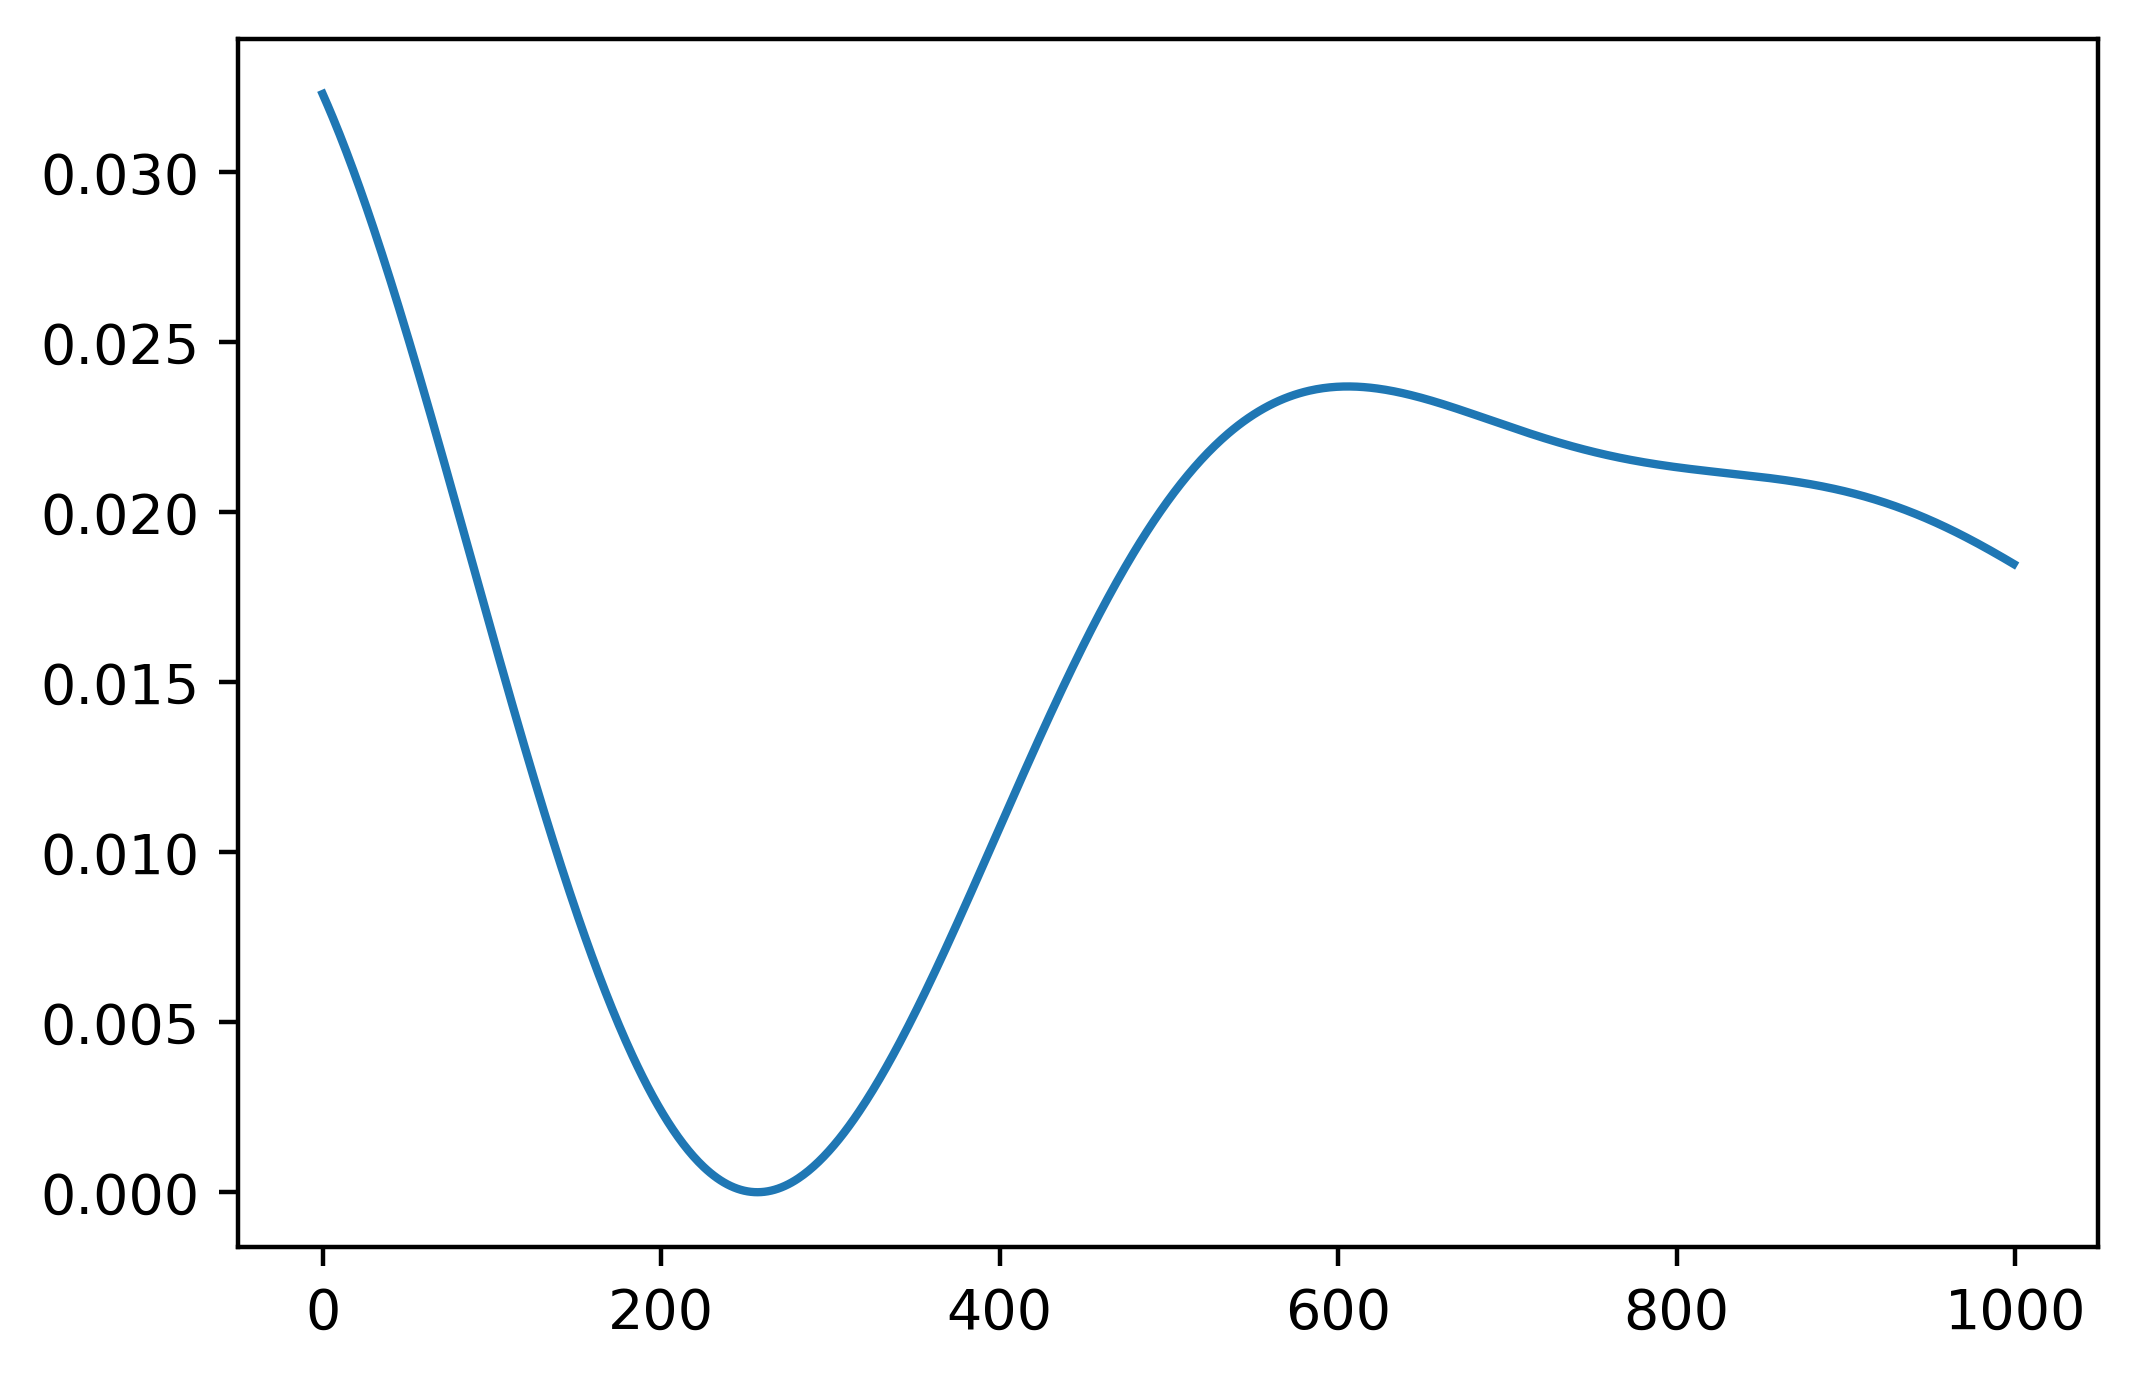

In [129]:


data, drift = add_baseline_drift(np.zeros(point_num))

plt.figure(dpi=400)
plt.plot(data)

In [89]:
point_num = CONFIG['point_num']
freq = CONFIG['sample_frequency']
norm_len = CONFIG['default_norm_len']
height_max = CONFIG['height_max']

In [132]:
# 生成数据
overlap_rate_list = np.arange(0.2, 0.6, 0.1)
peak_num_list = np.arange(5, 50, 1)
snr_list = np.arange(10, 40, 5)

sample_num = 10000

raw_data = np.zeros((sample_num, point_num))
noise_data = np.zeros((sample_num, point_num))
white_noise = np.zeros((sample_num, point_num))
drift_noise = np.zeros((sample_num, point_num))

for i in range(sample_num):
    overlap_rate = random.choice(overlap_rate_list)
    peak_num = random.choice(peak_num_list)
    snr = random.choice(snr_list)
    
    sample, y = gen_one_sample(point_num, freq, overlap_rate, peak_num, height_max)
    sample_noise, noise = add_white_noise(sample, snr)
    sample_drift, drift = add_baseline_drift(sample_noise)
    
    raw_data[i, :] = sample
    noise_data[i, :] = sample_drift
    white_noise[i, :] = noise
    drift_noise[i, :] = drift
    np.save('../../data/simu_chromatography/peak_data/peak_'+str(i)+'.npy', y)
    
#     print('snr: ', snr)
#     print('sample: ', np.max(sample)-np.min(sample))
#     print('noise: ', np.max(noise)-np.min(noise))
#     print('sample / noise: ', ( np.max(sample)-np.min(sample) / (np.max(noise)-np.min(noise))))

#     plot_sample(point_num, sample, y)
# #     plt.figure(dpi=400)
#     plt.plot(sample_noise, linewidth=0.5)
#     plt.plot(sample_drift, linewidth=0.5)
#     plt.plot(sample, linewidth=0.5)
#     plt.plot(drift, linewidth=0.5)
#     plt.show()
    
np.save('../../data/simu_chromatography/raw_data.npy', raw_data)
np.save('../../data/simu_chromatography/noise_data.npy', noise_data)
np.save('../../data/simu_chromatography/white_noise.npy', white_noise)
np.save('../../data/simu_chromatography/drift_noise.npy', drift_noise)

# sample, y = gen_one_sample(point_num, 5, 0.6, 10)

In [ ]:
raw_data = np.load('../../data/simu_chromatography/raw_data.npy')
noise_data = np.load('../../data/simu_chromatography/noise_data.npy')
white_noise = np.load('../../data/simu_chromatography/white_noise.npy')
drift_noise = np.load('../../data/simu_chromatography/drift_noise.npy')

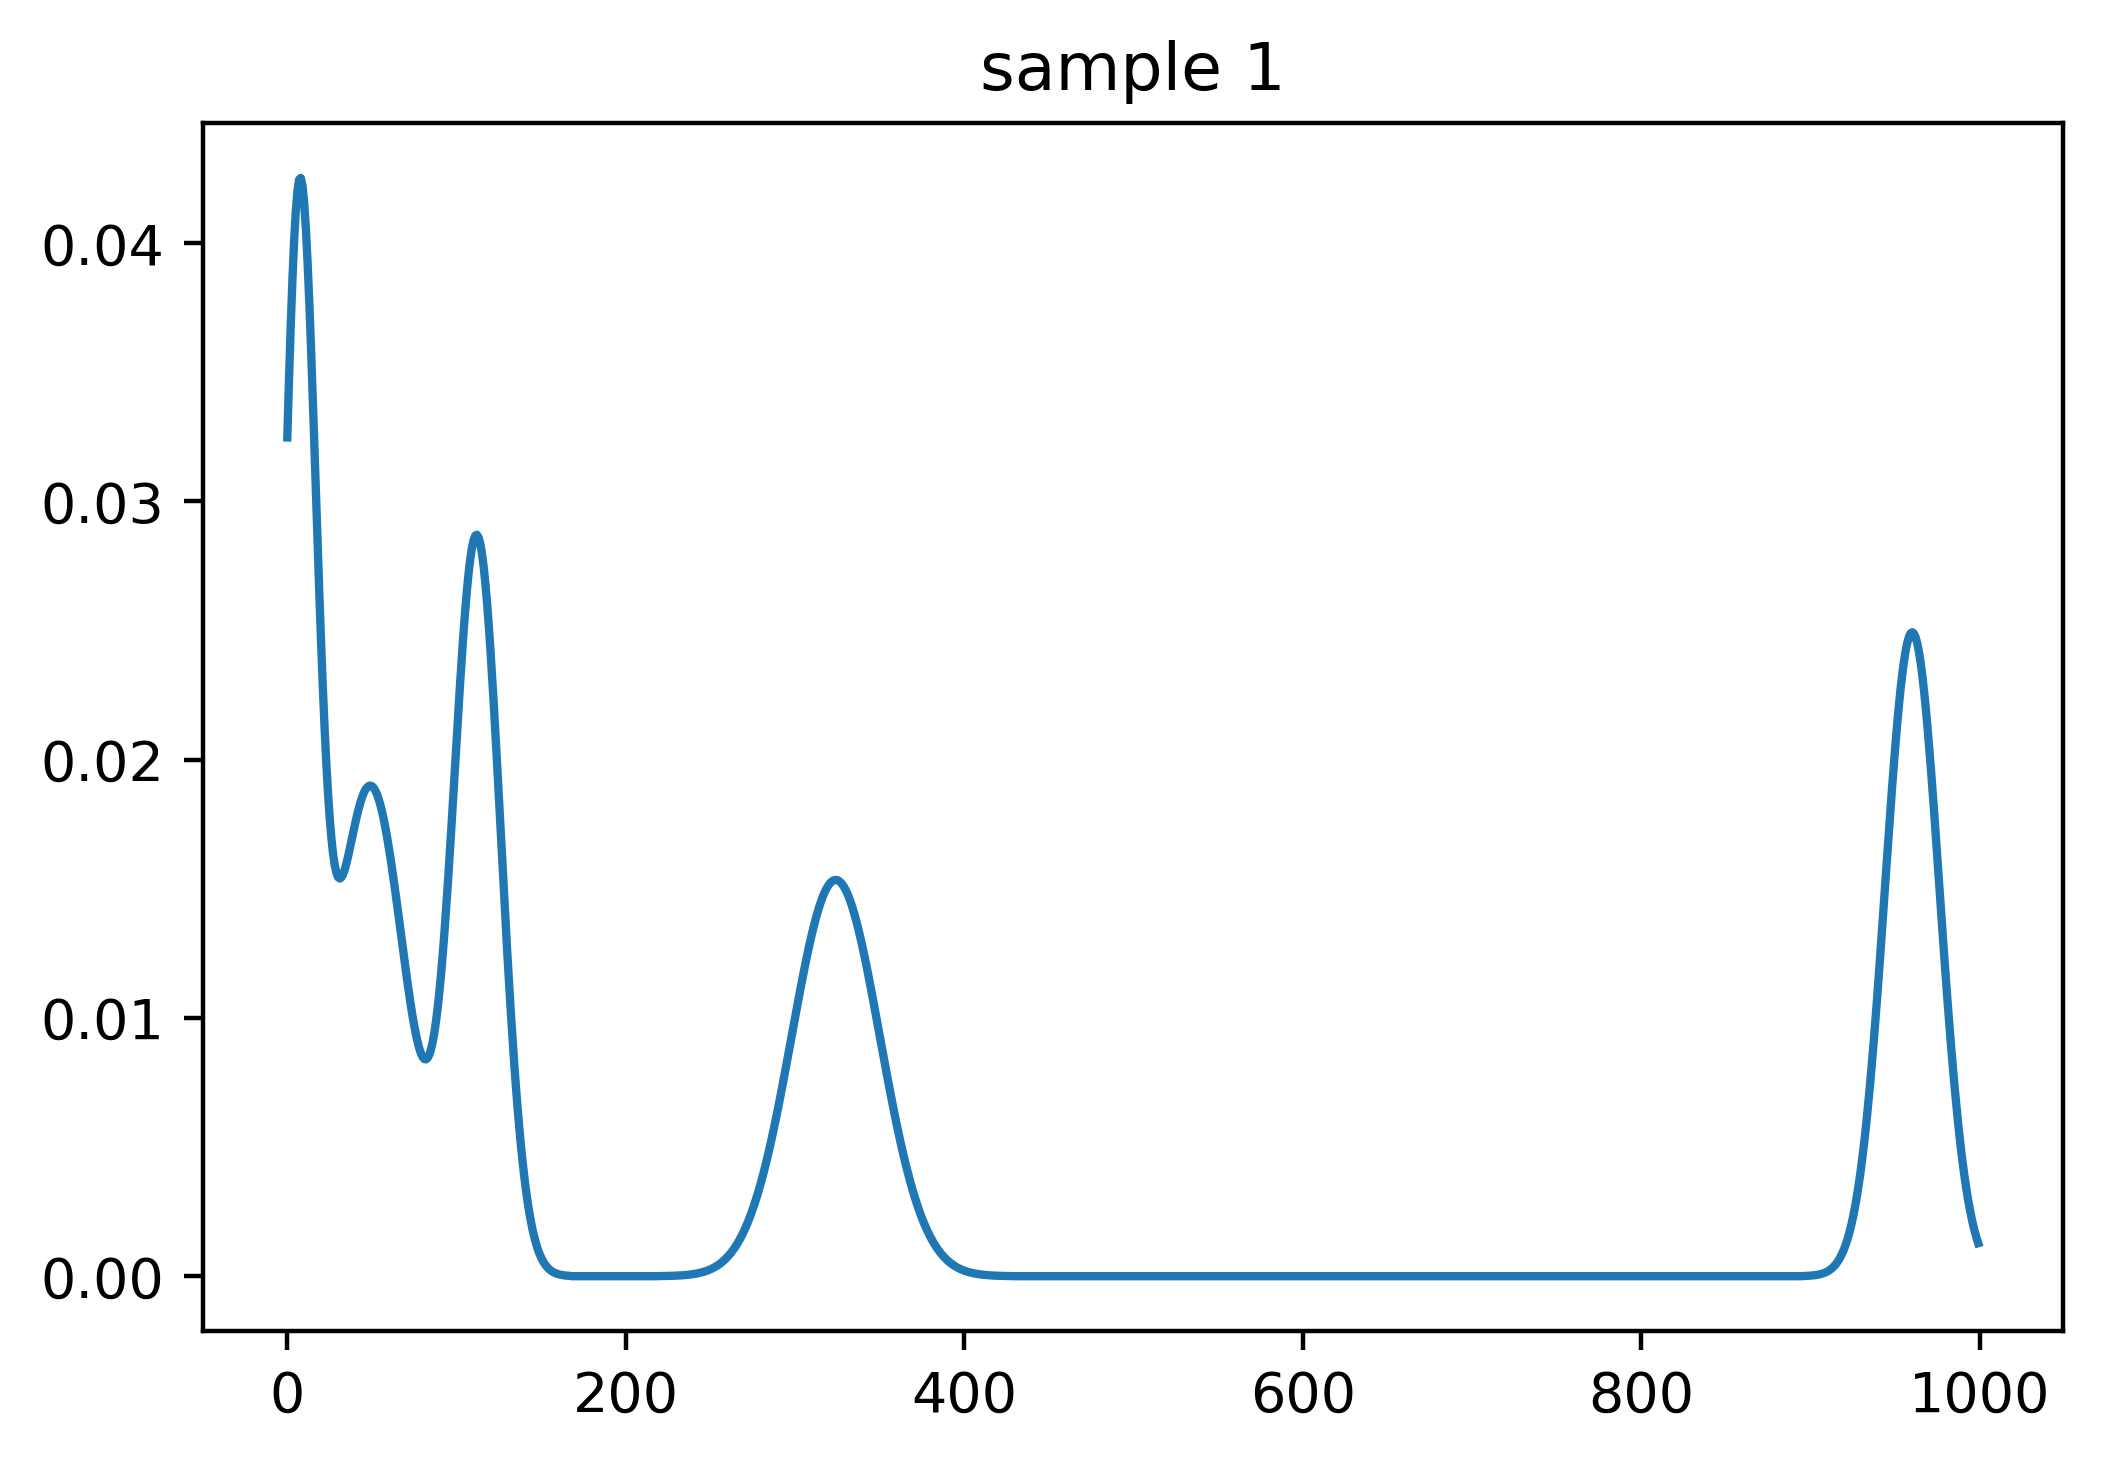

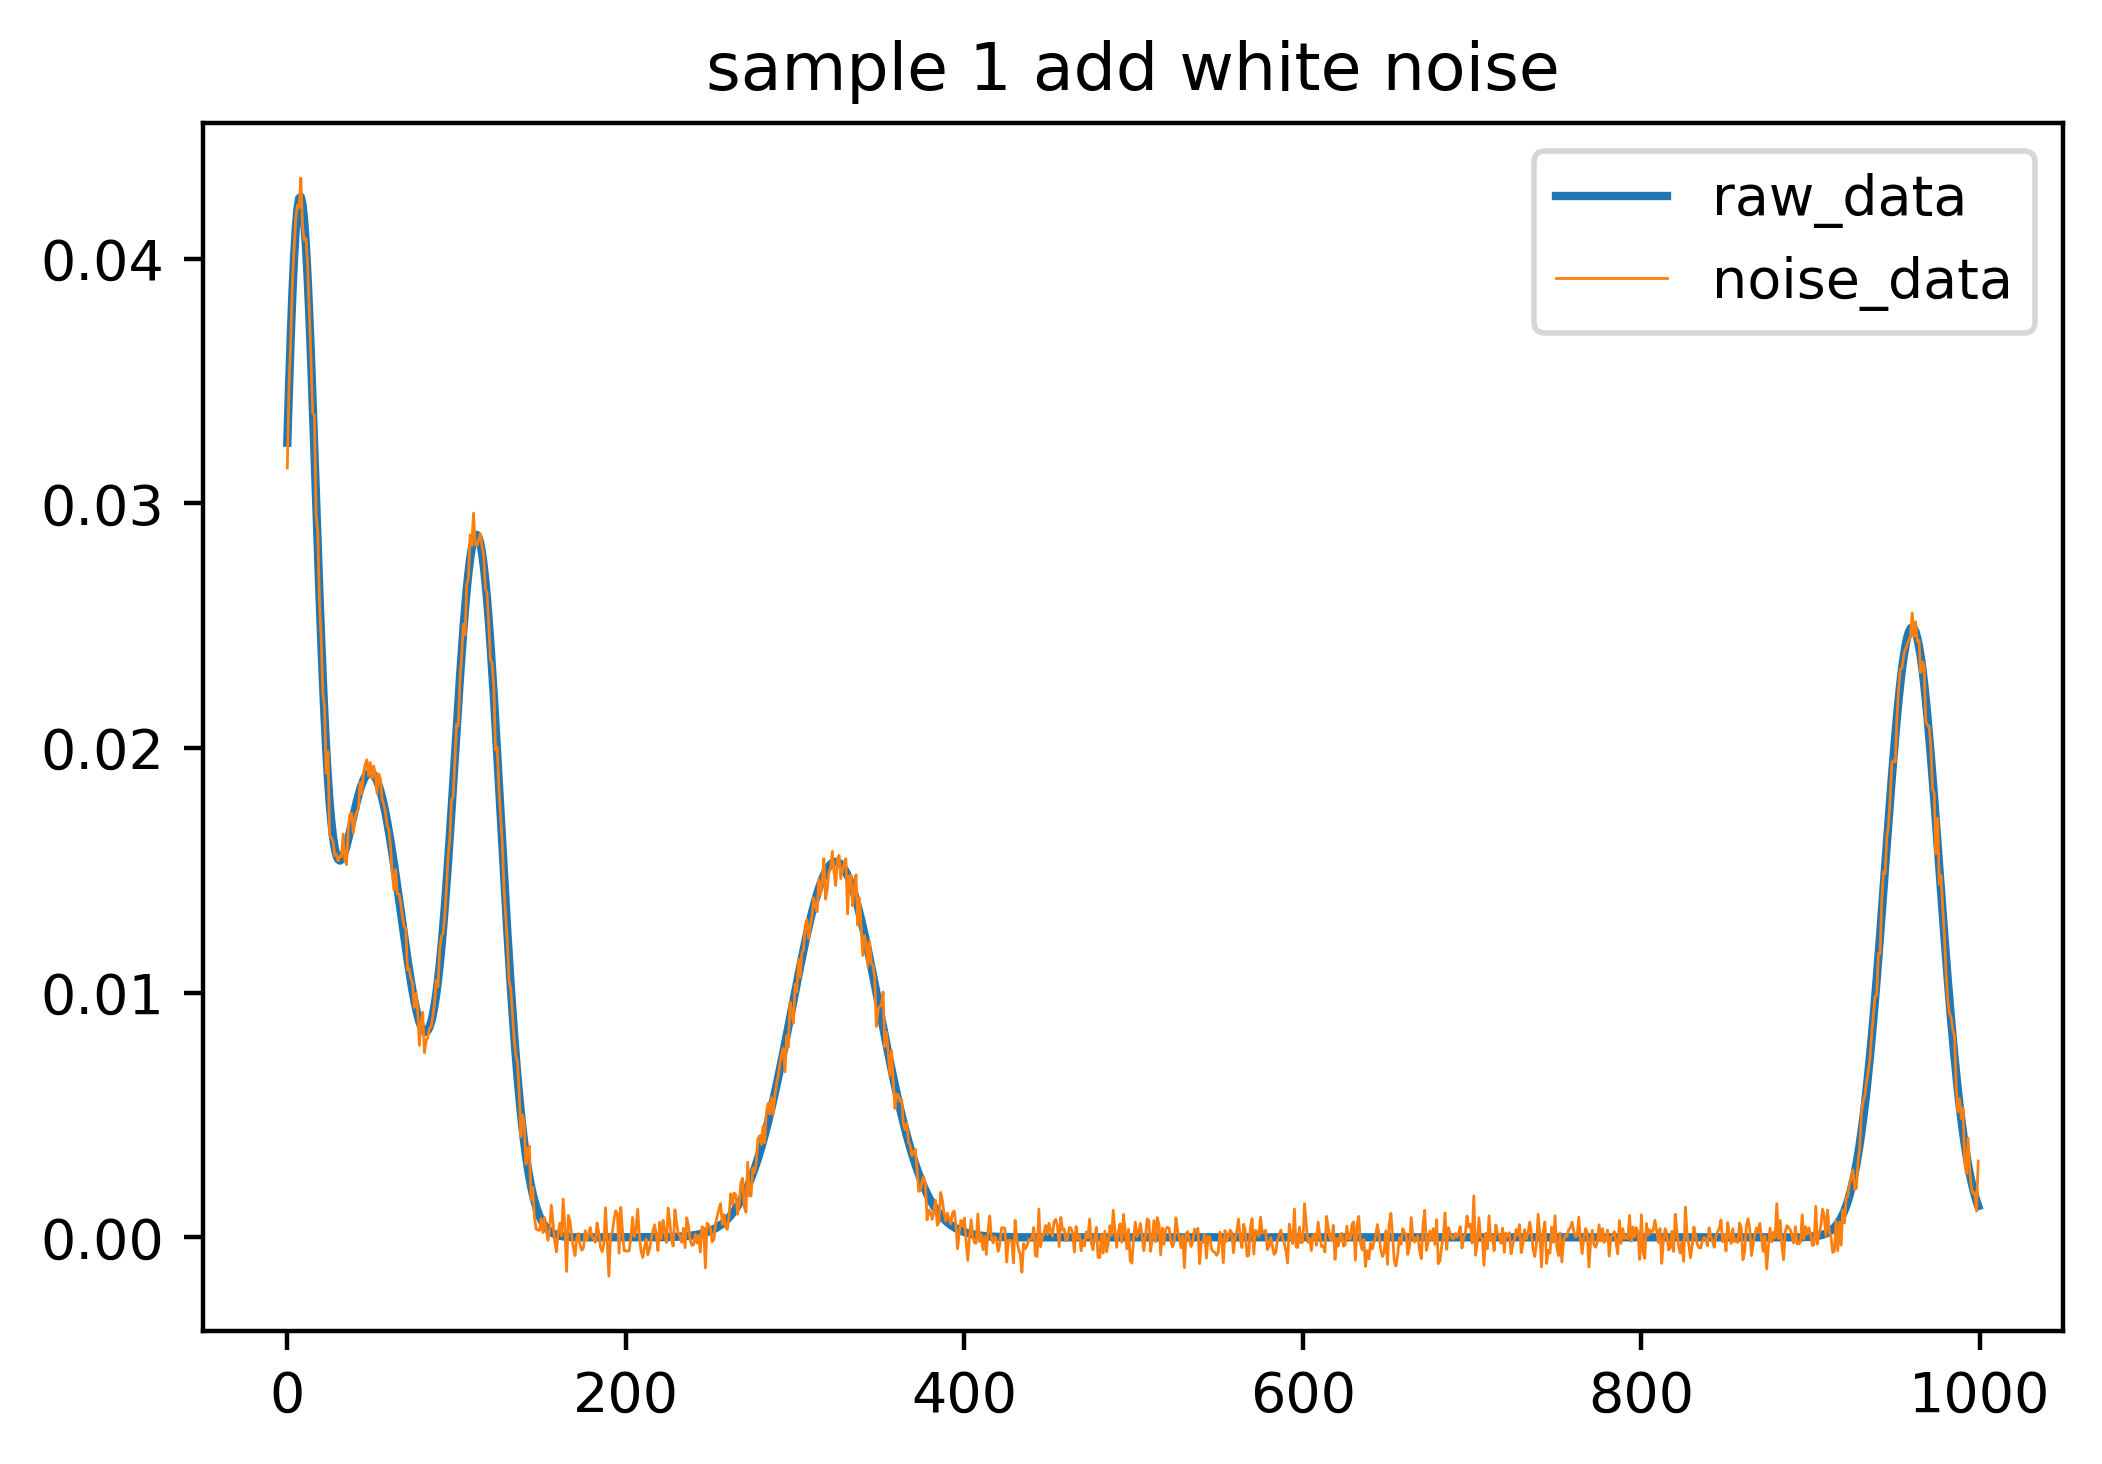

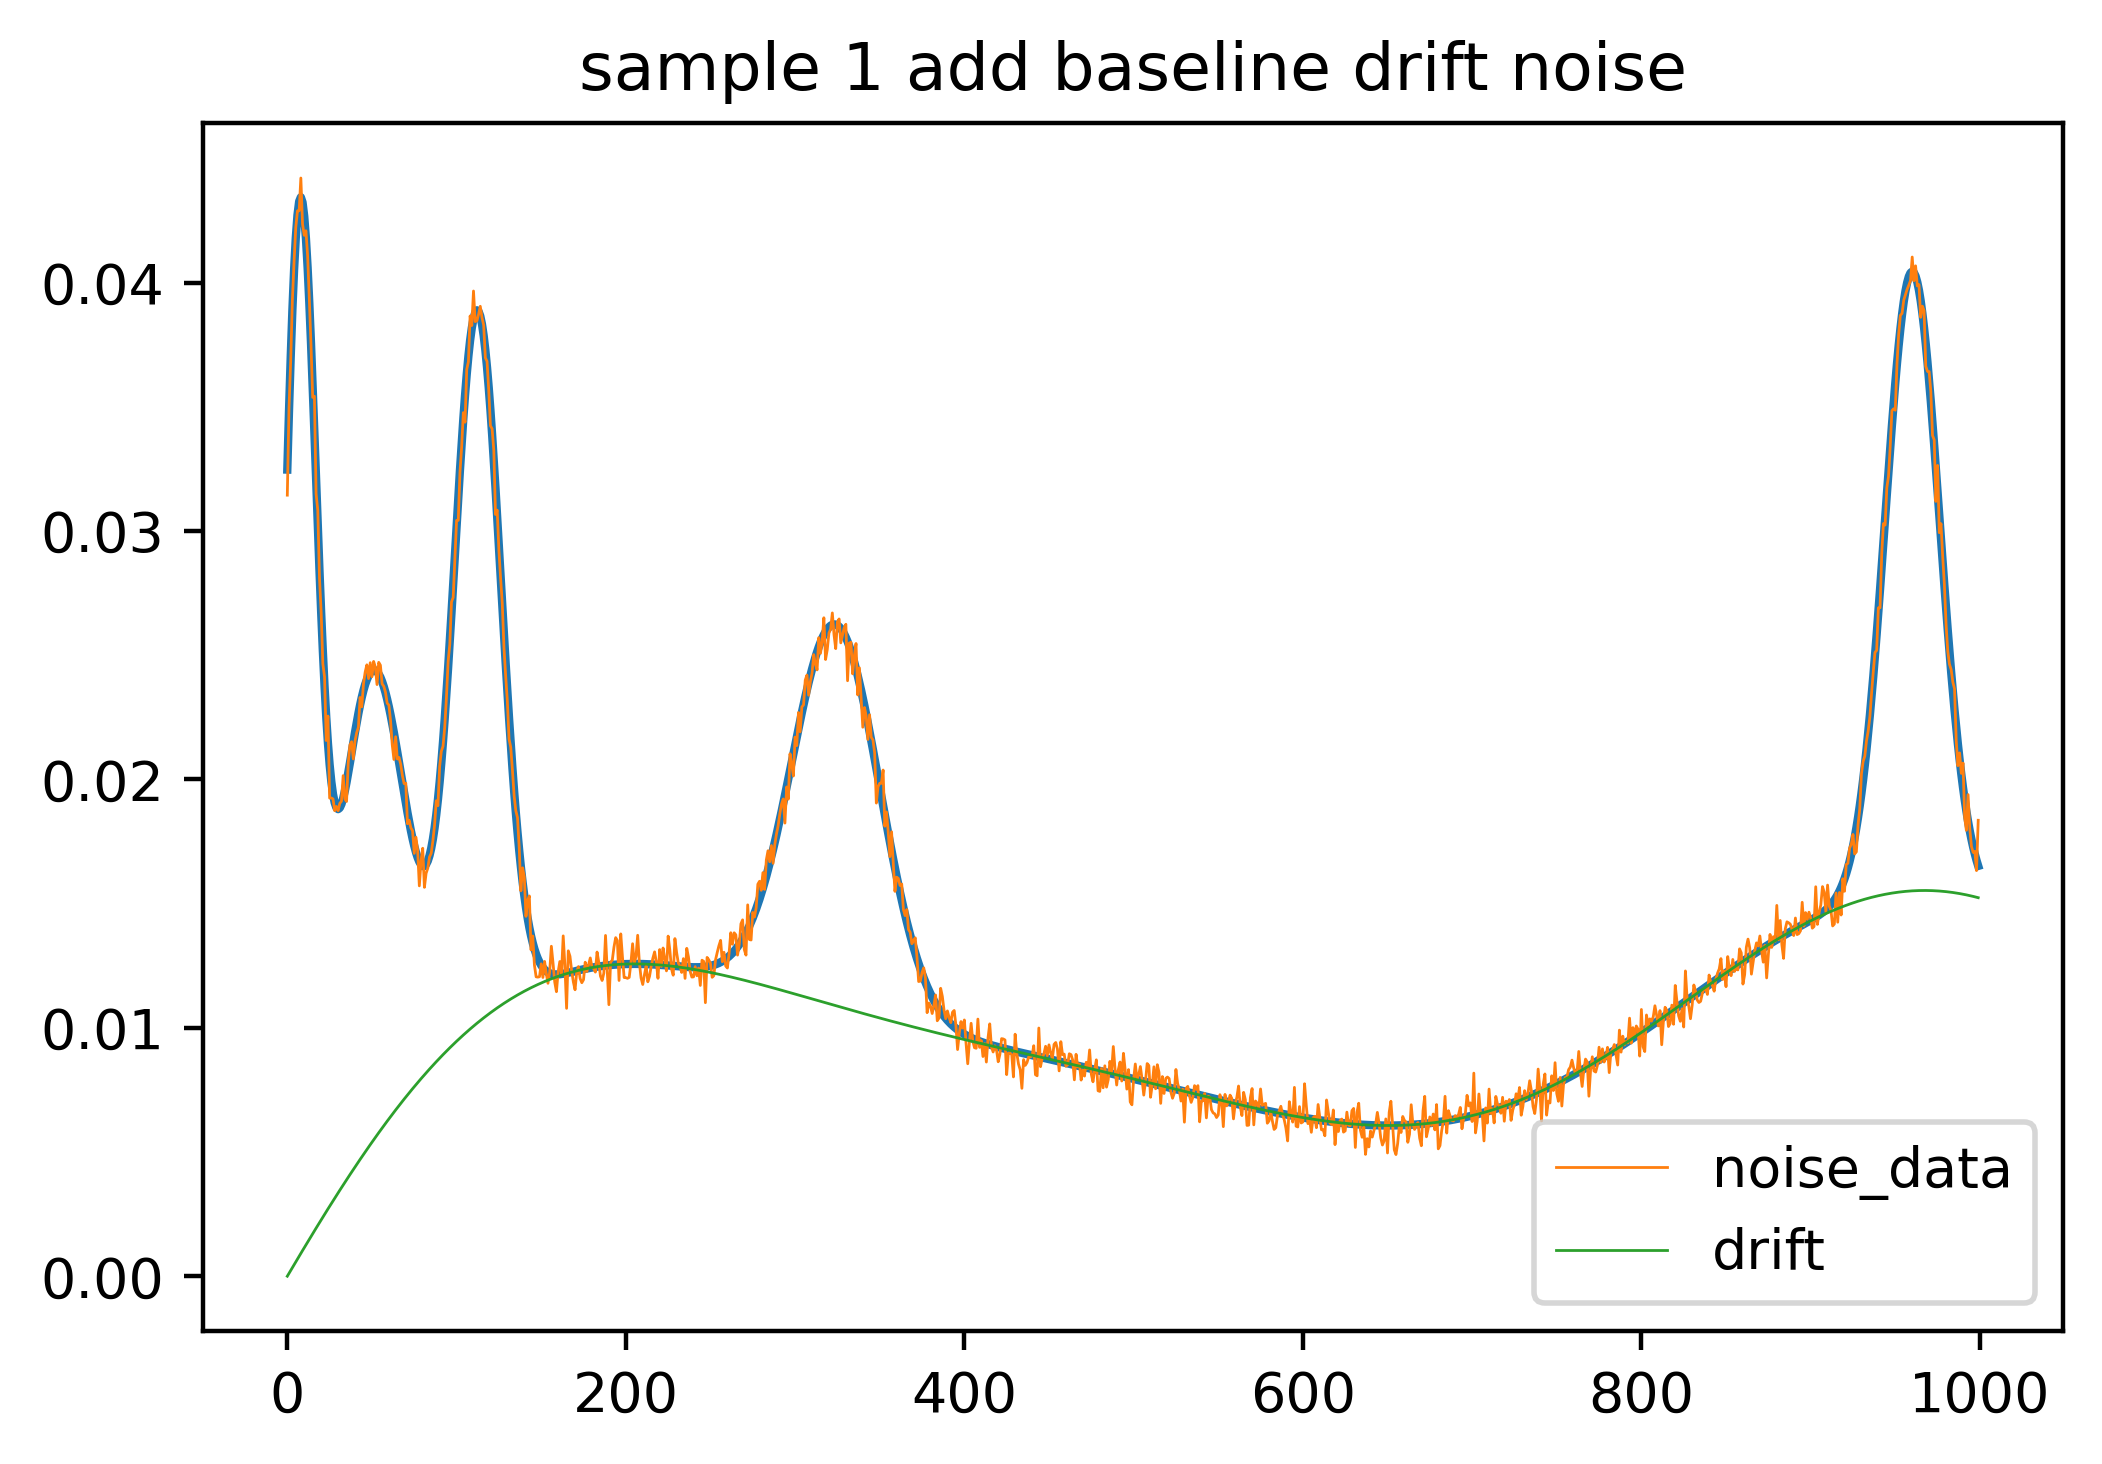

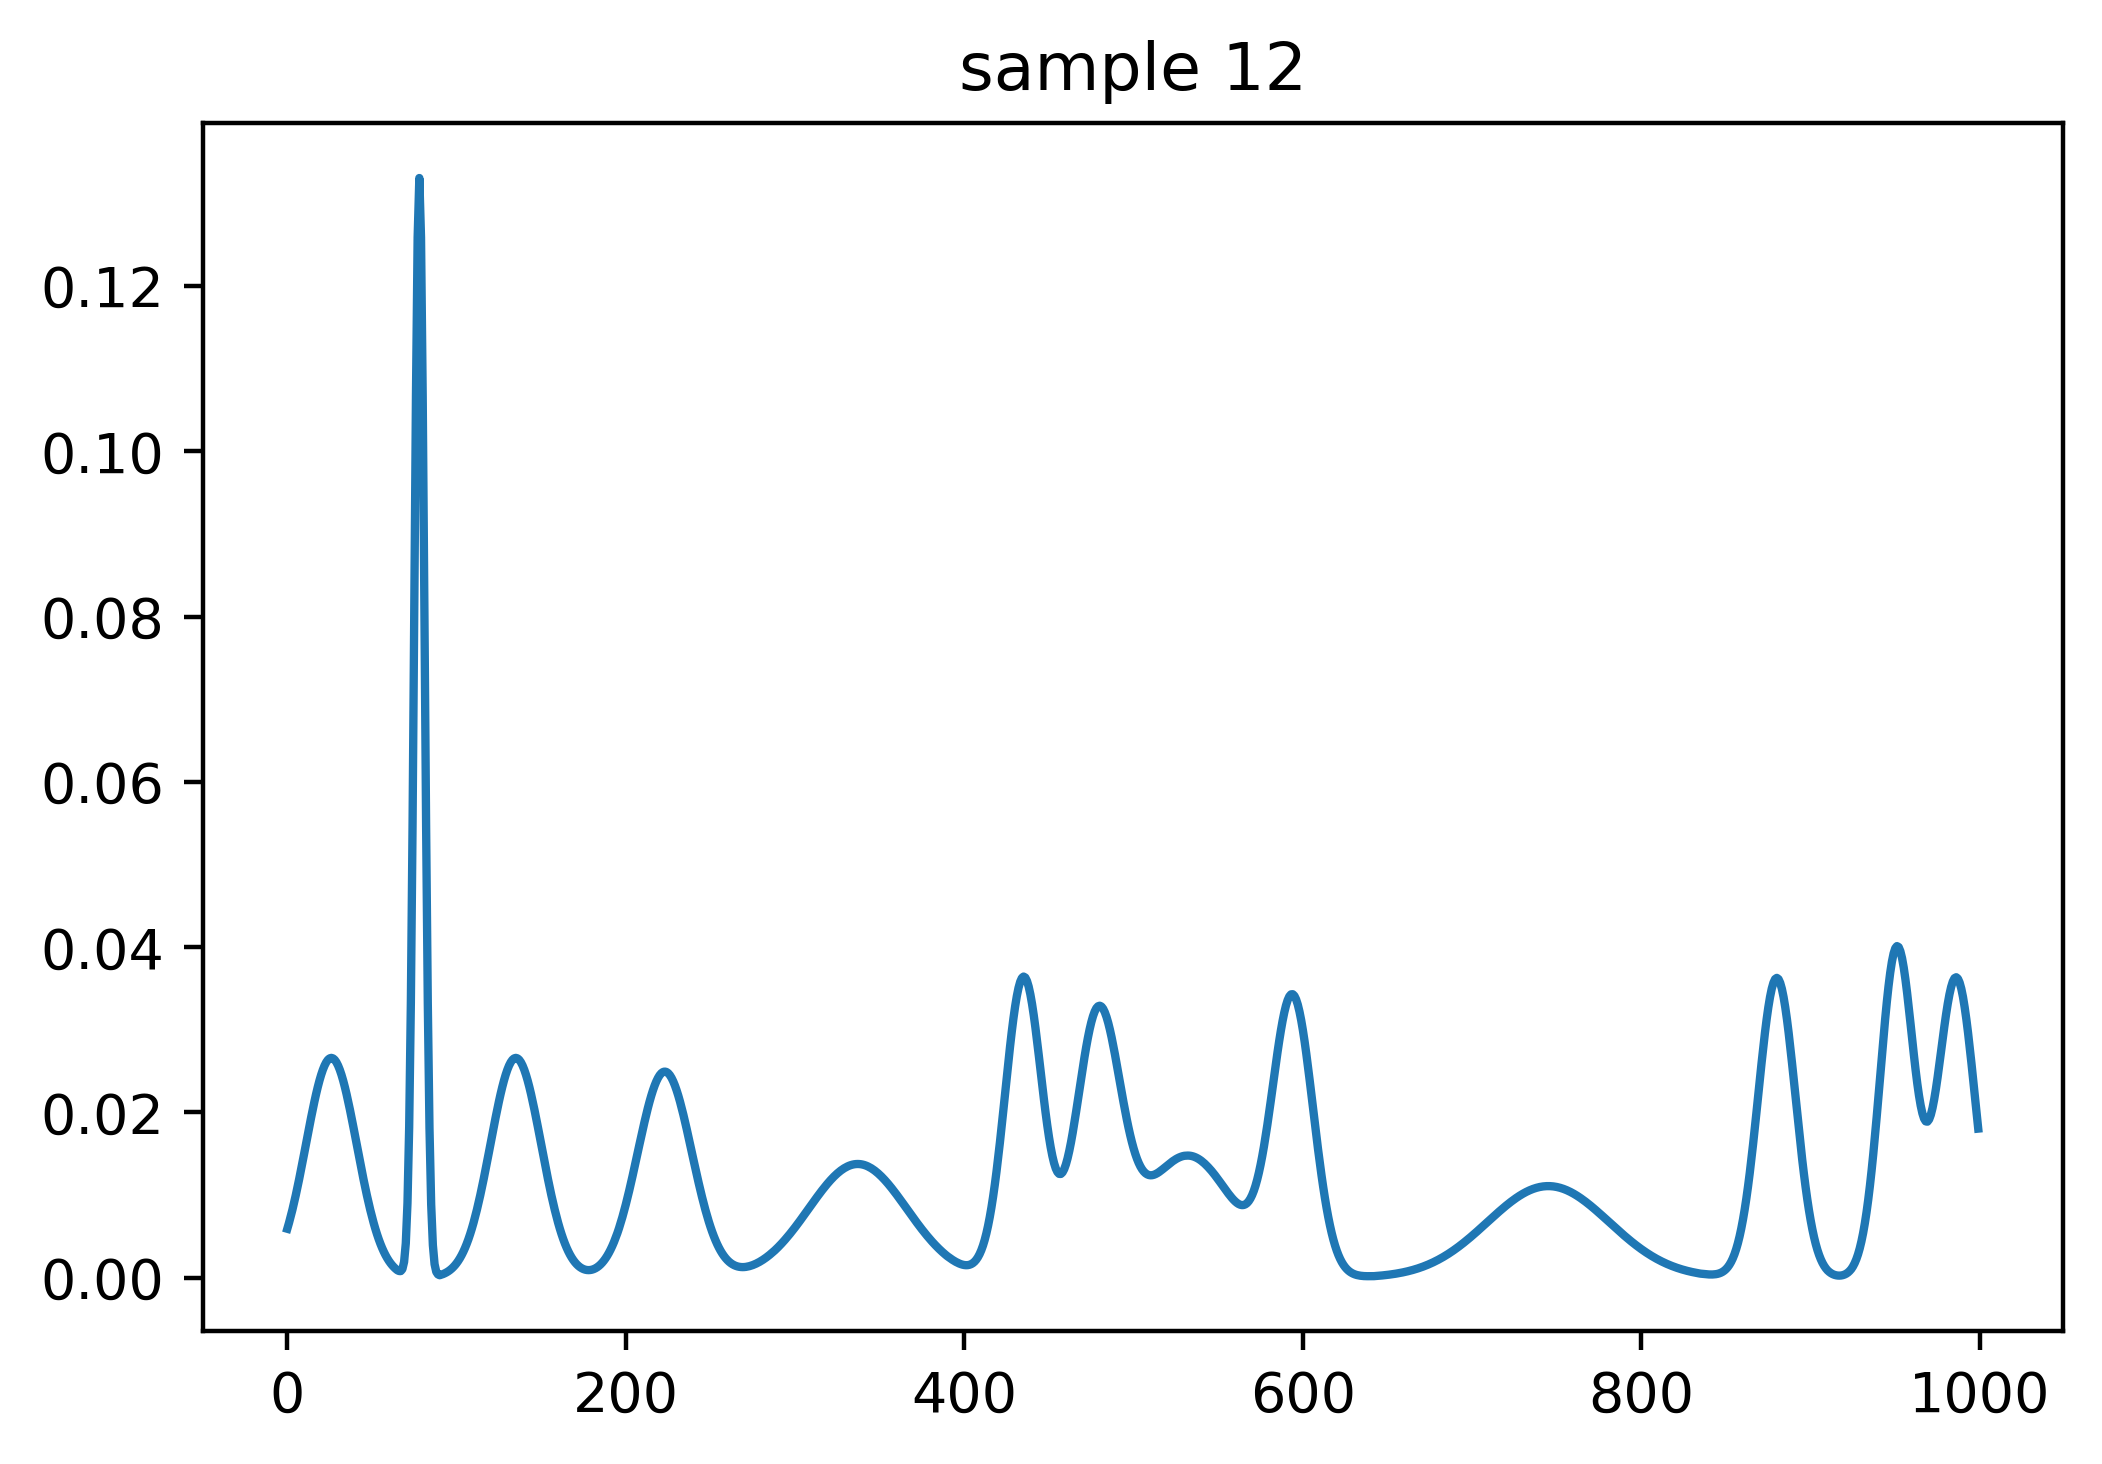

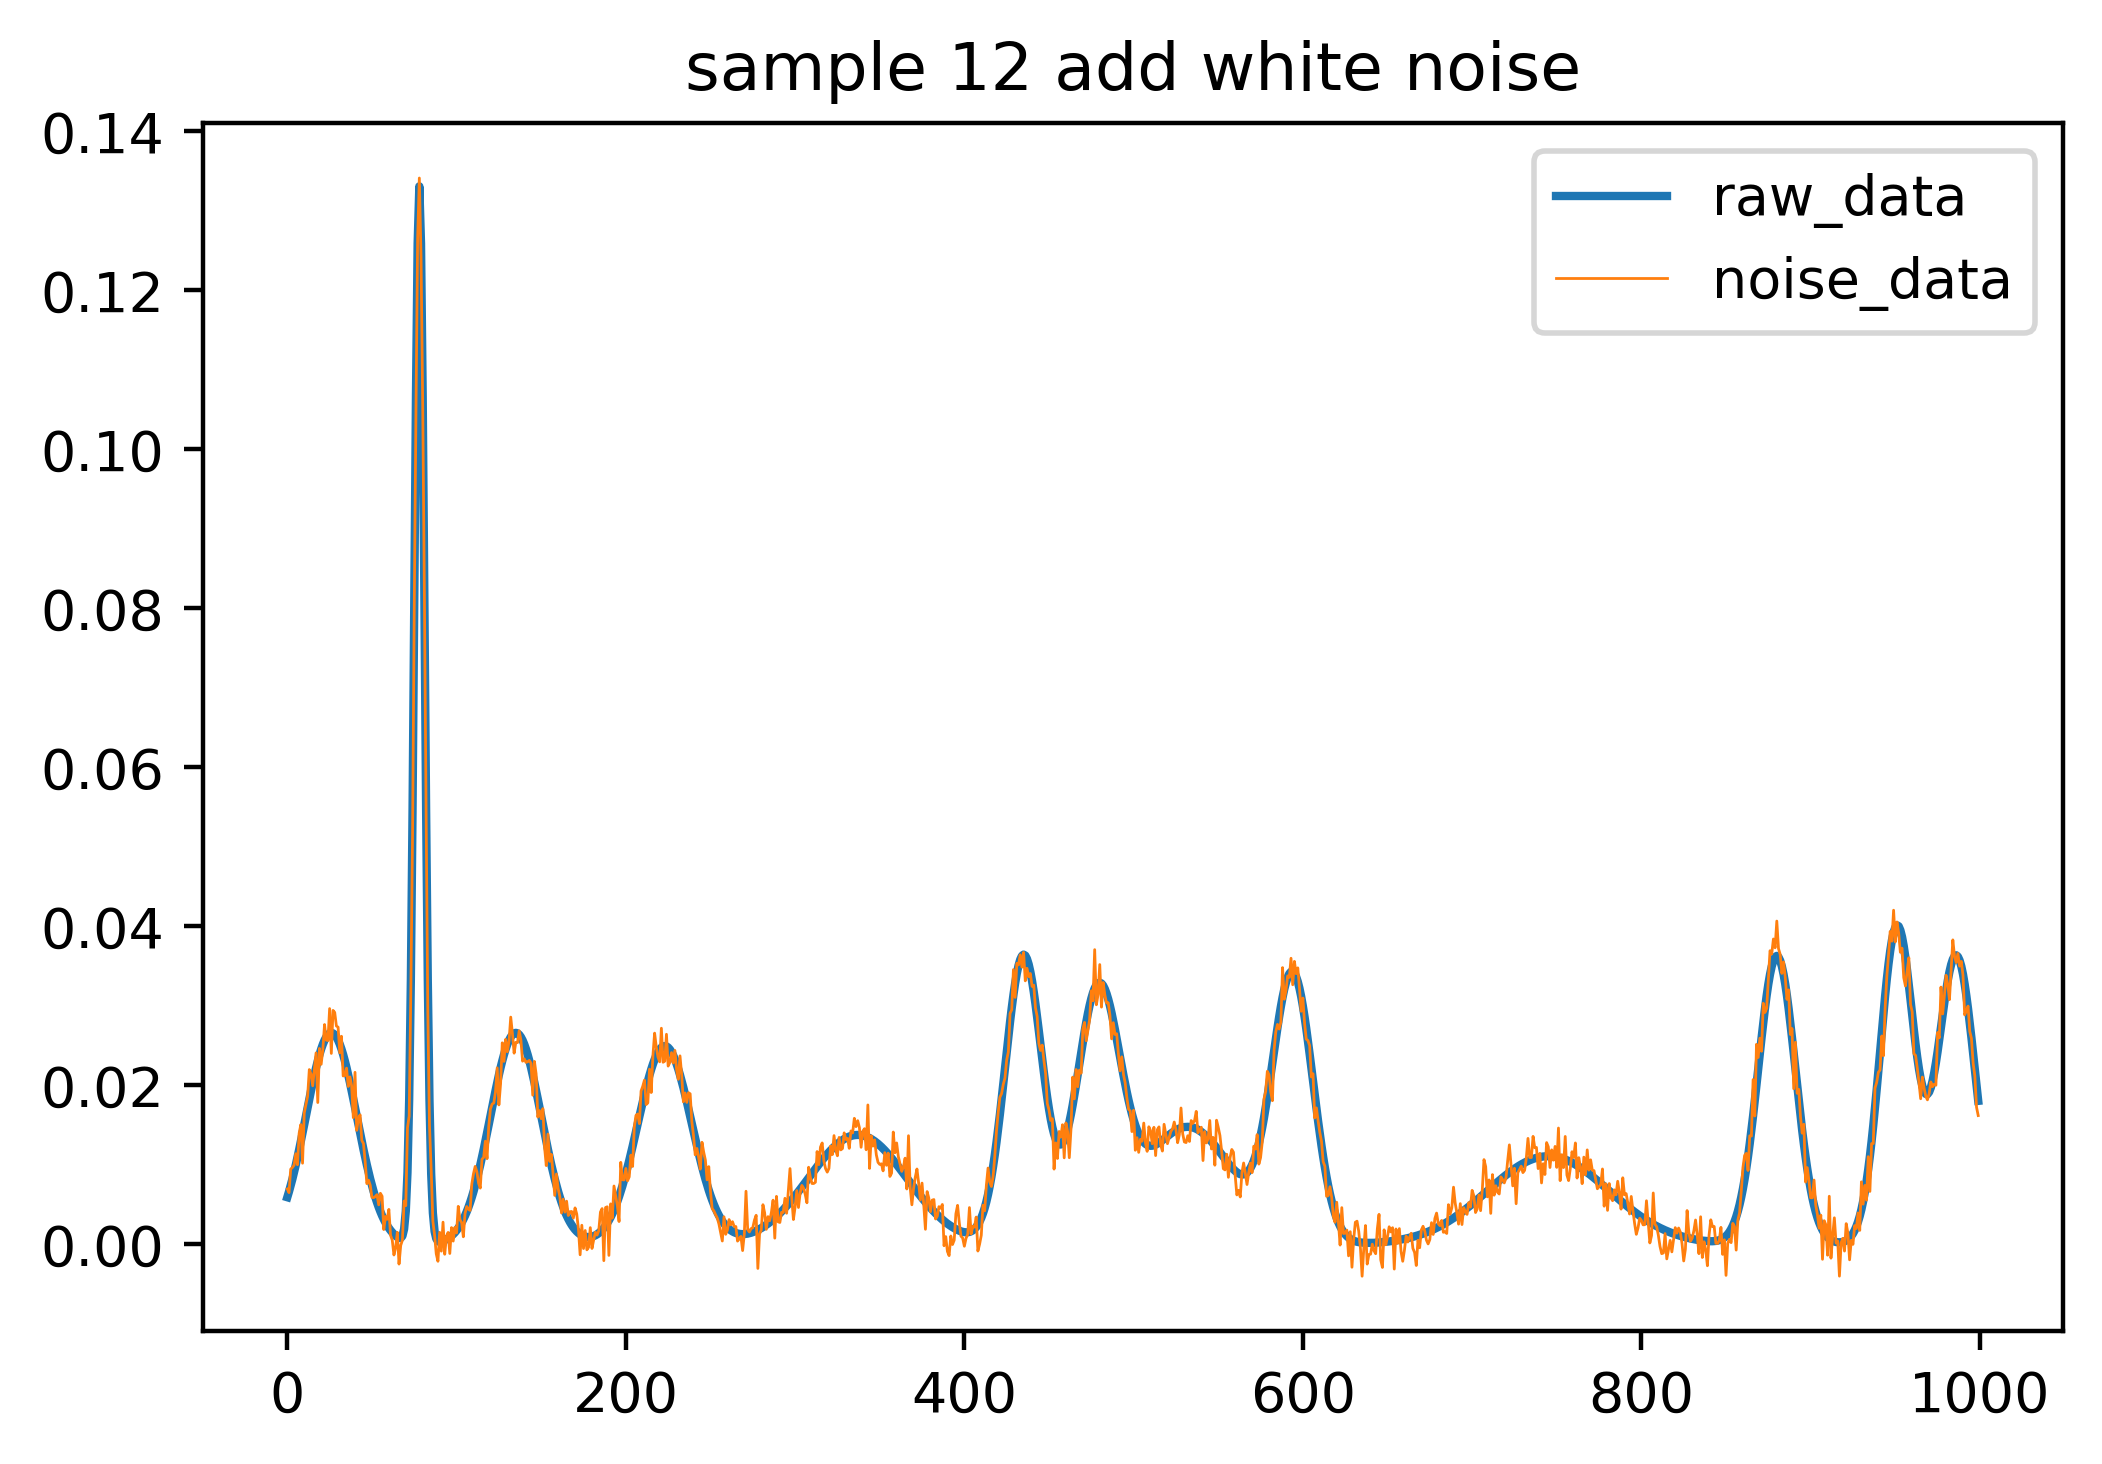

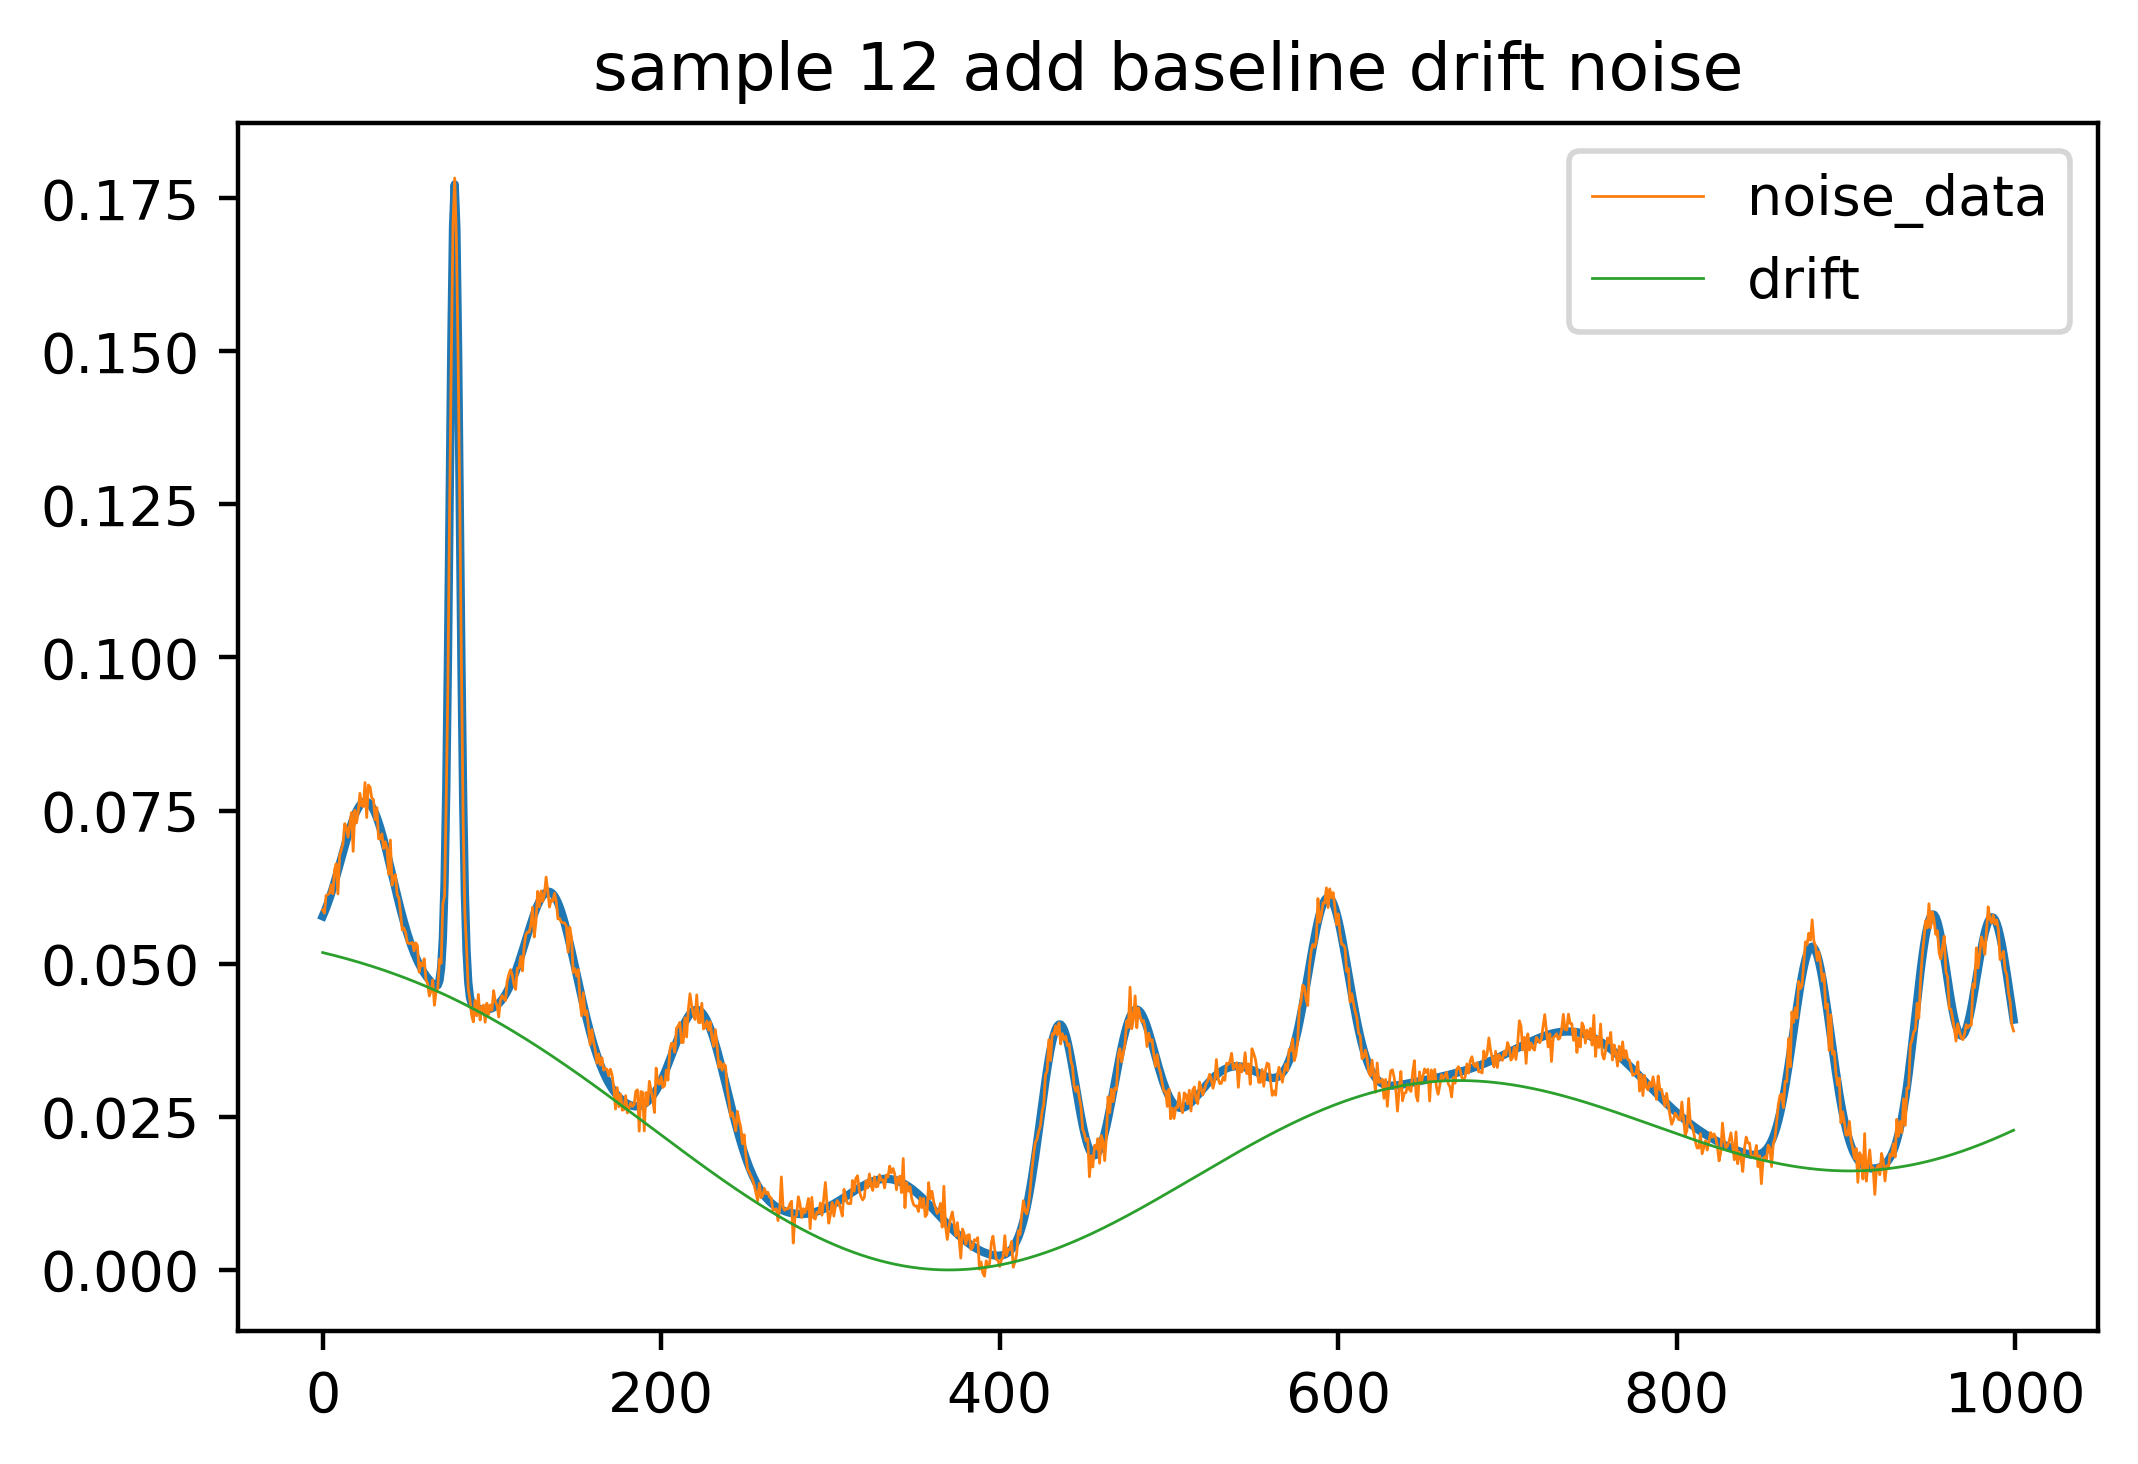

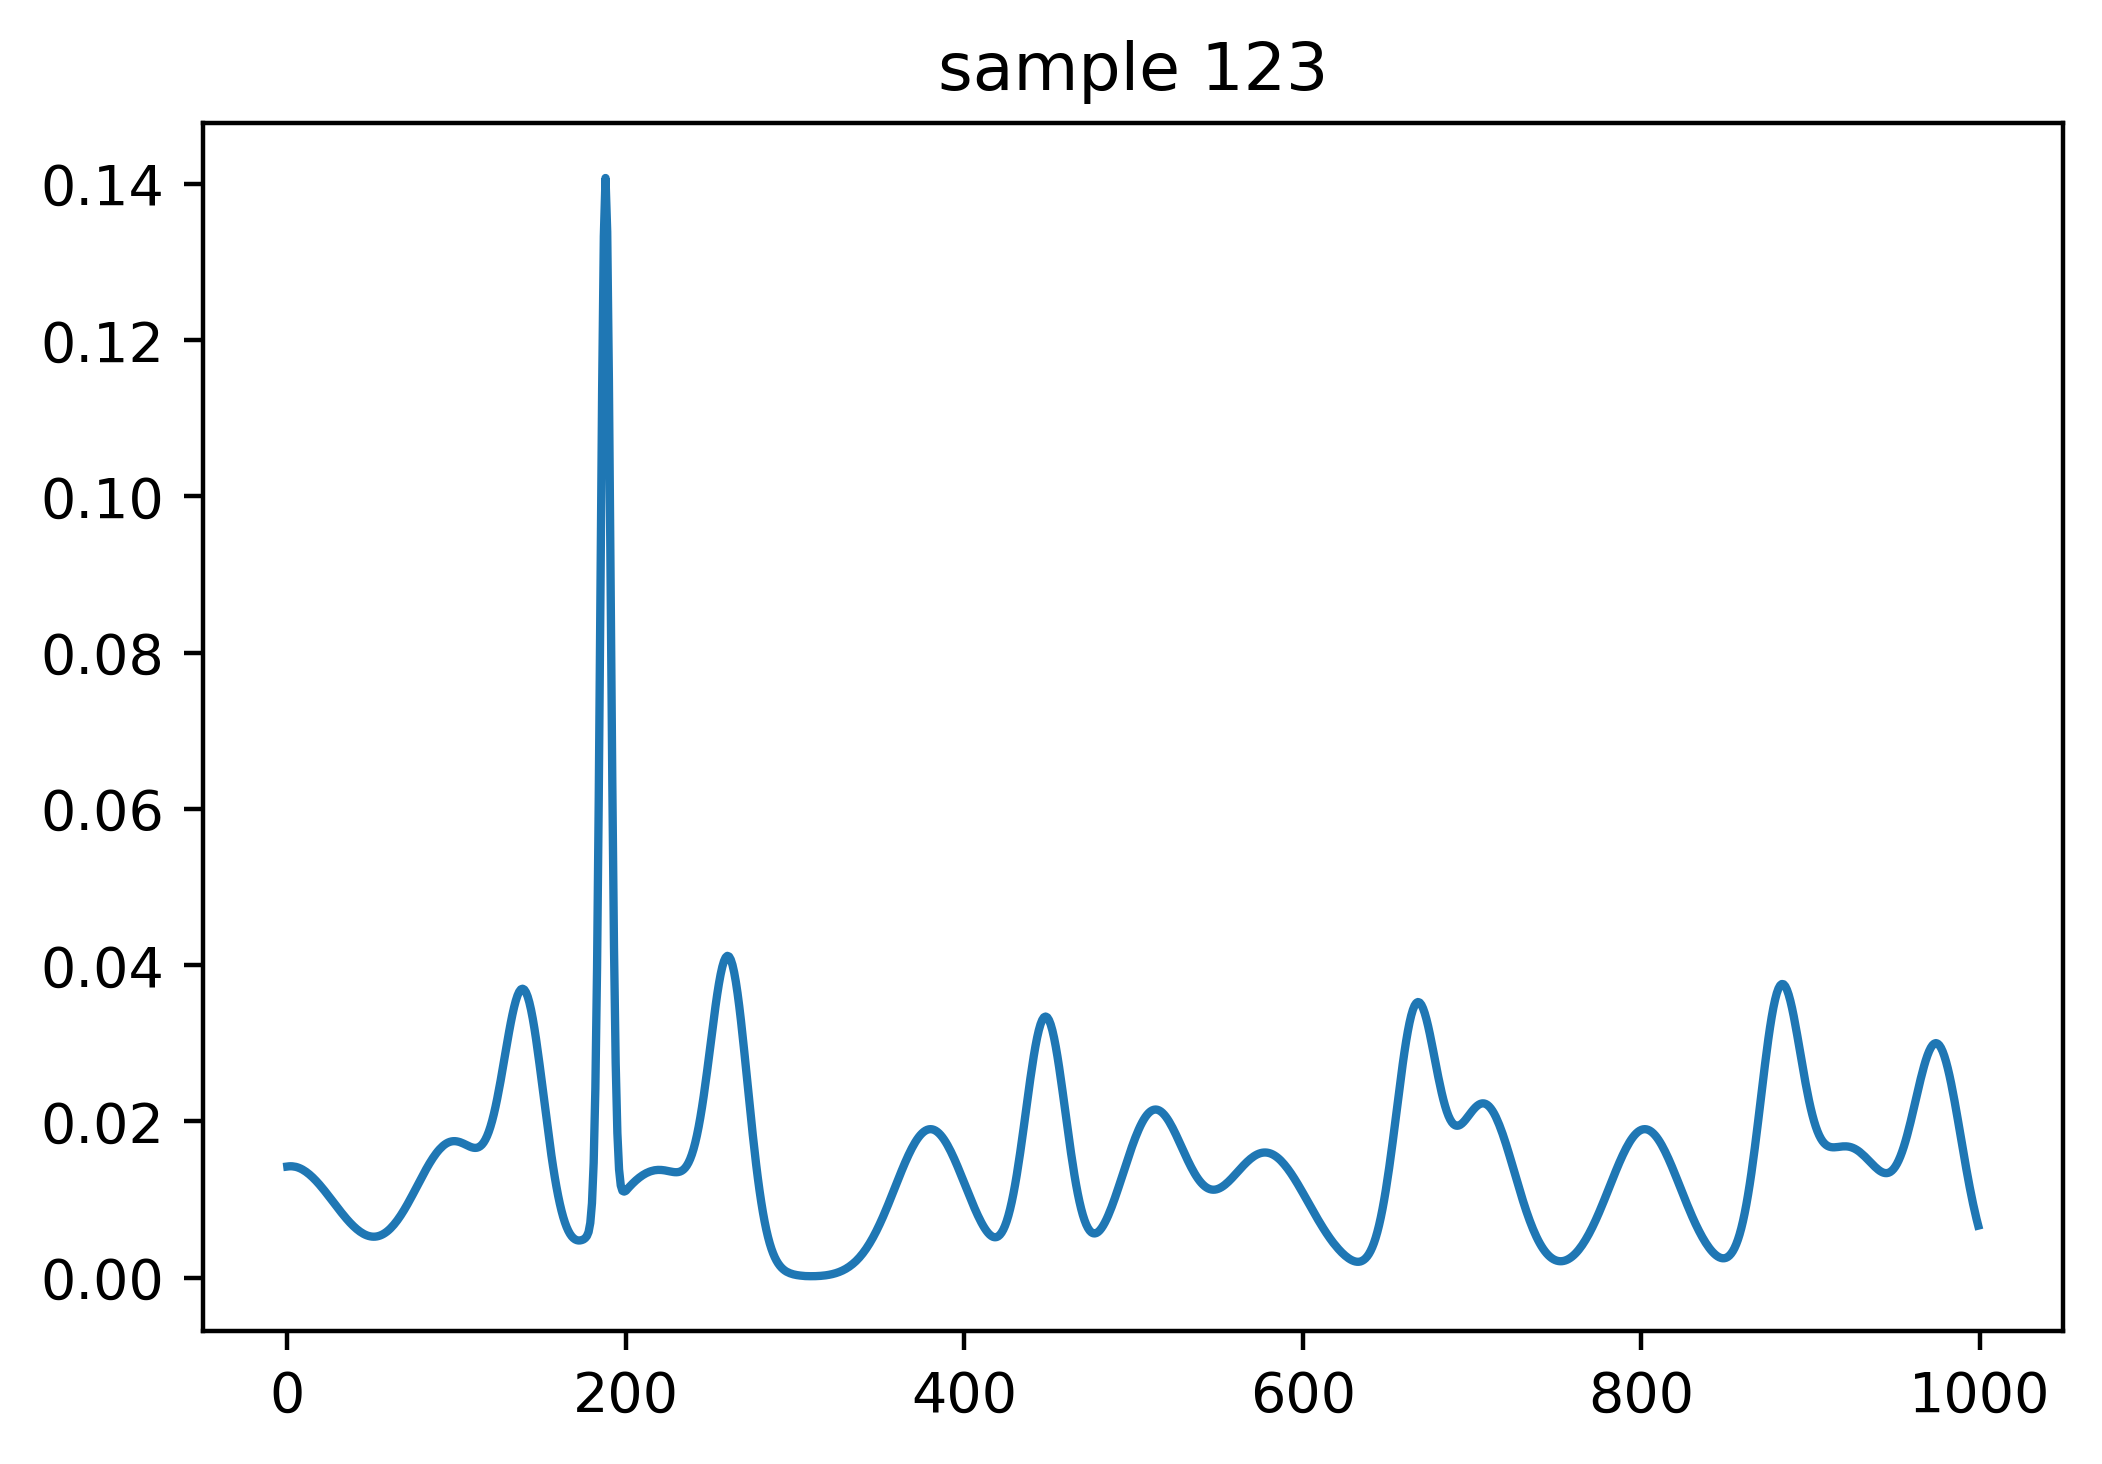

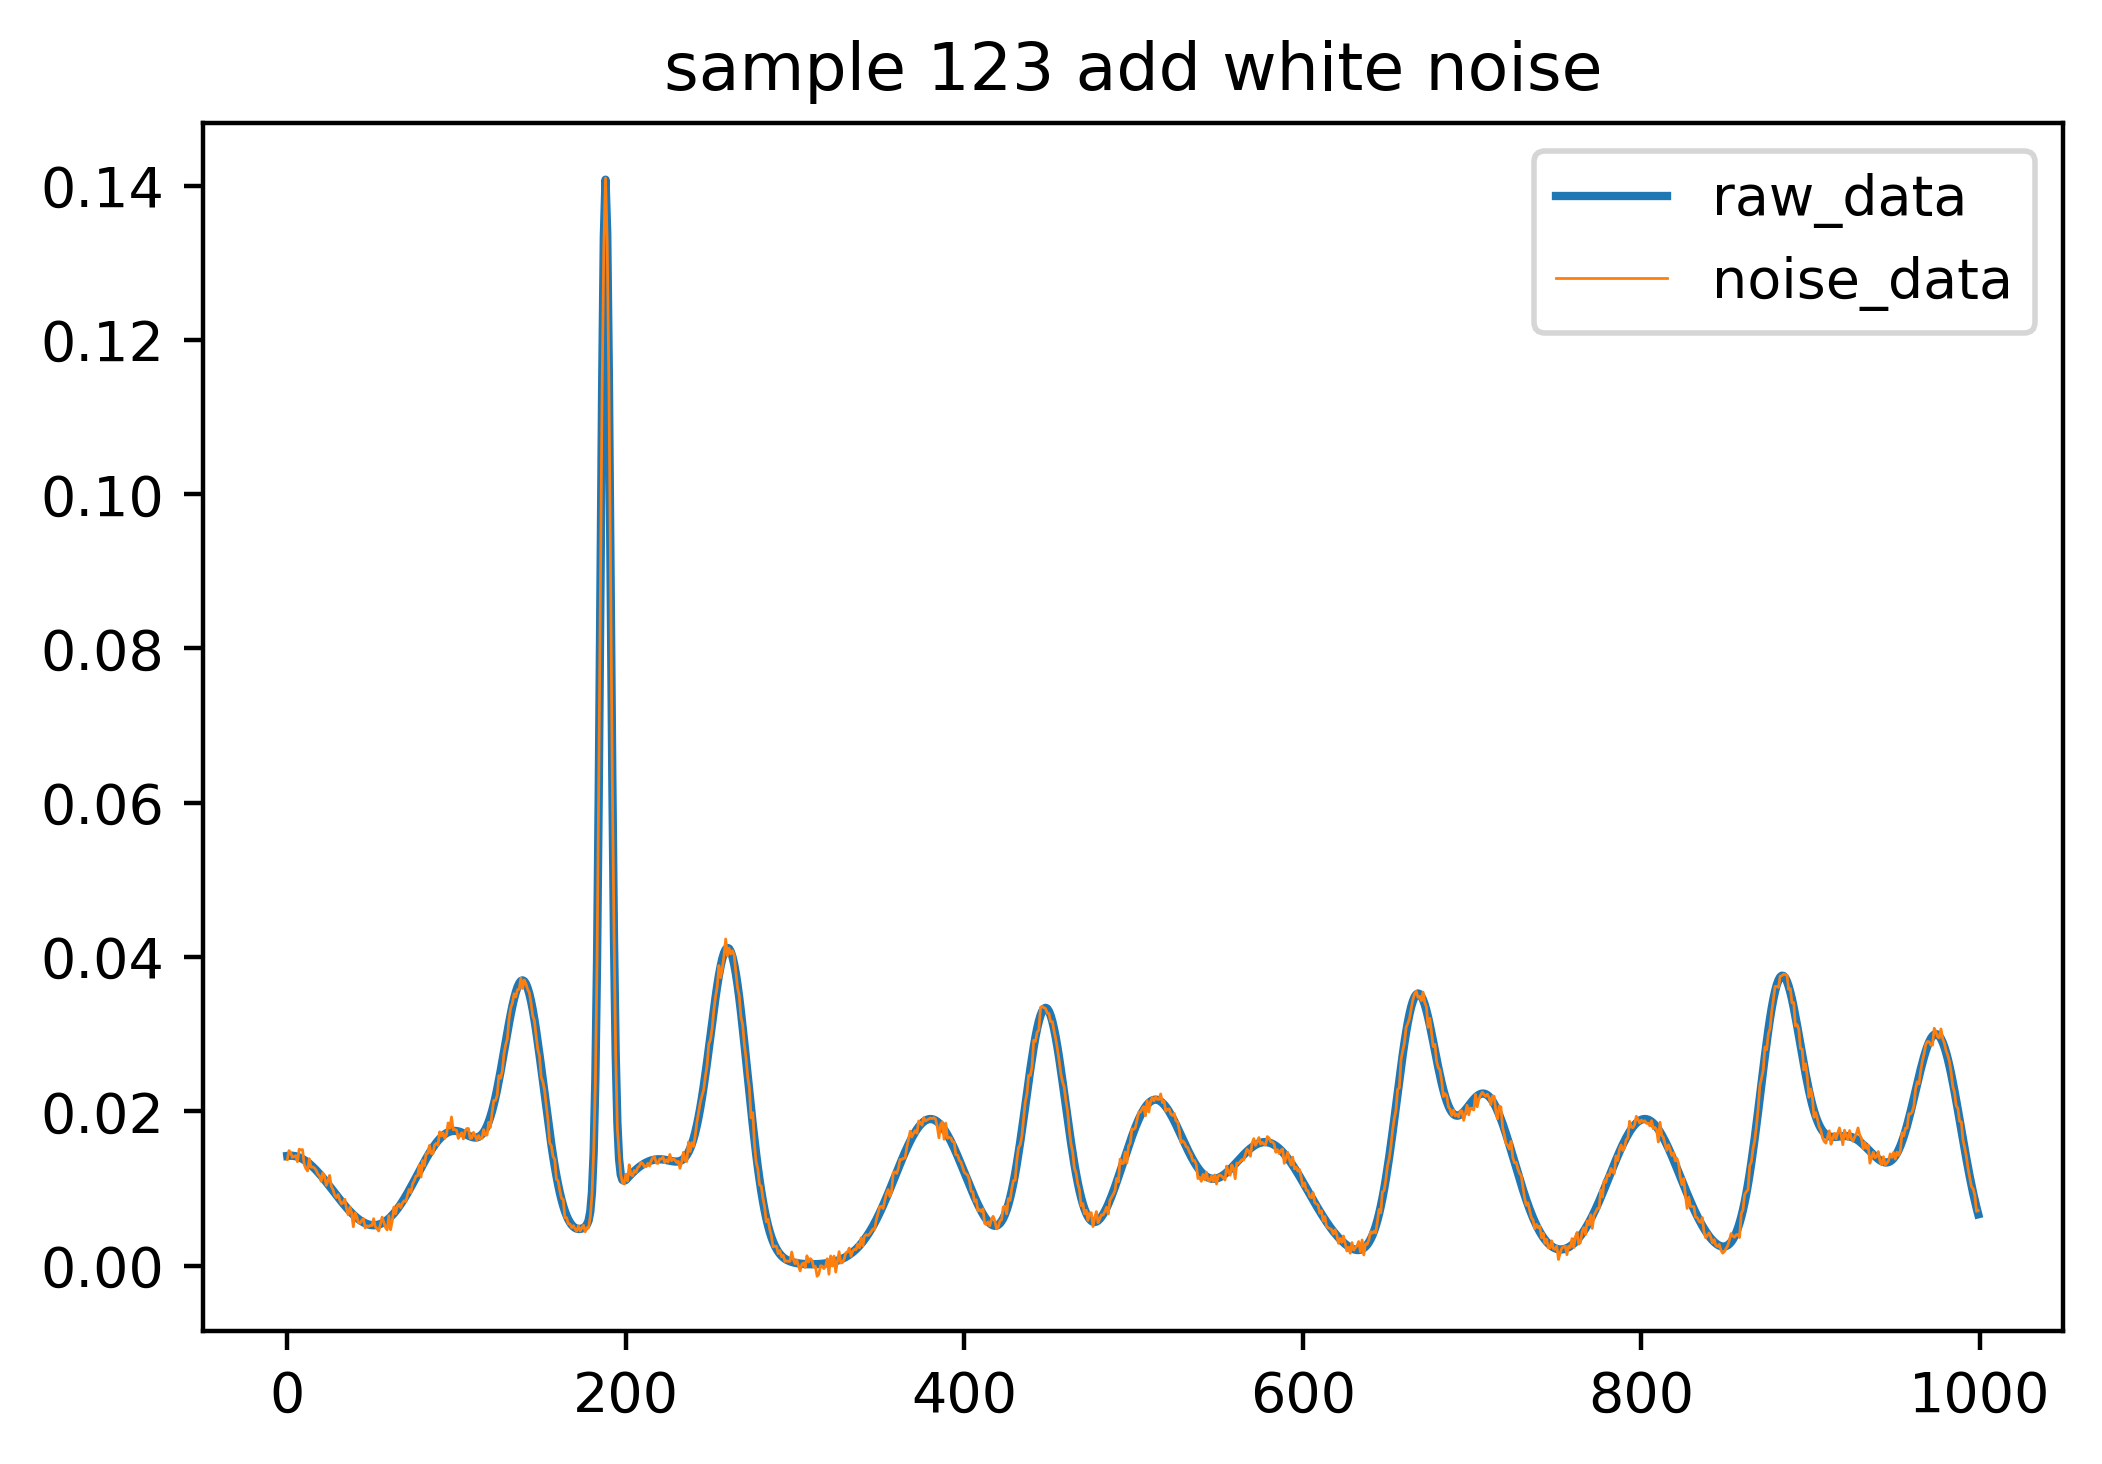

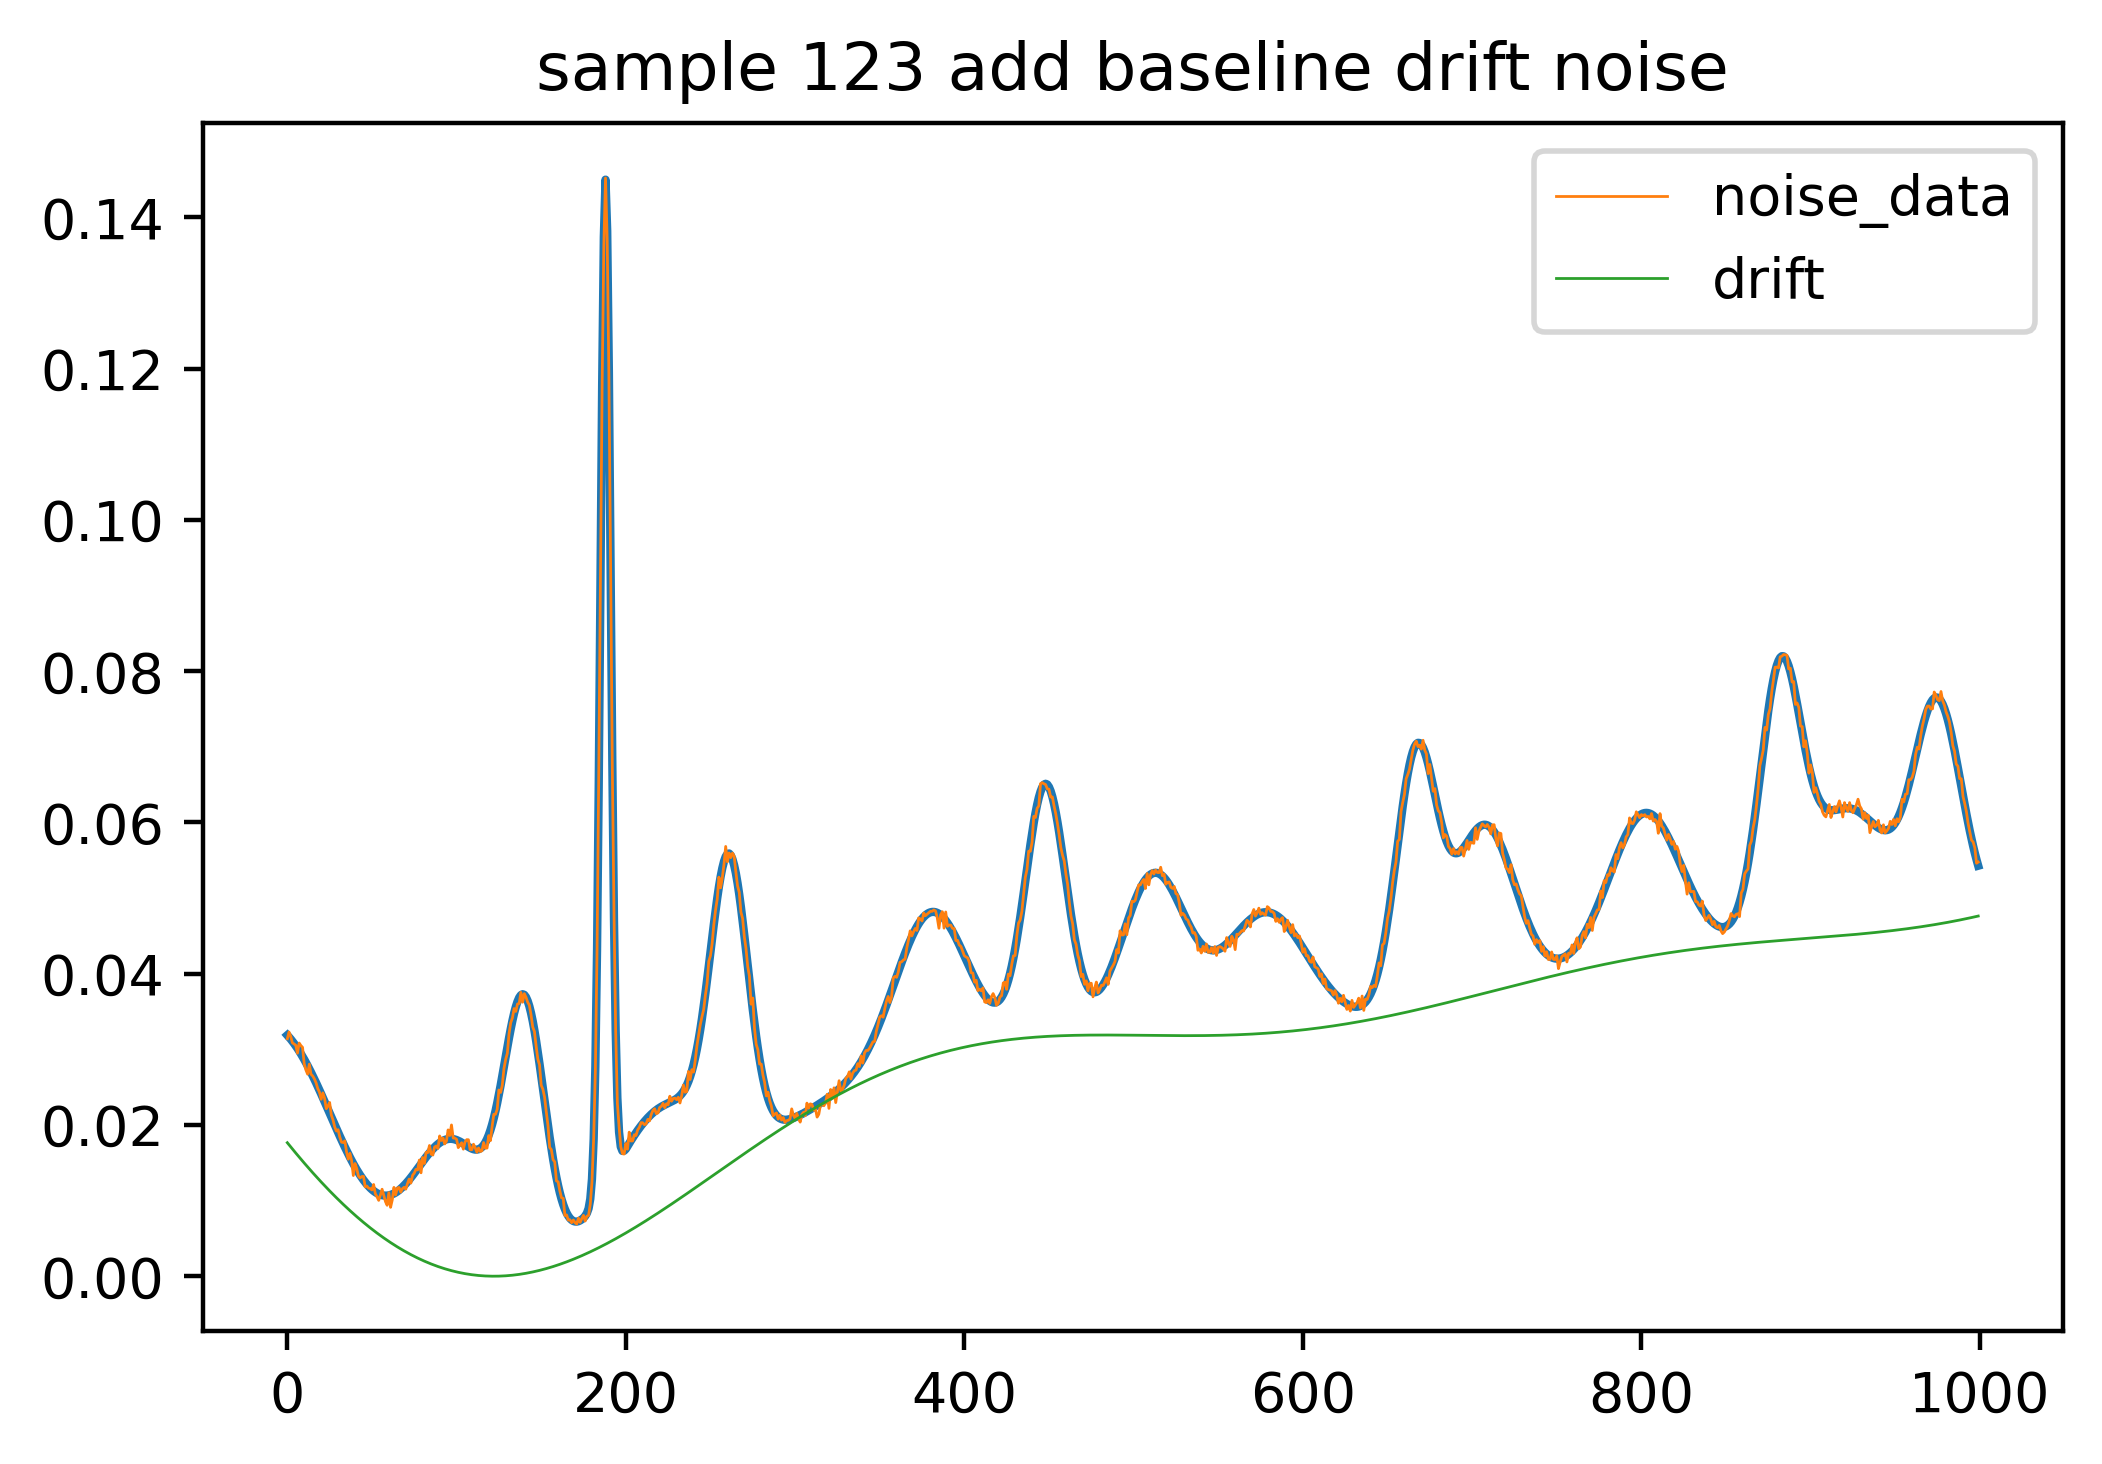

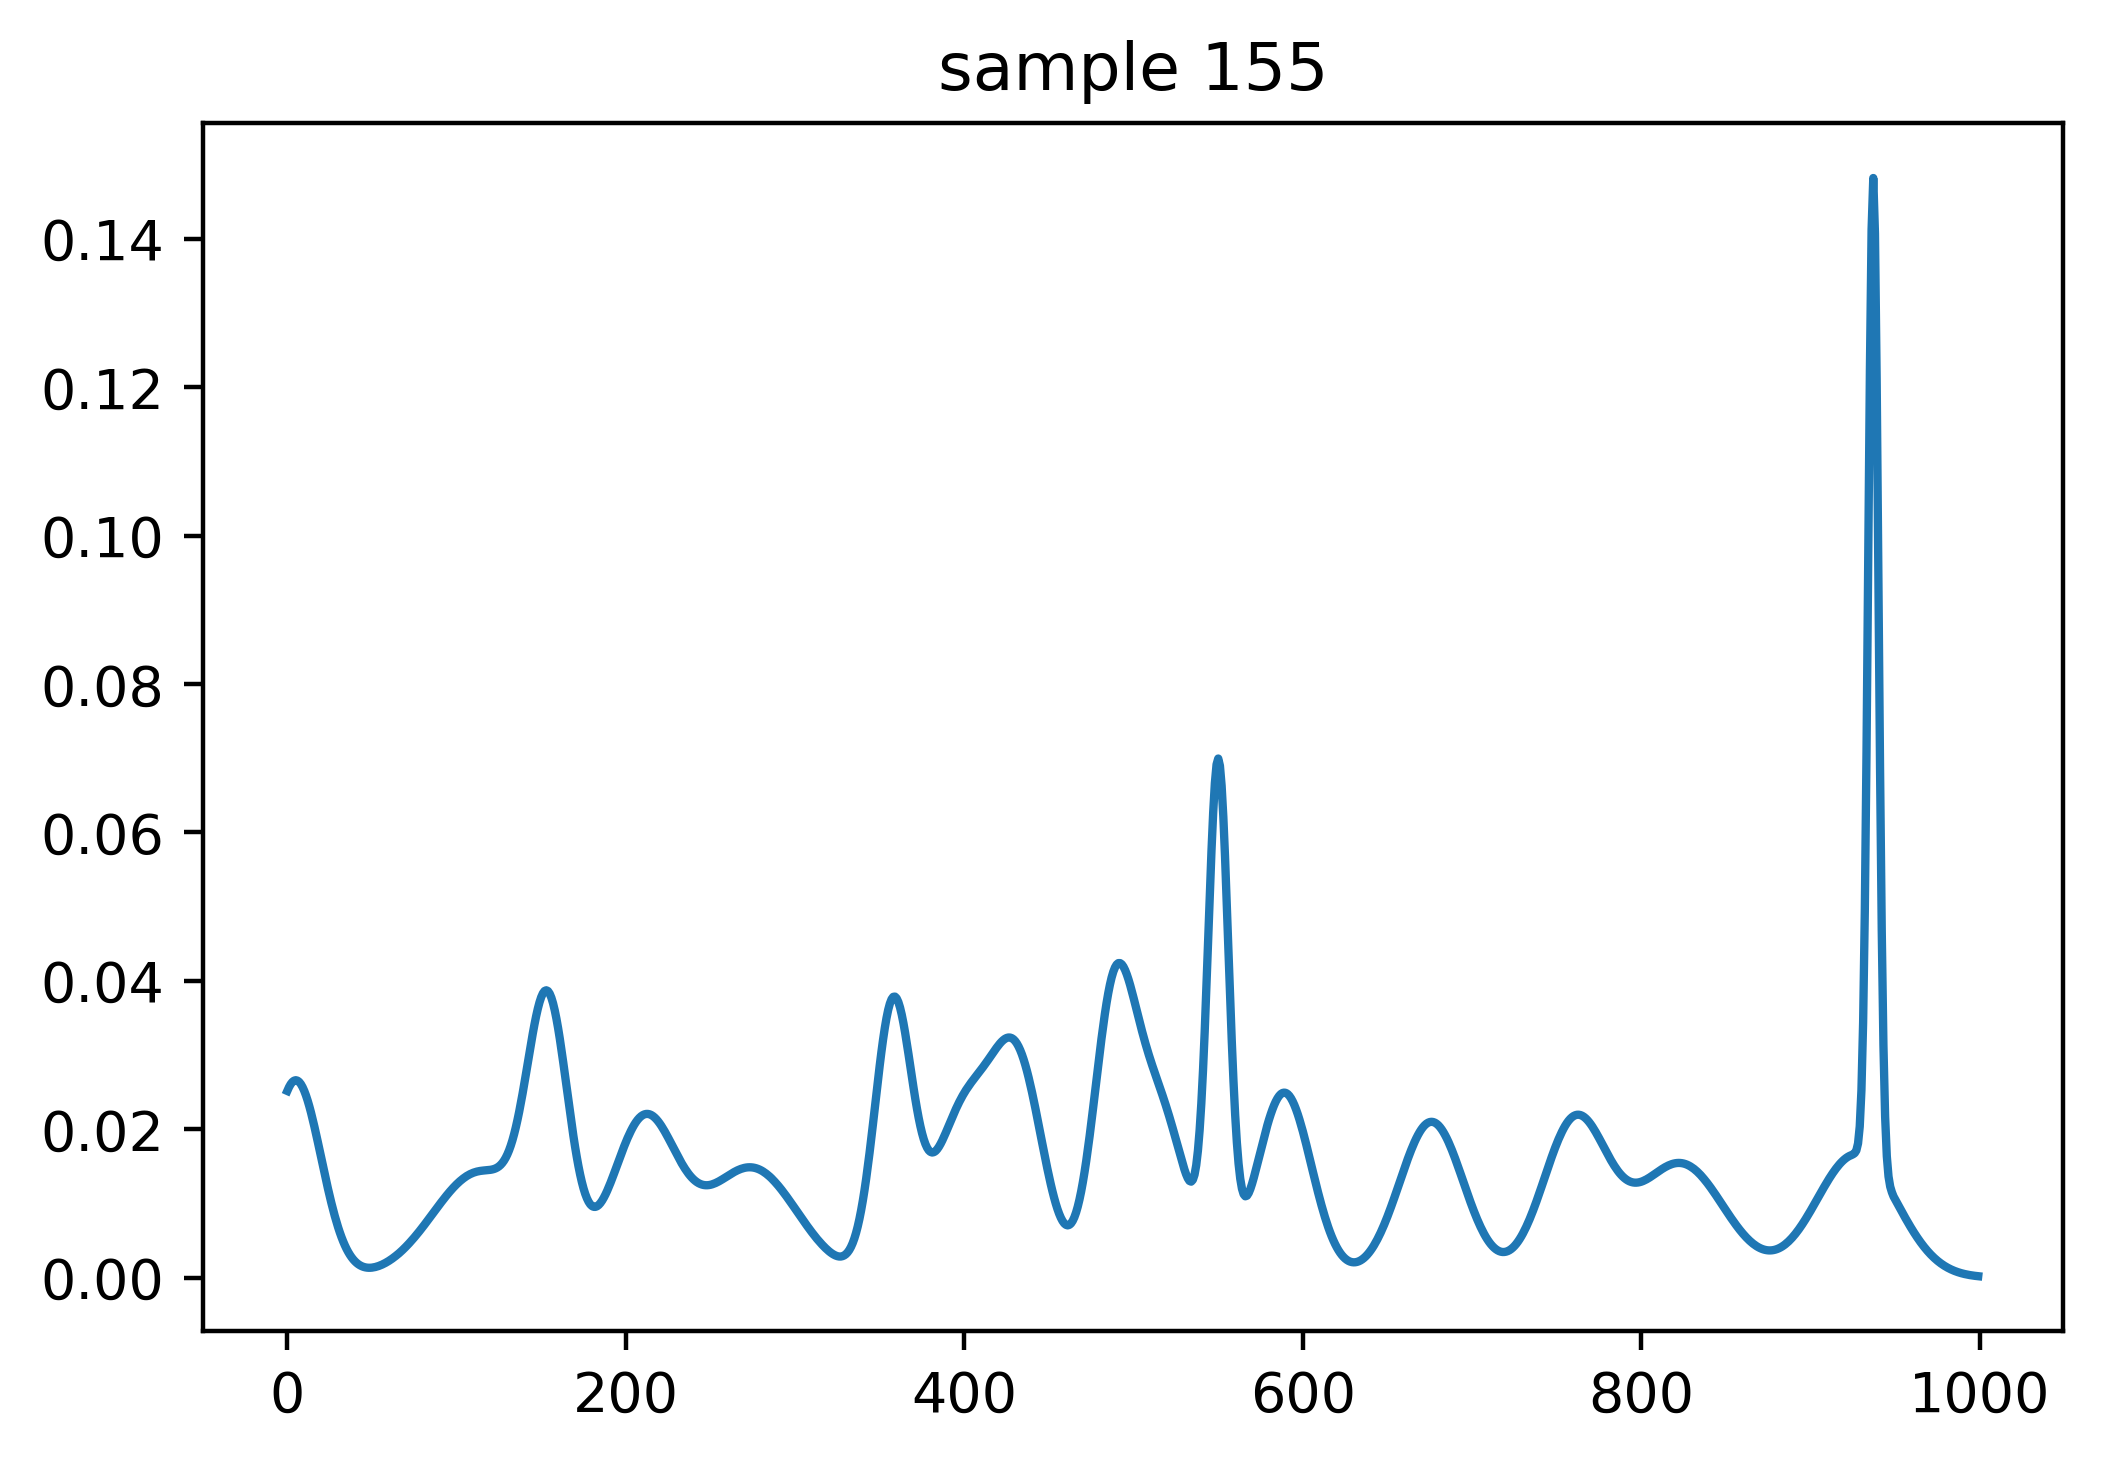

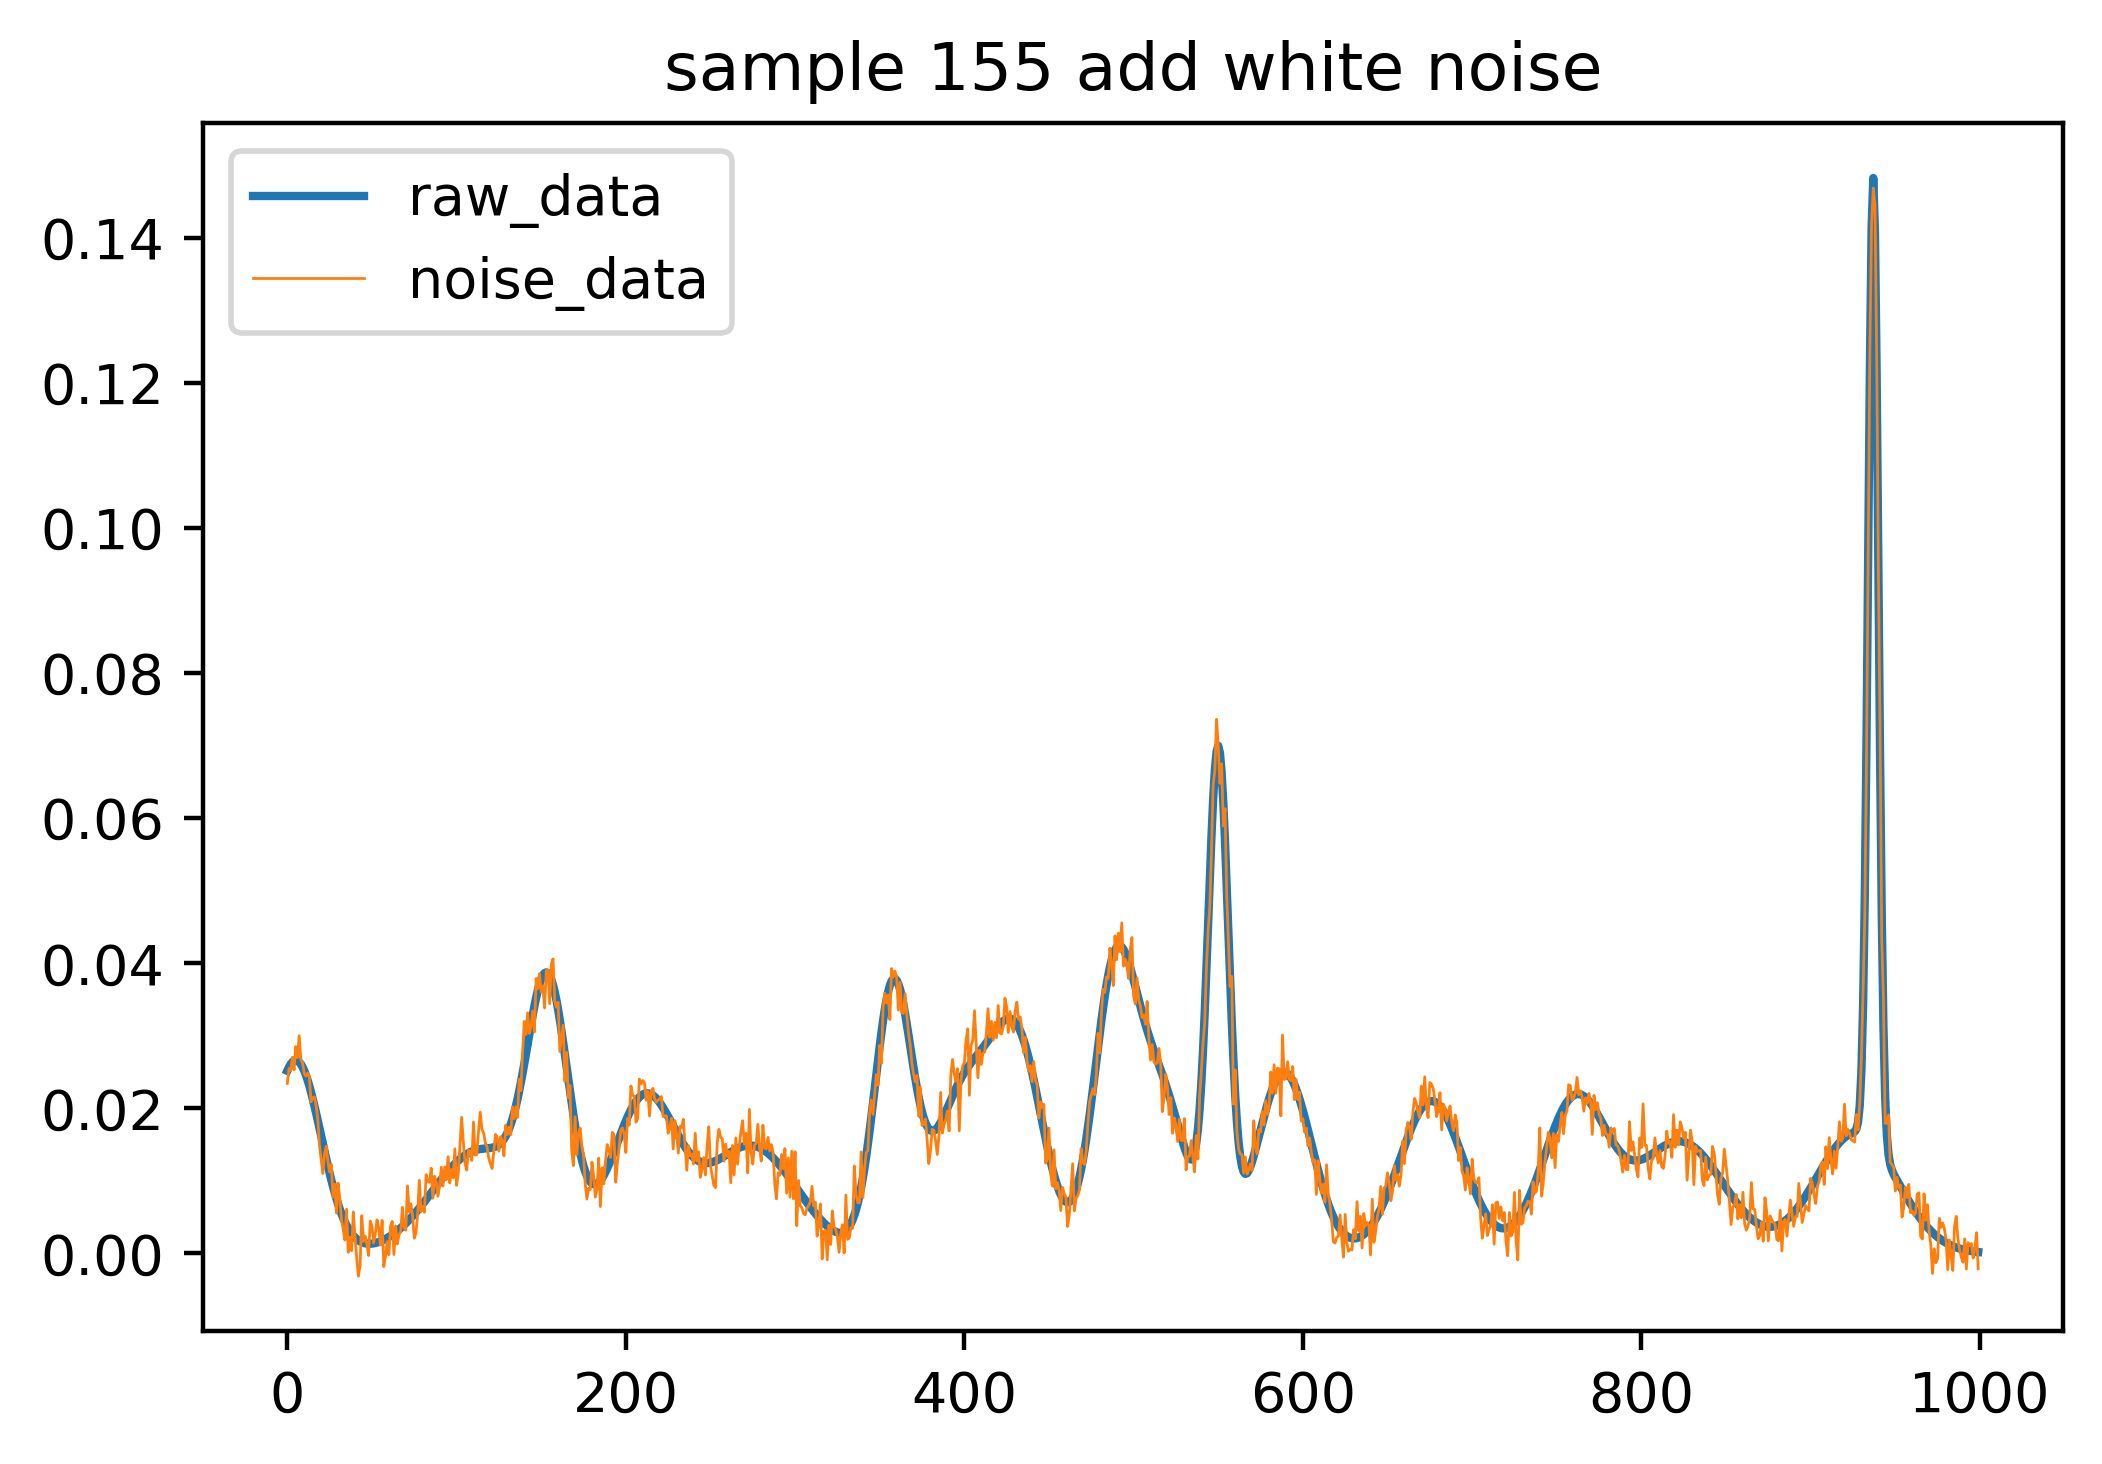

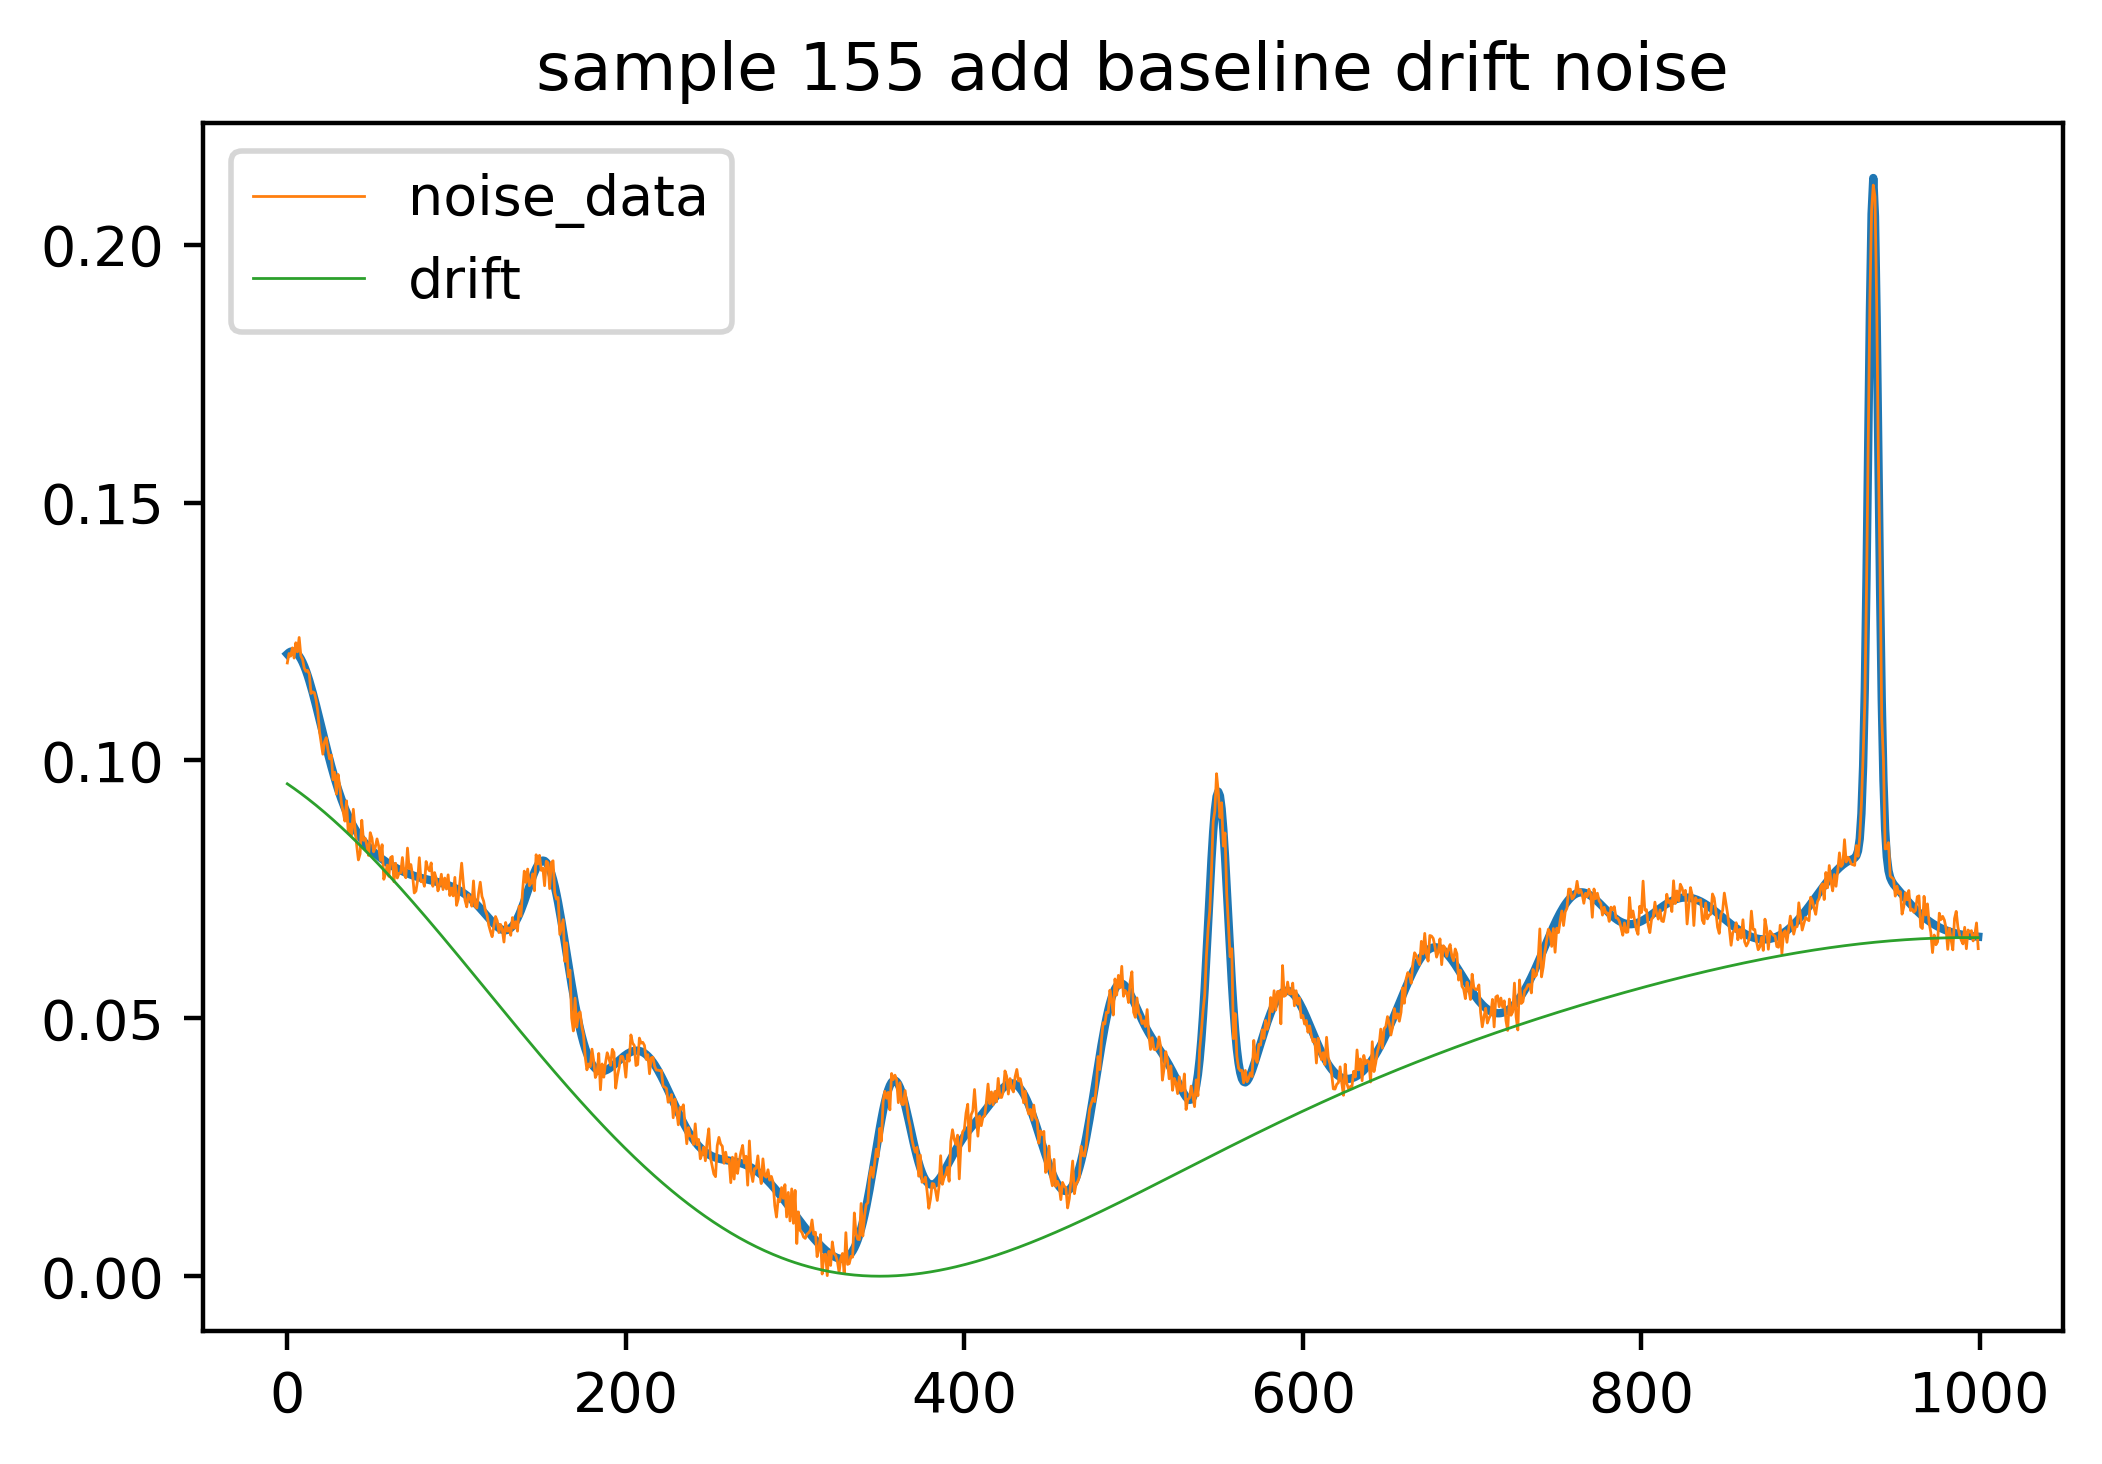

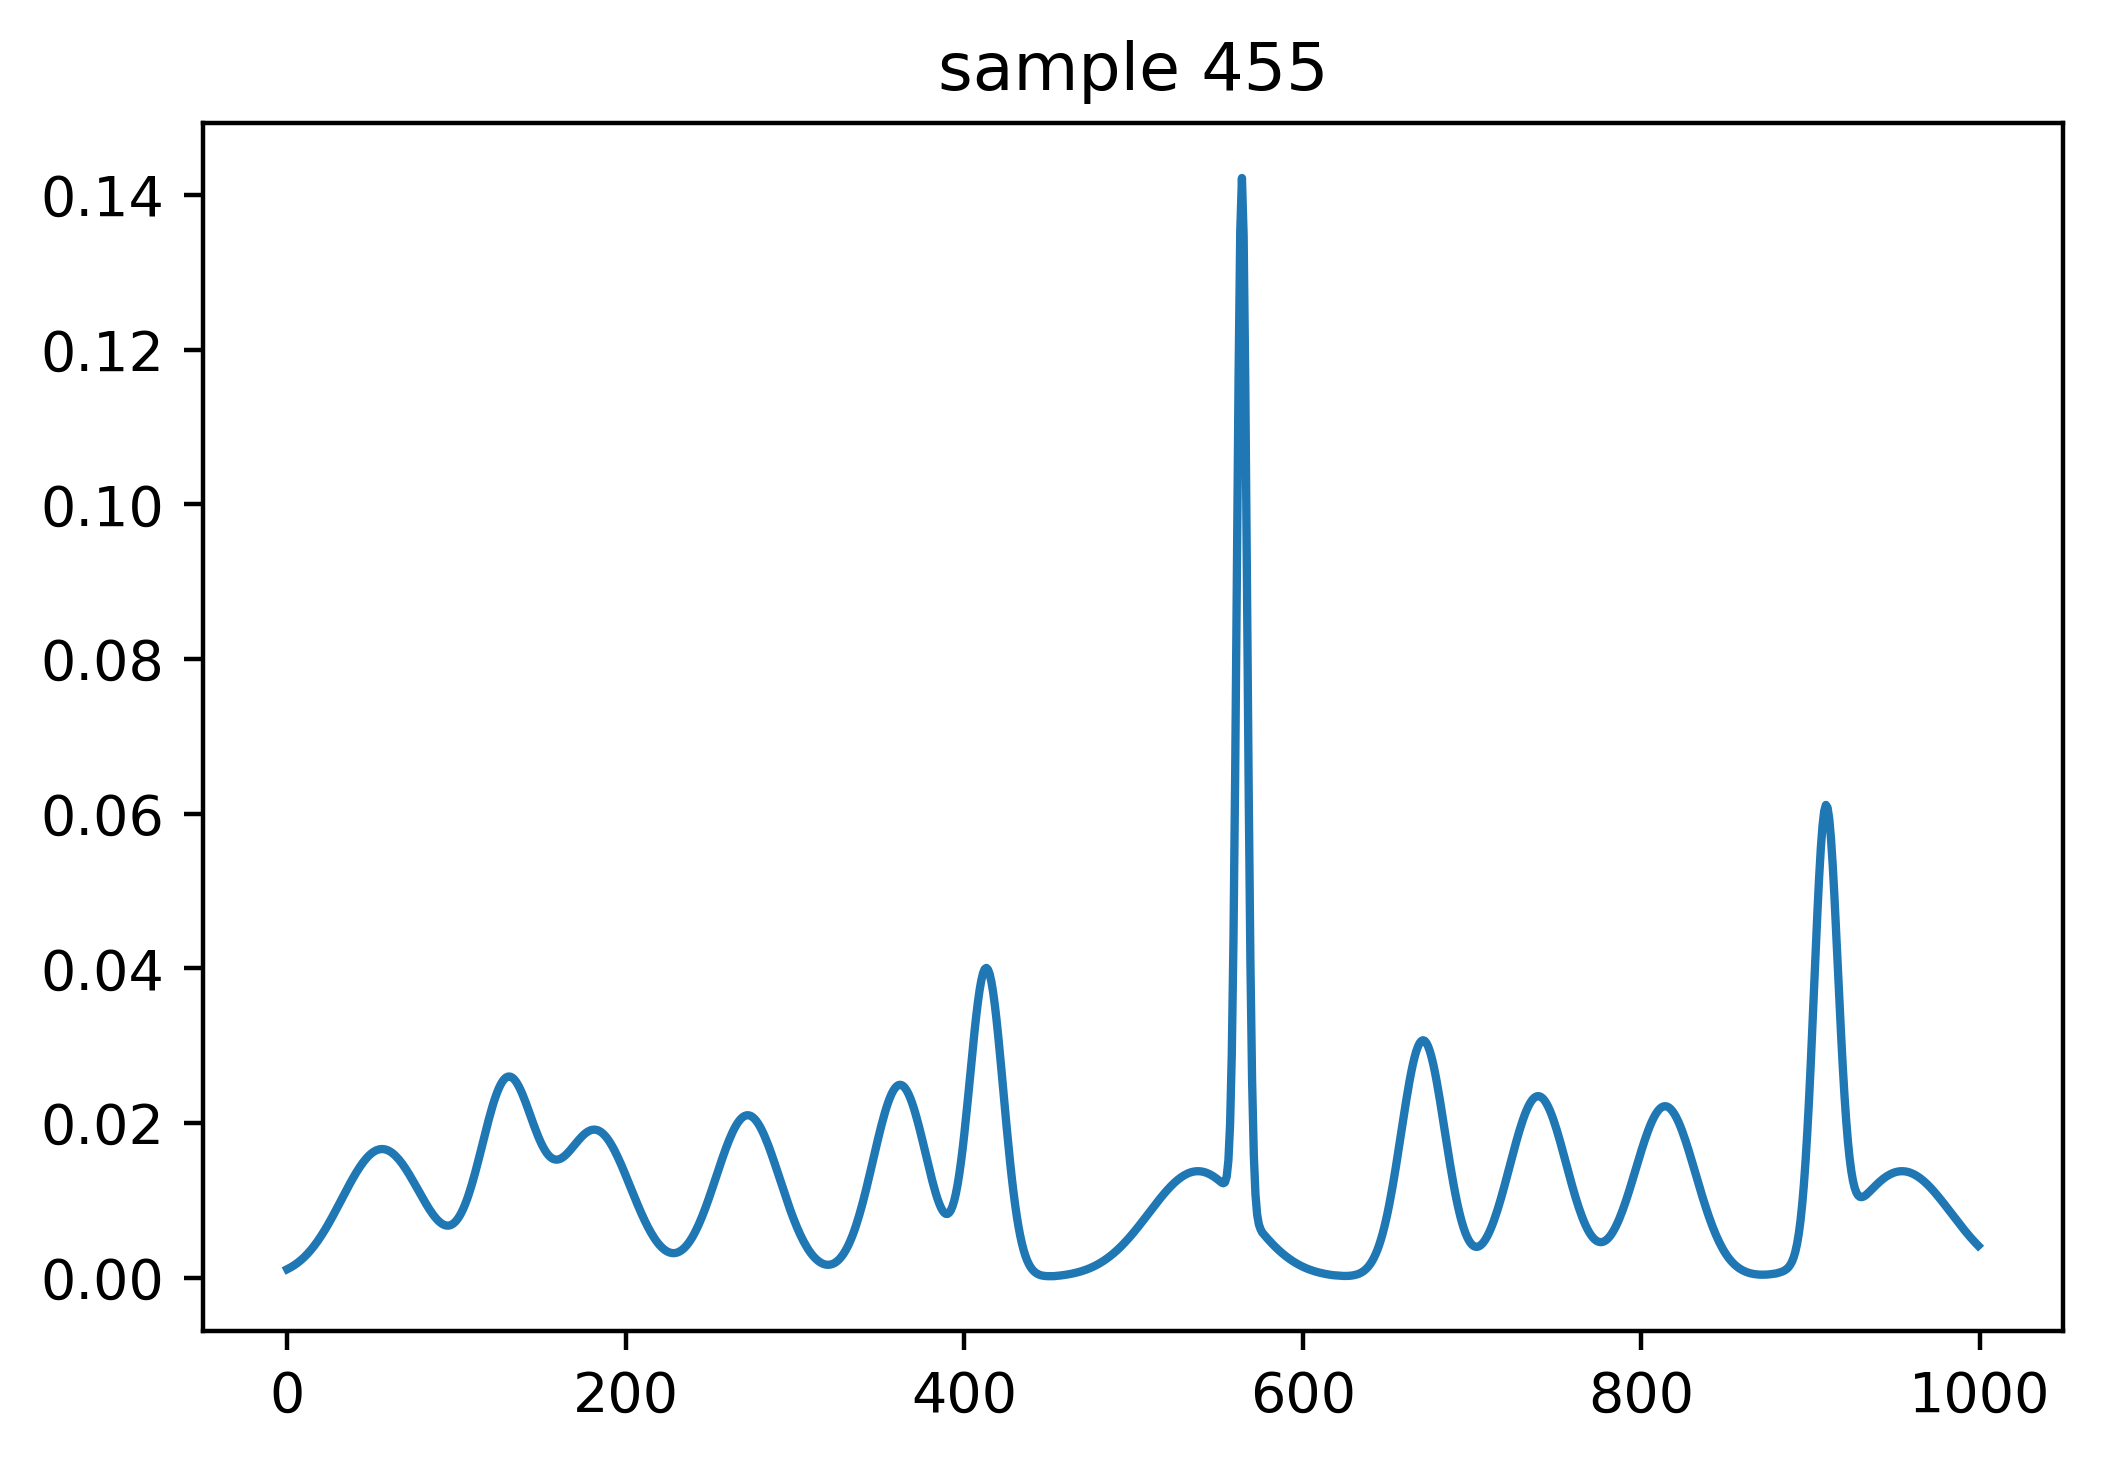

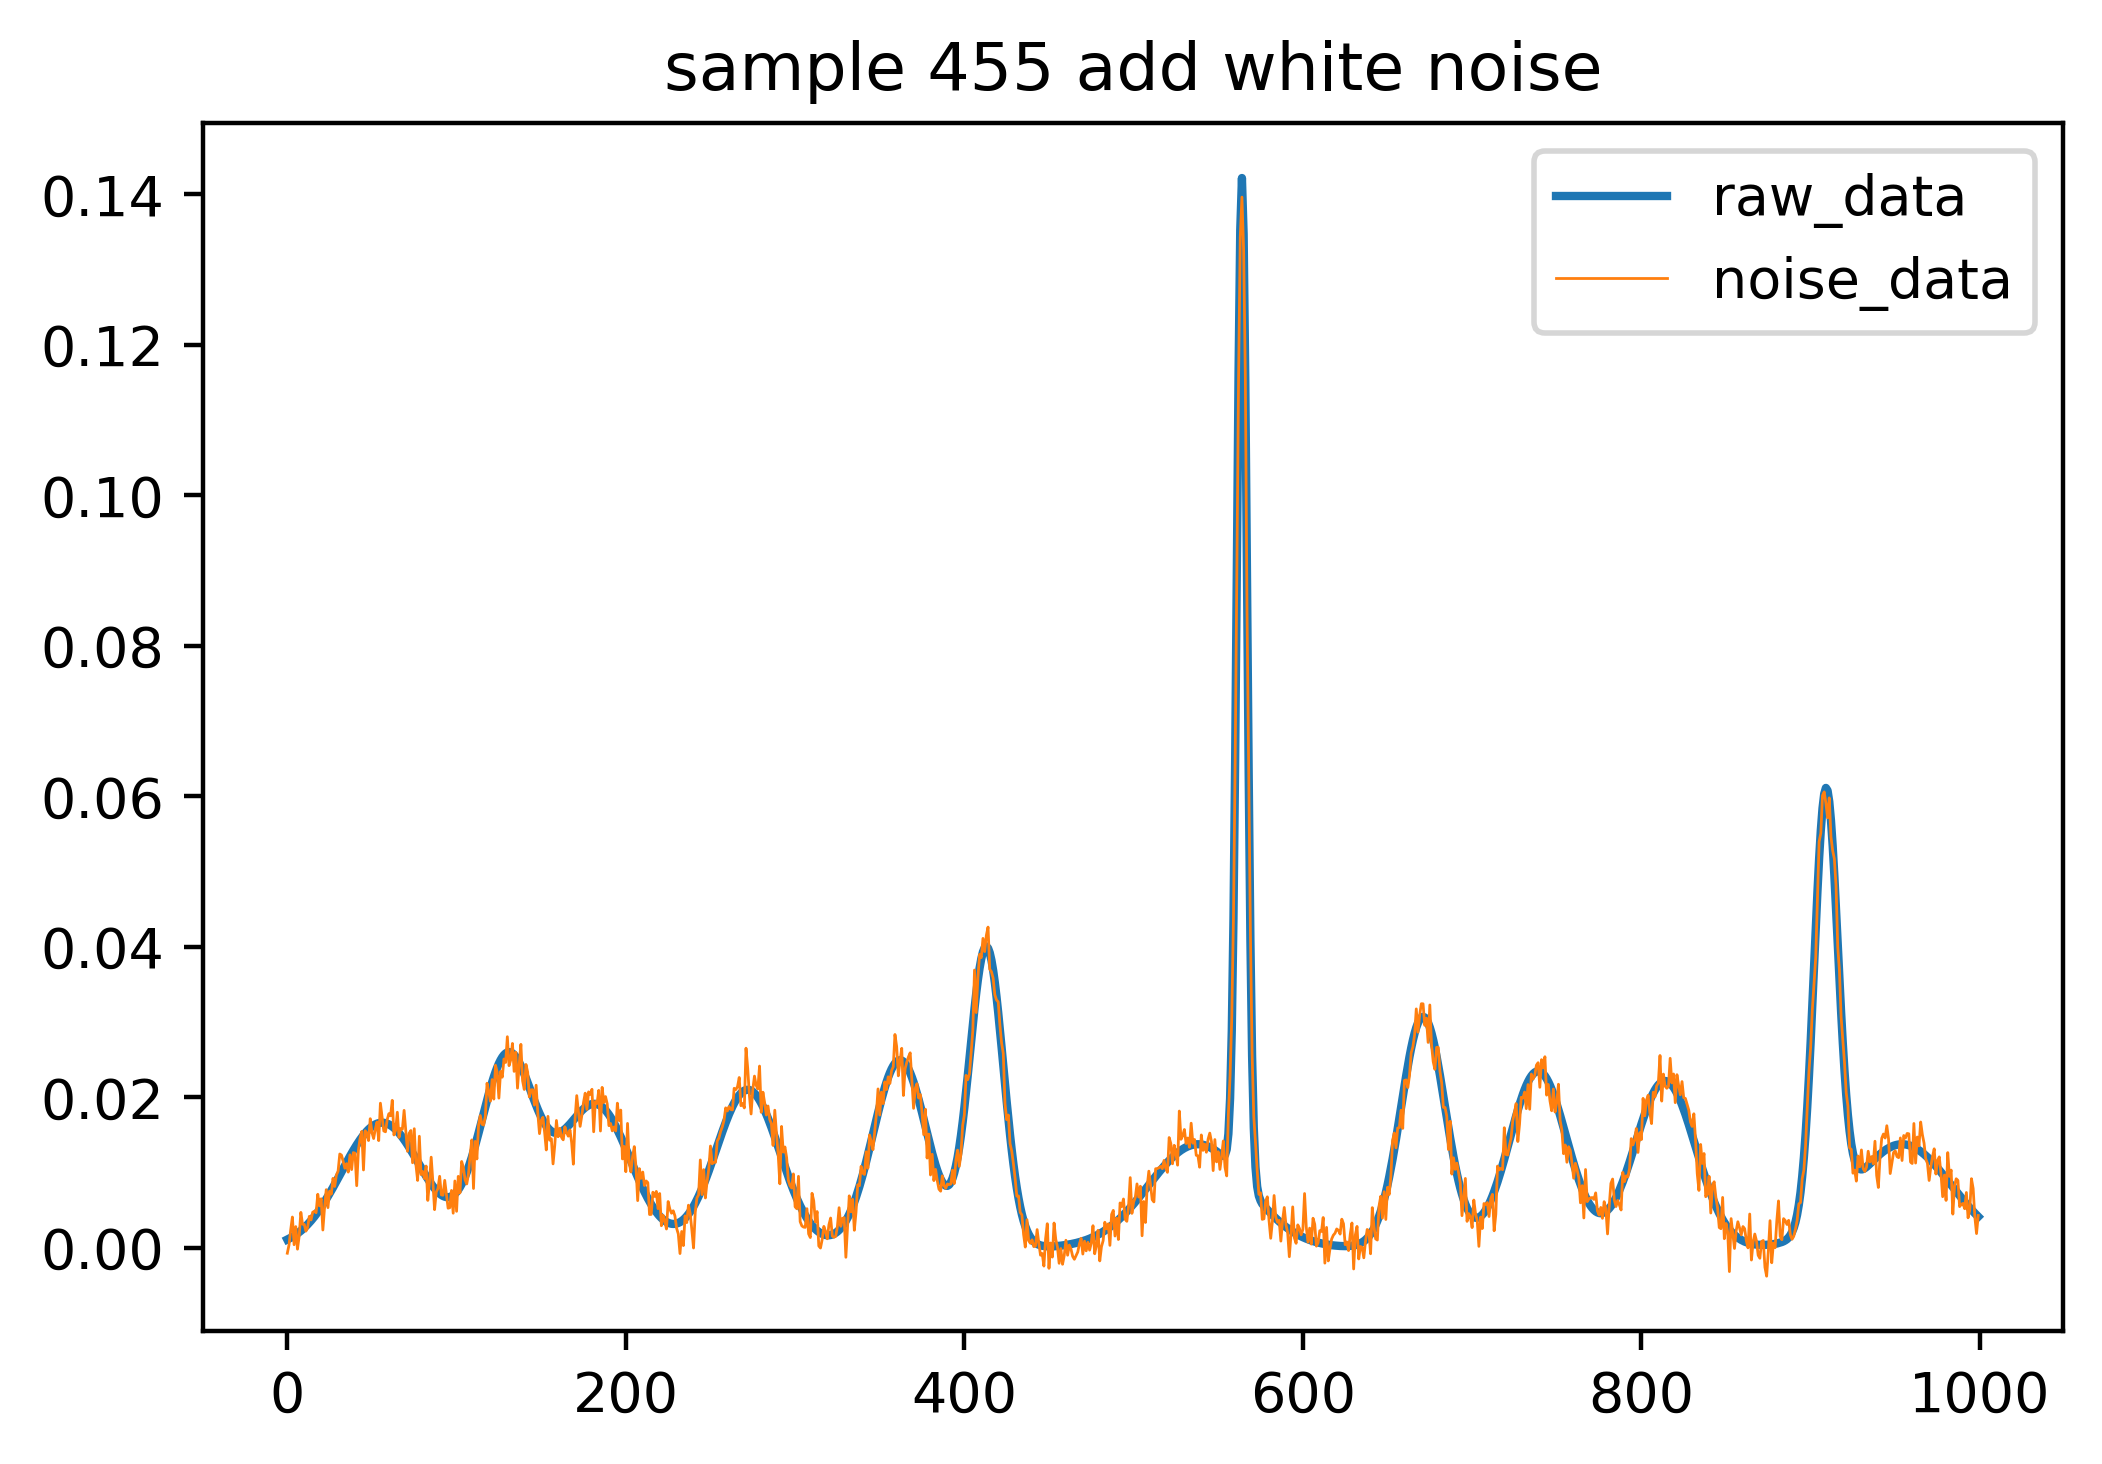

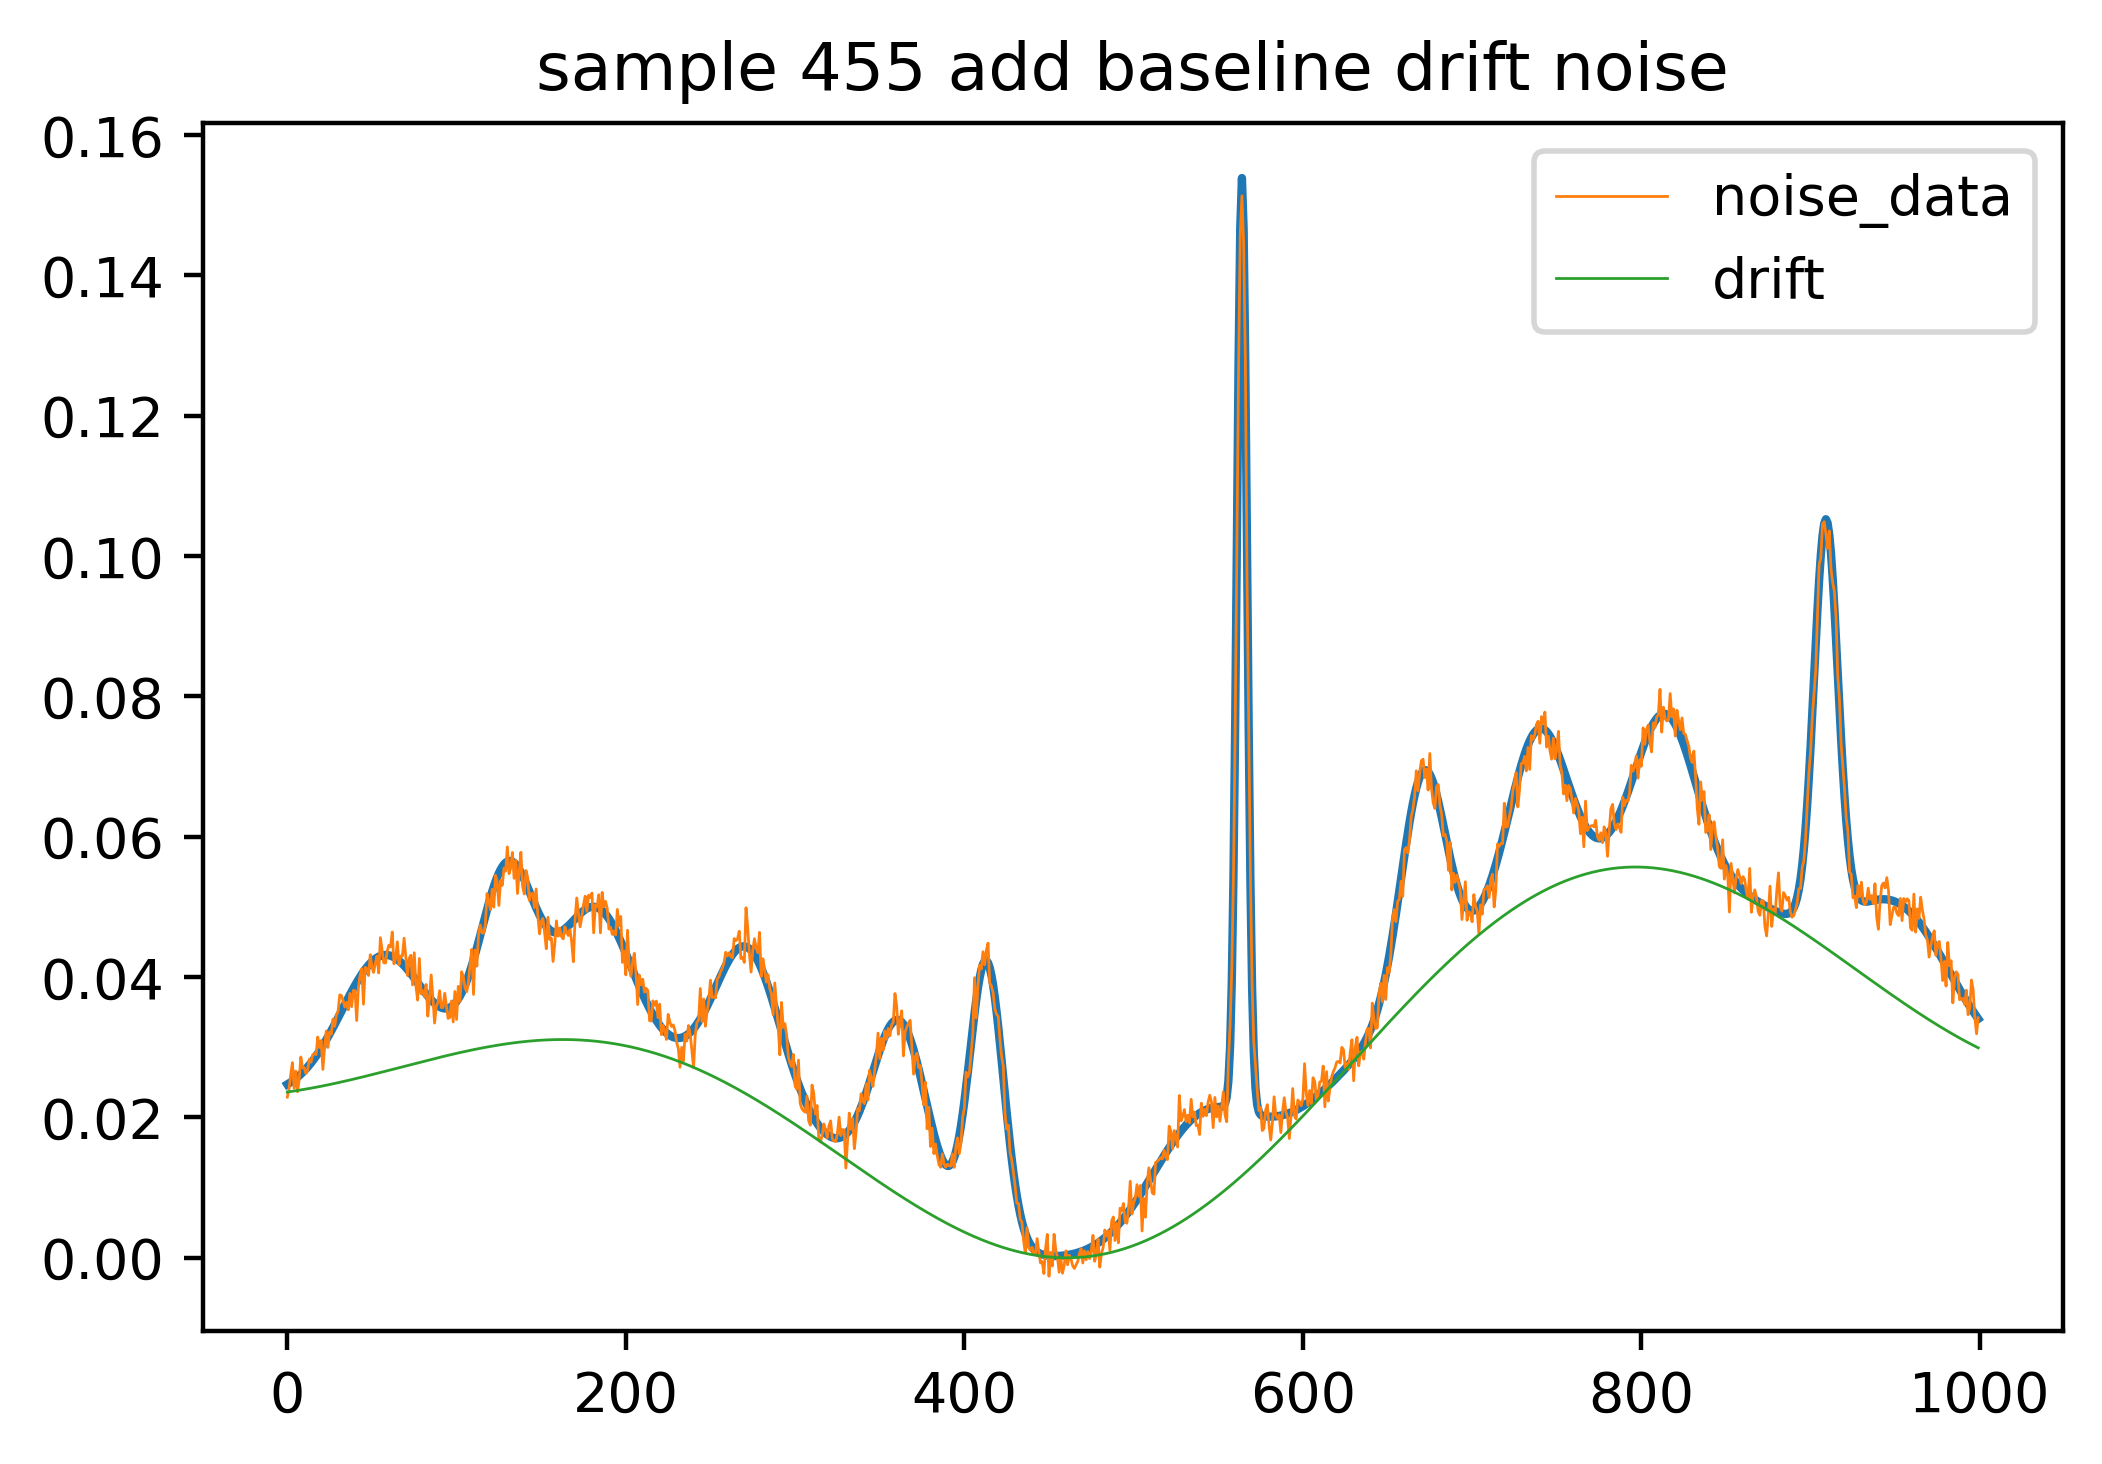

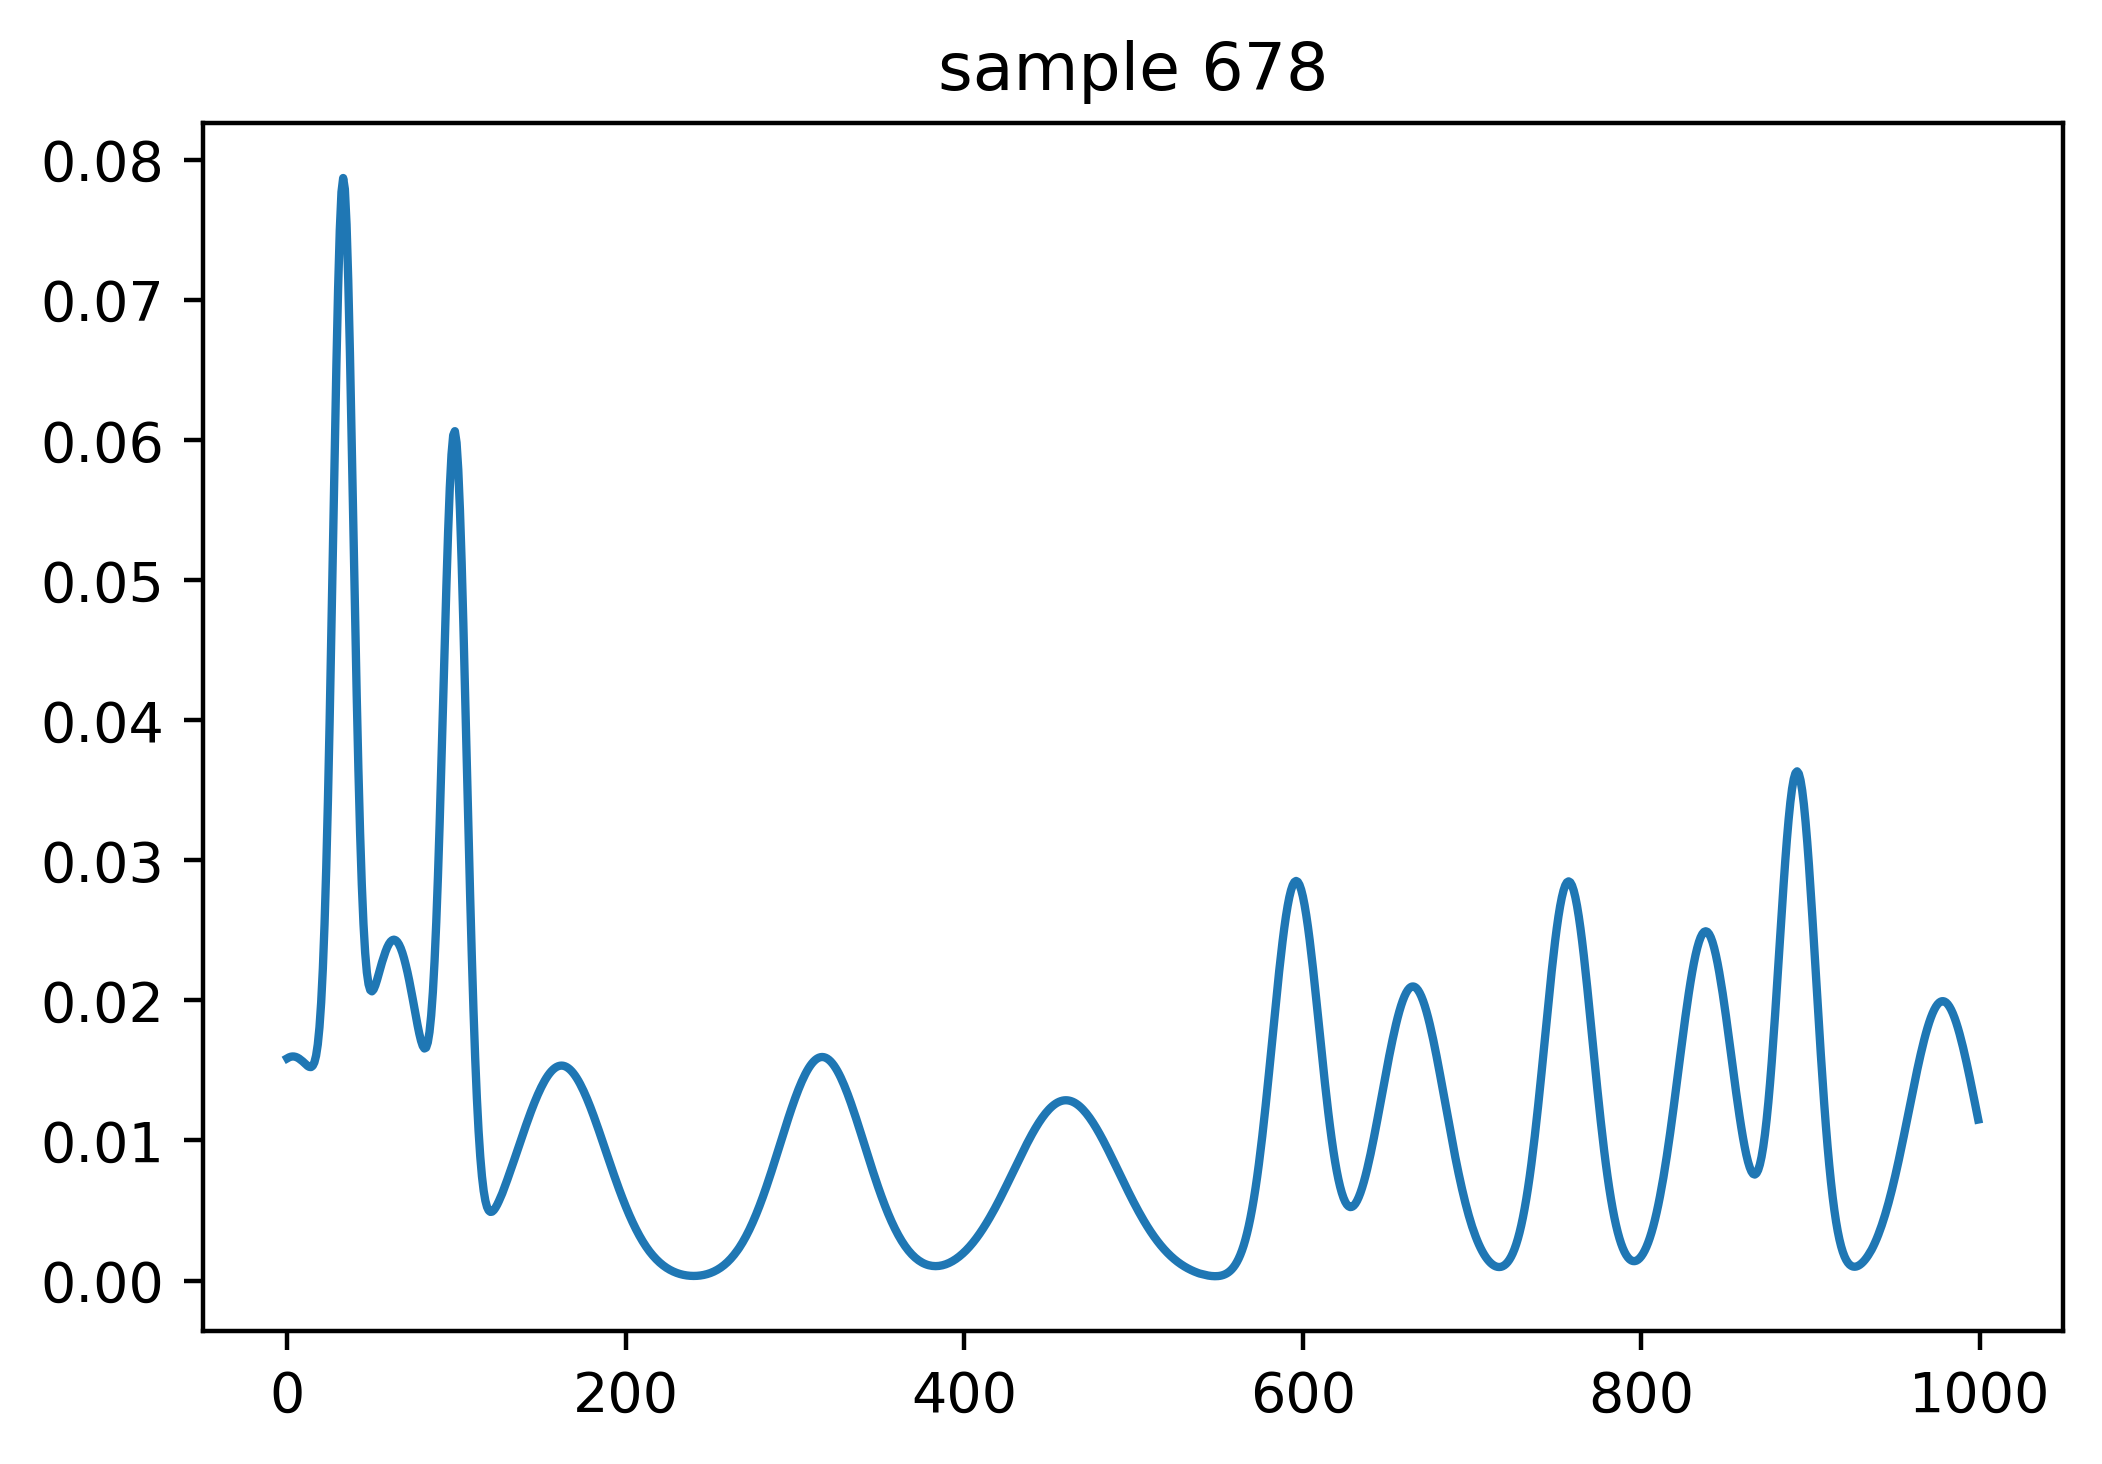

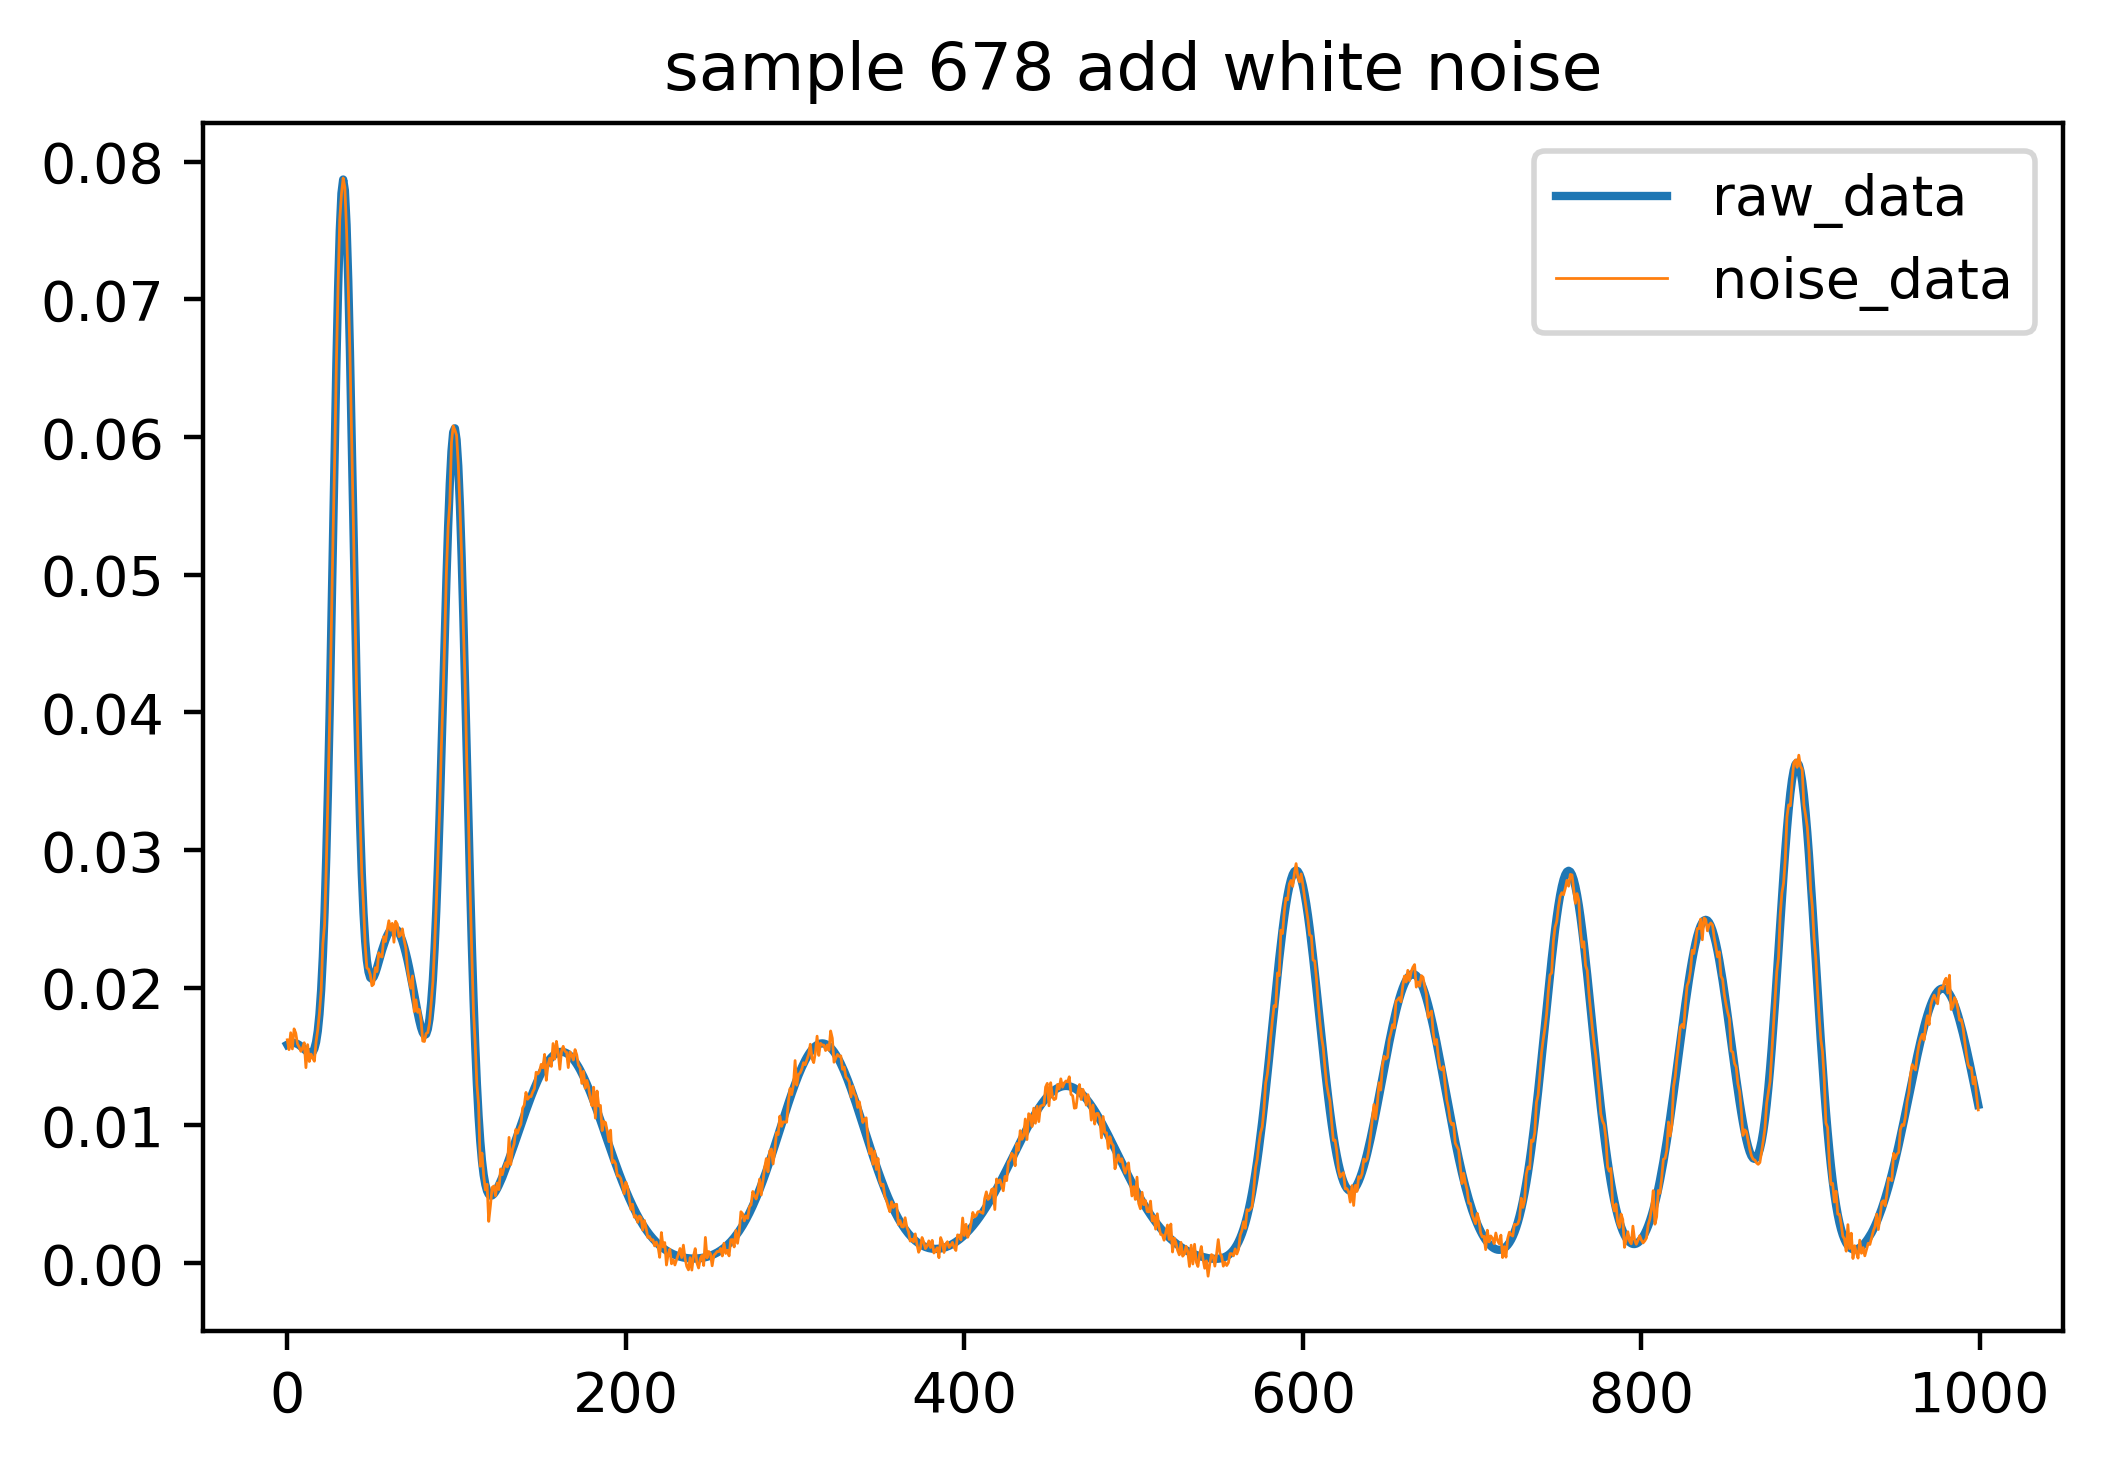

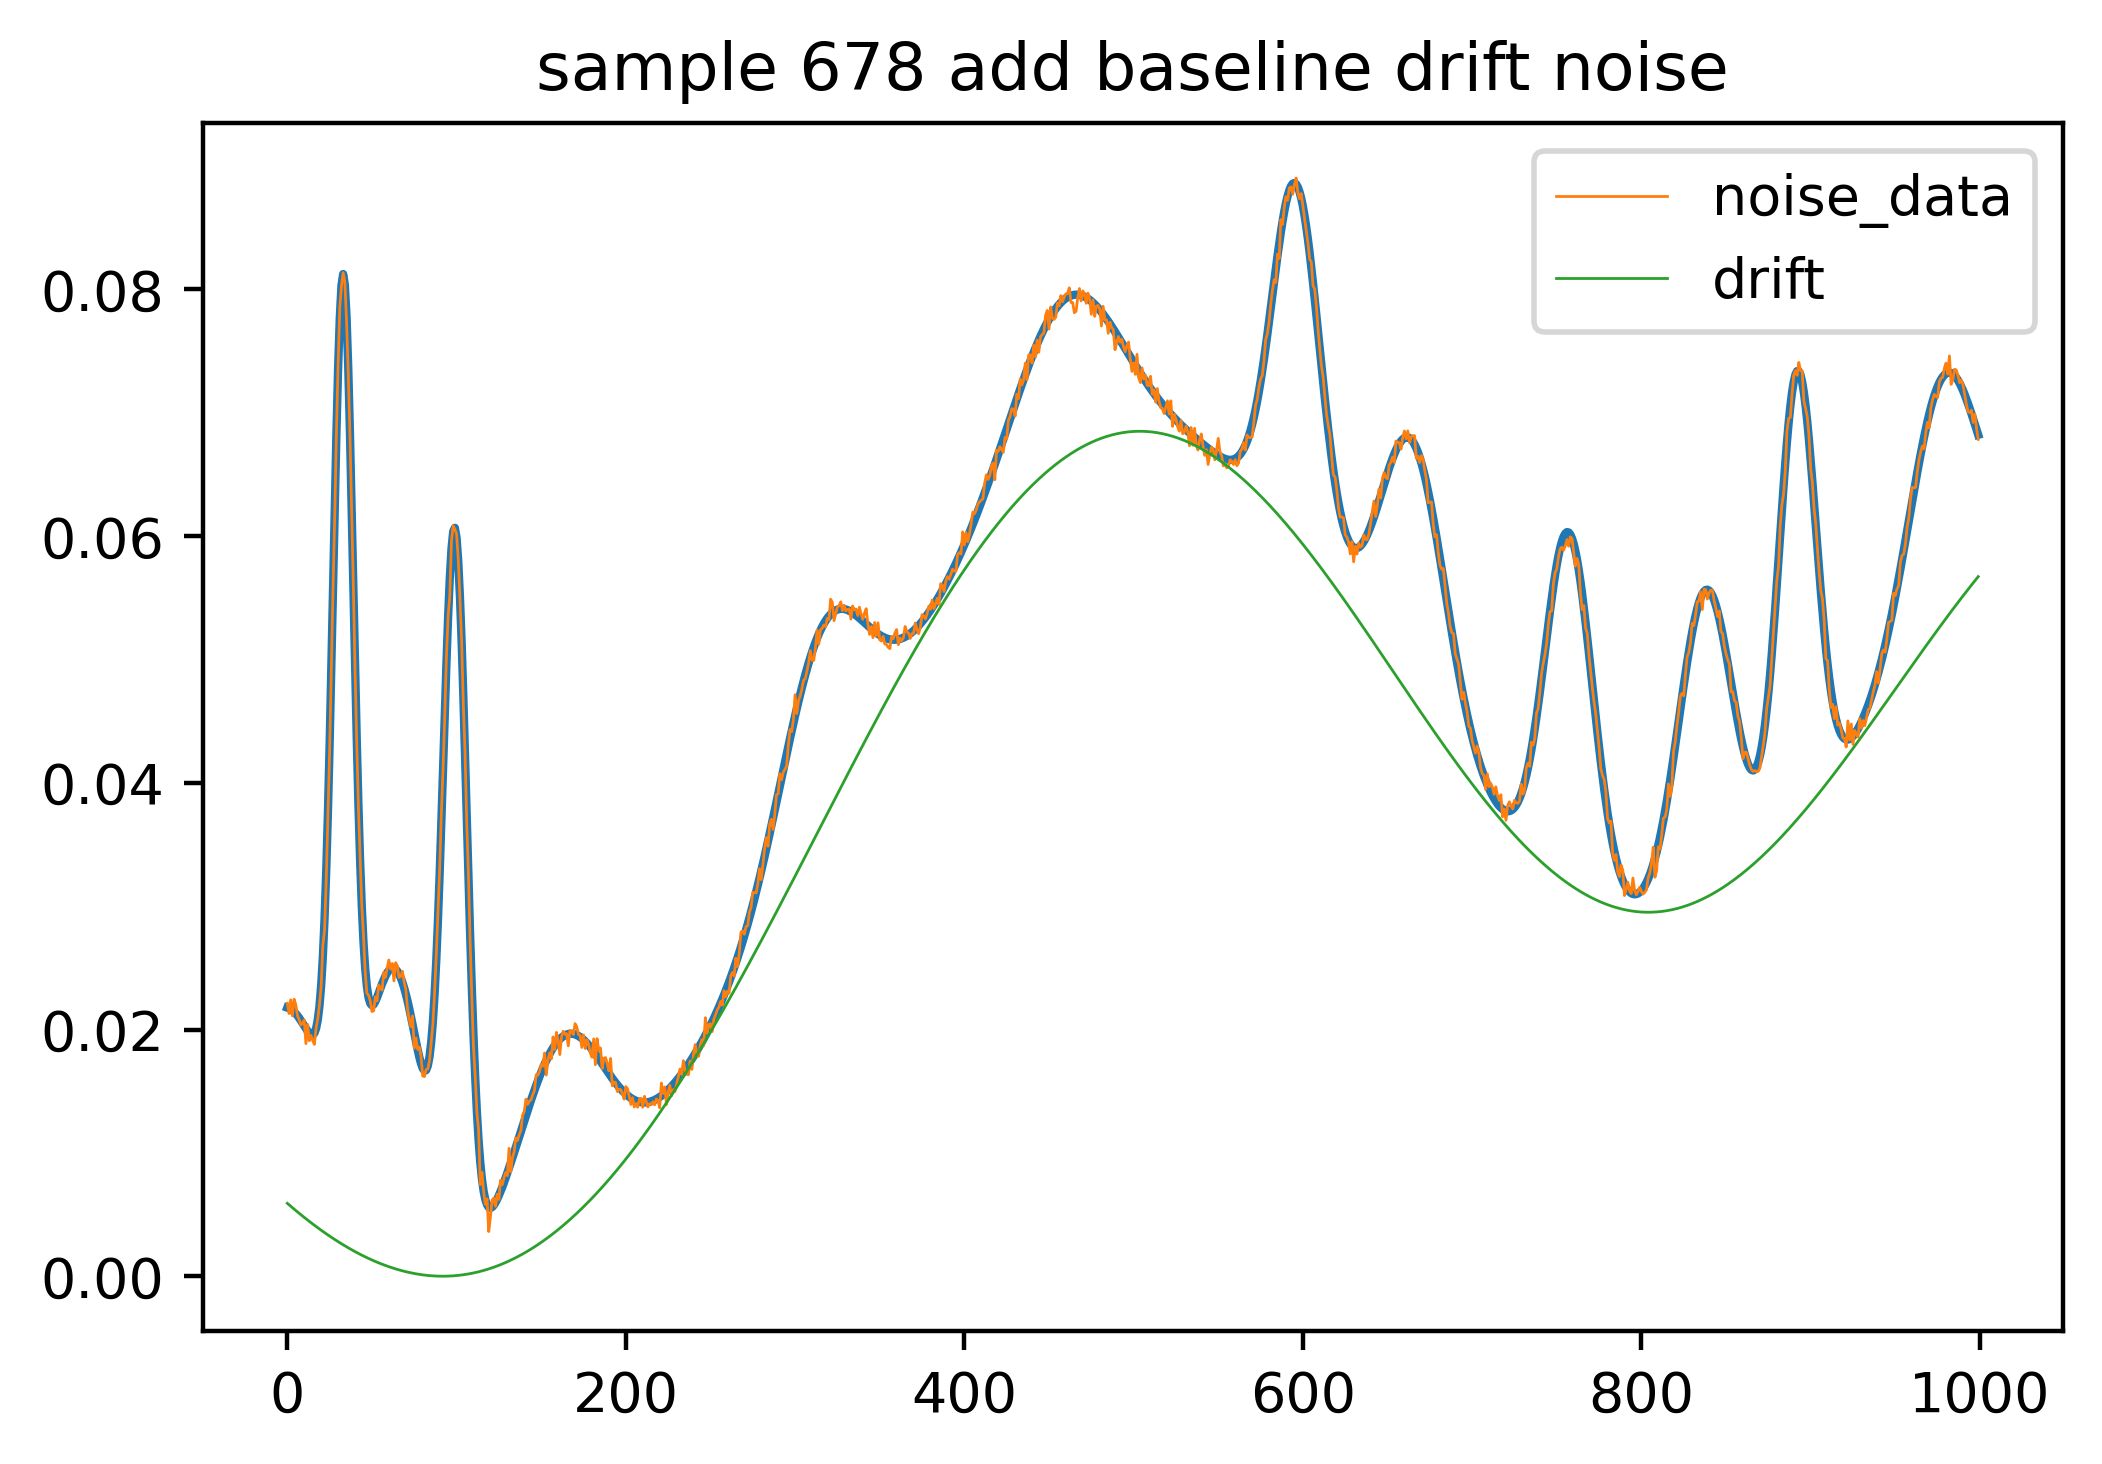

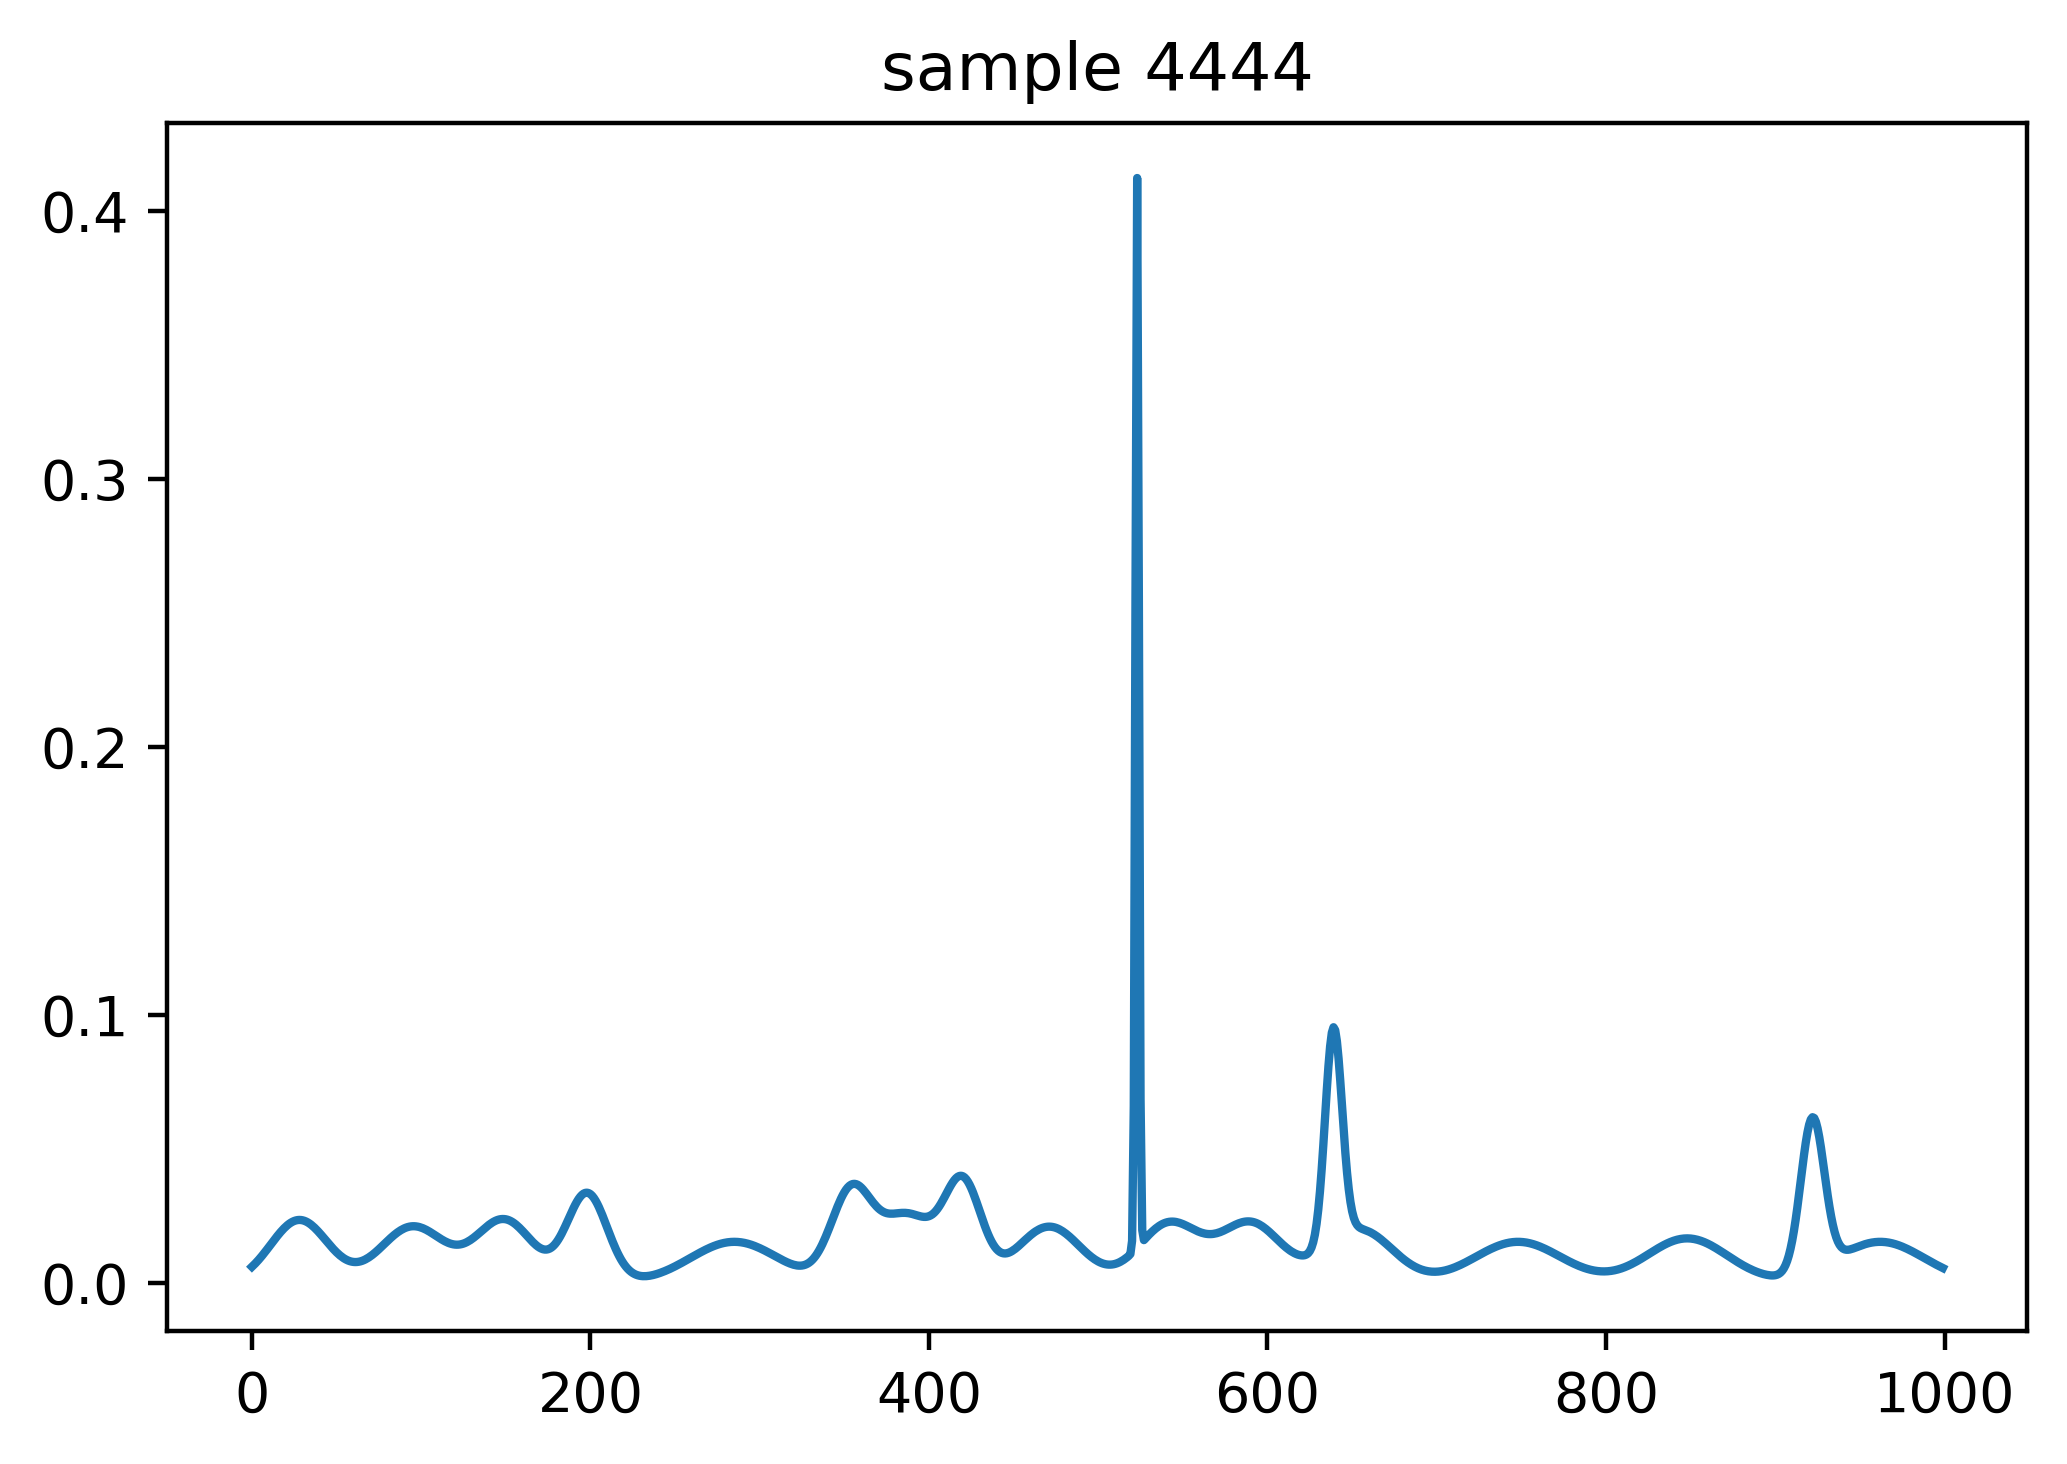

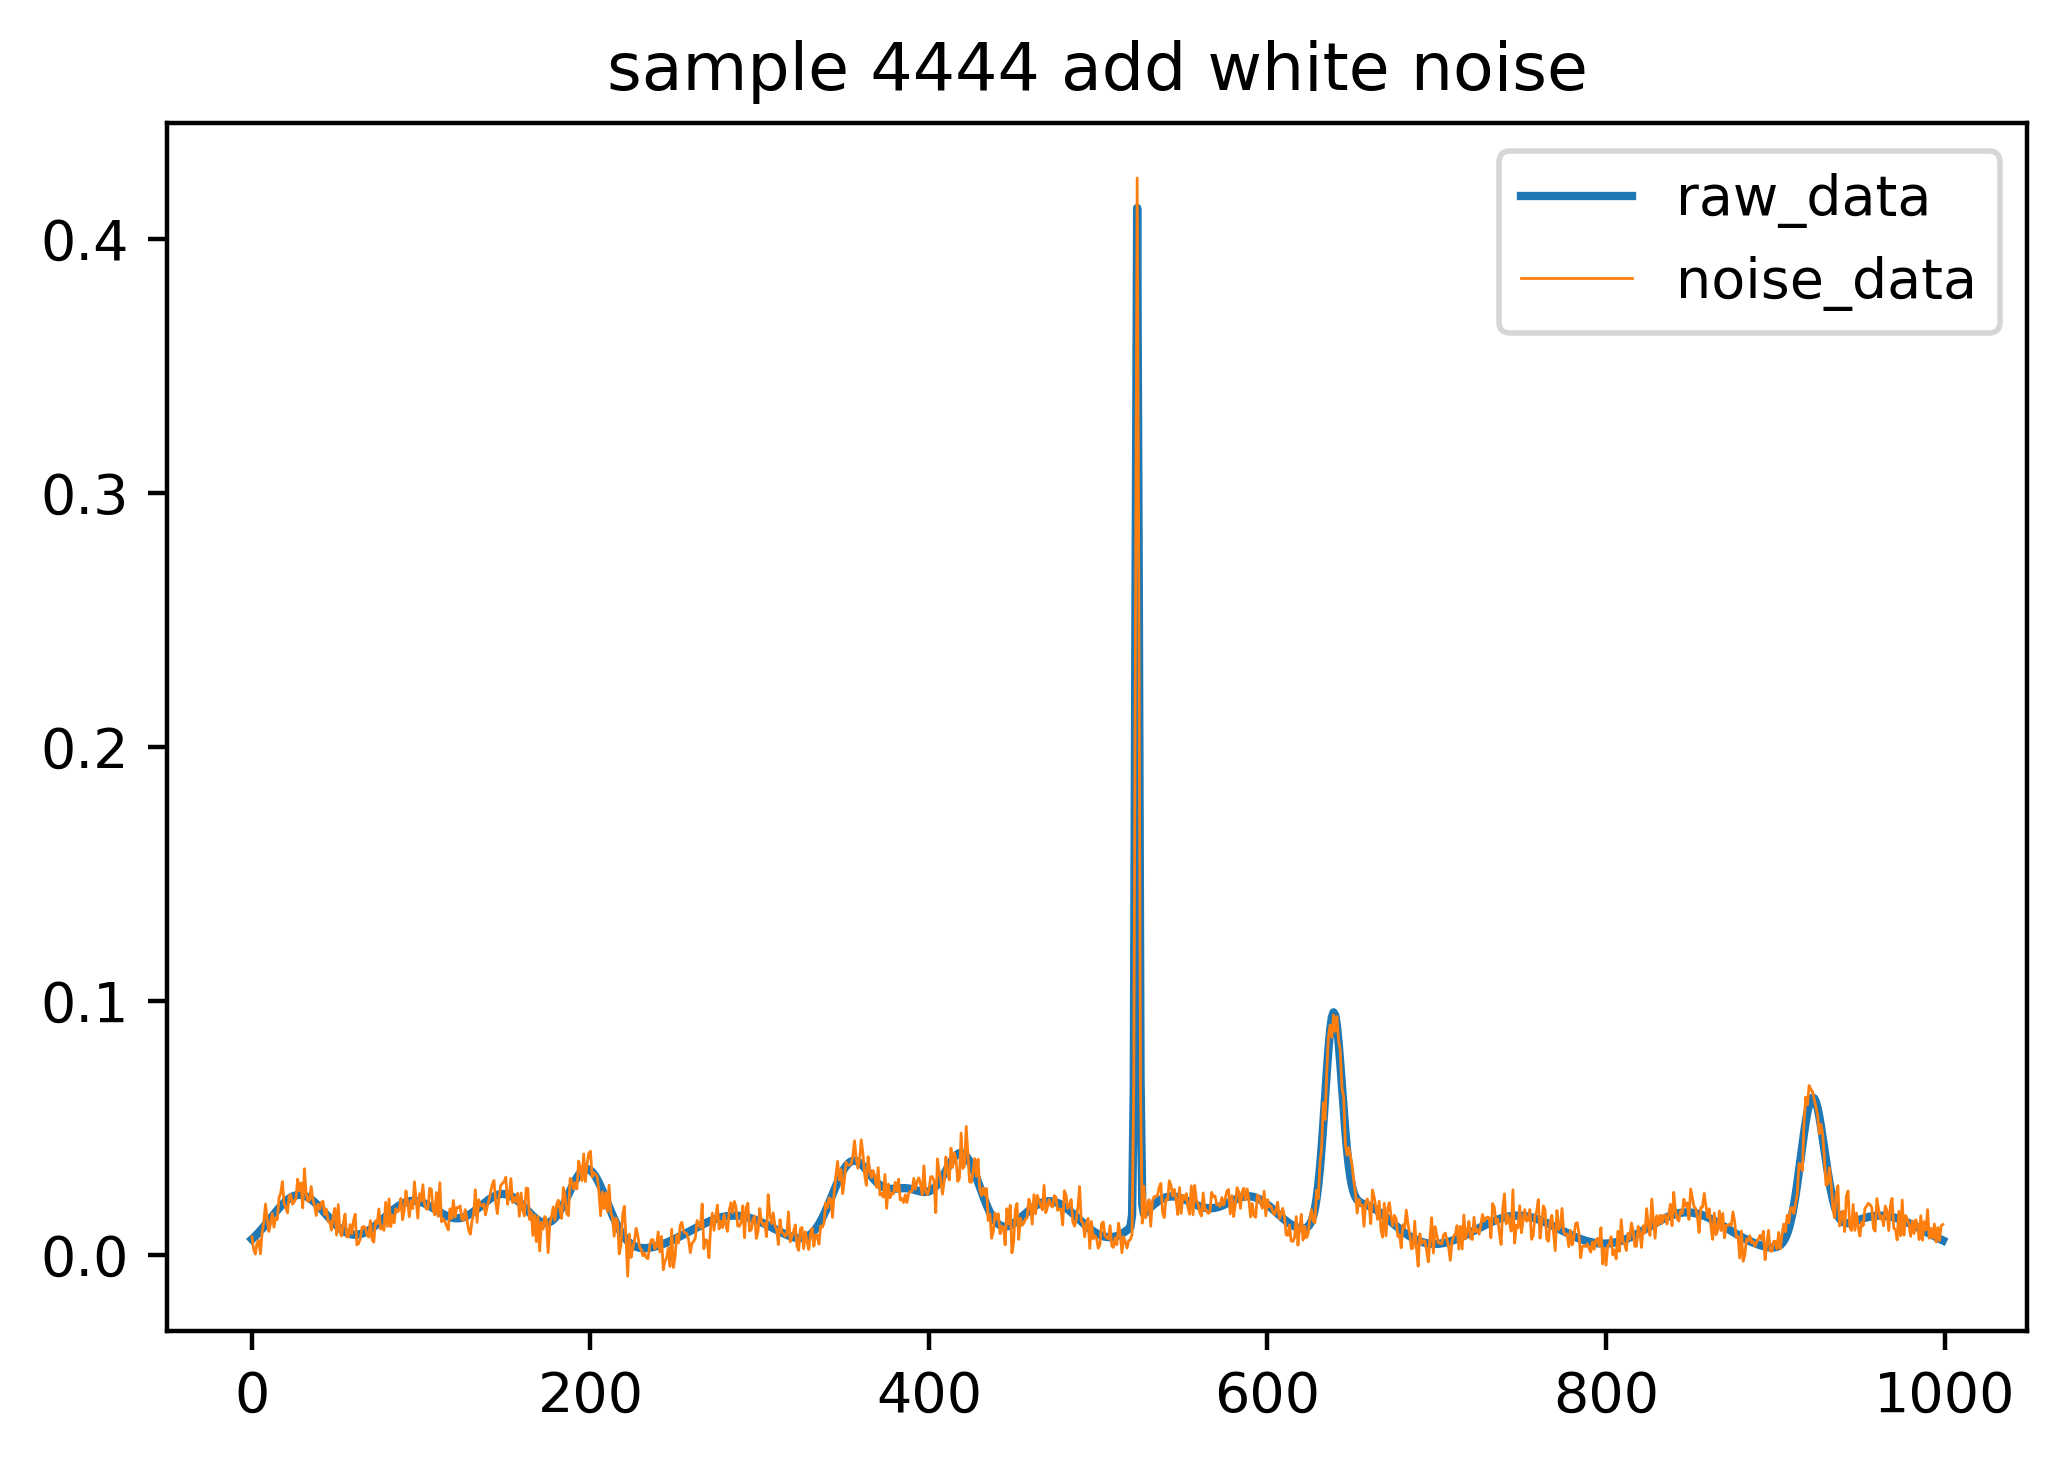

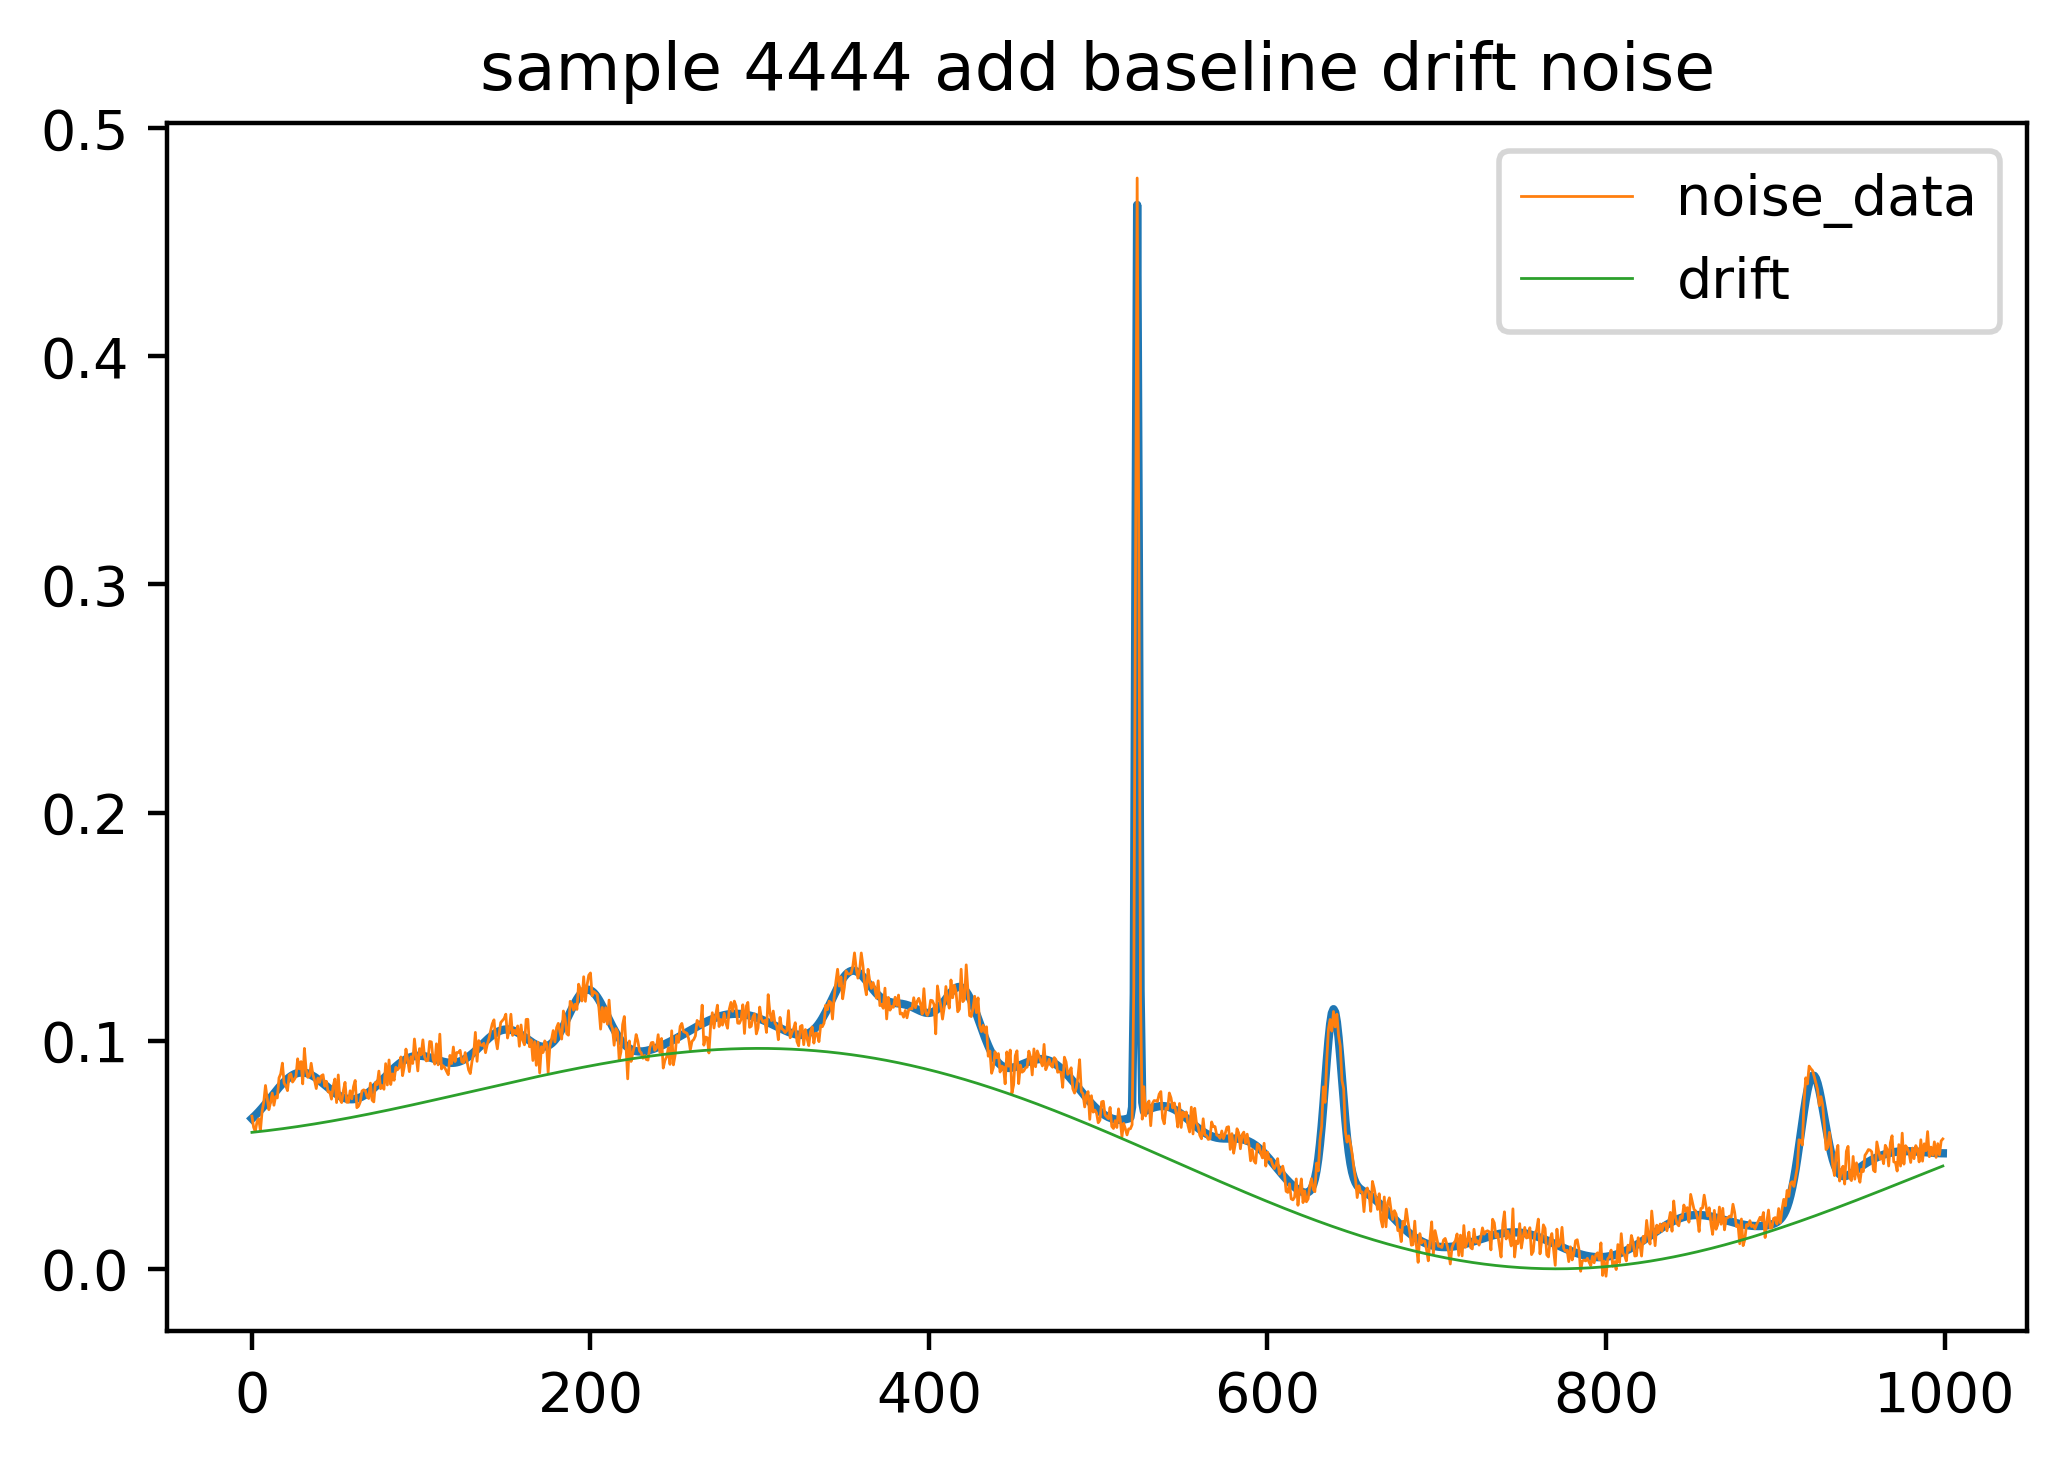

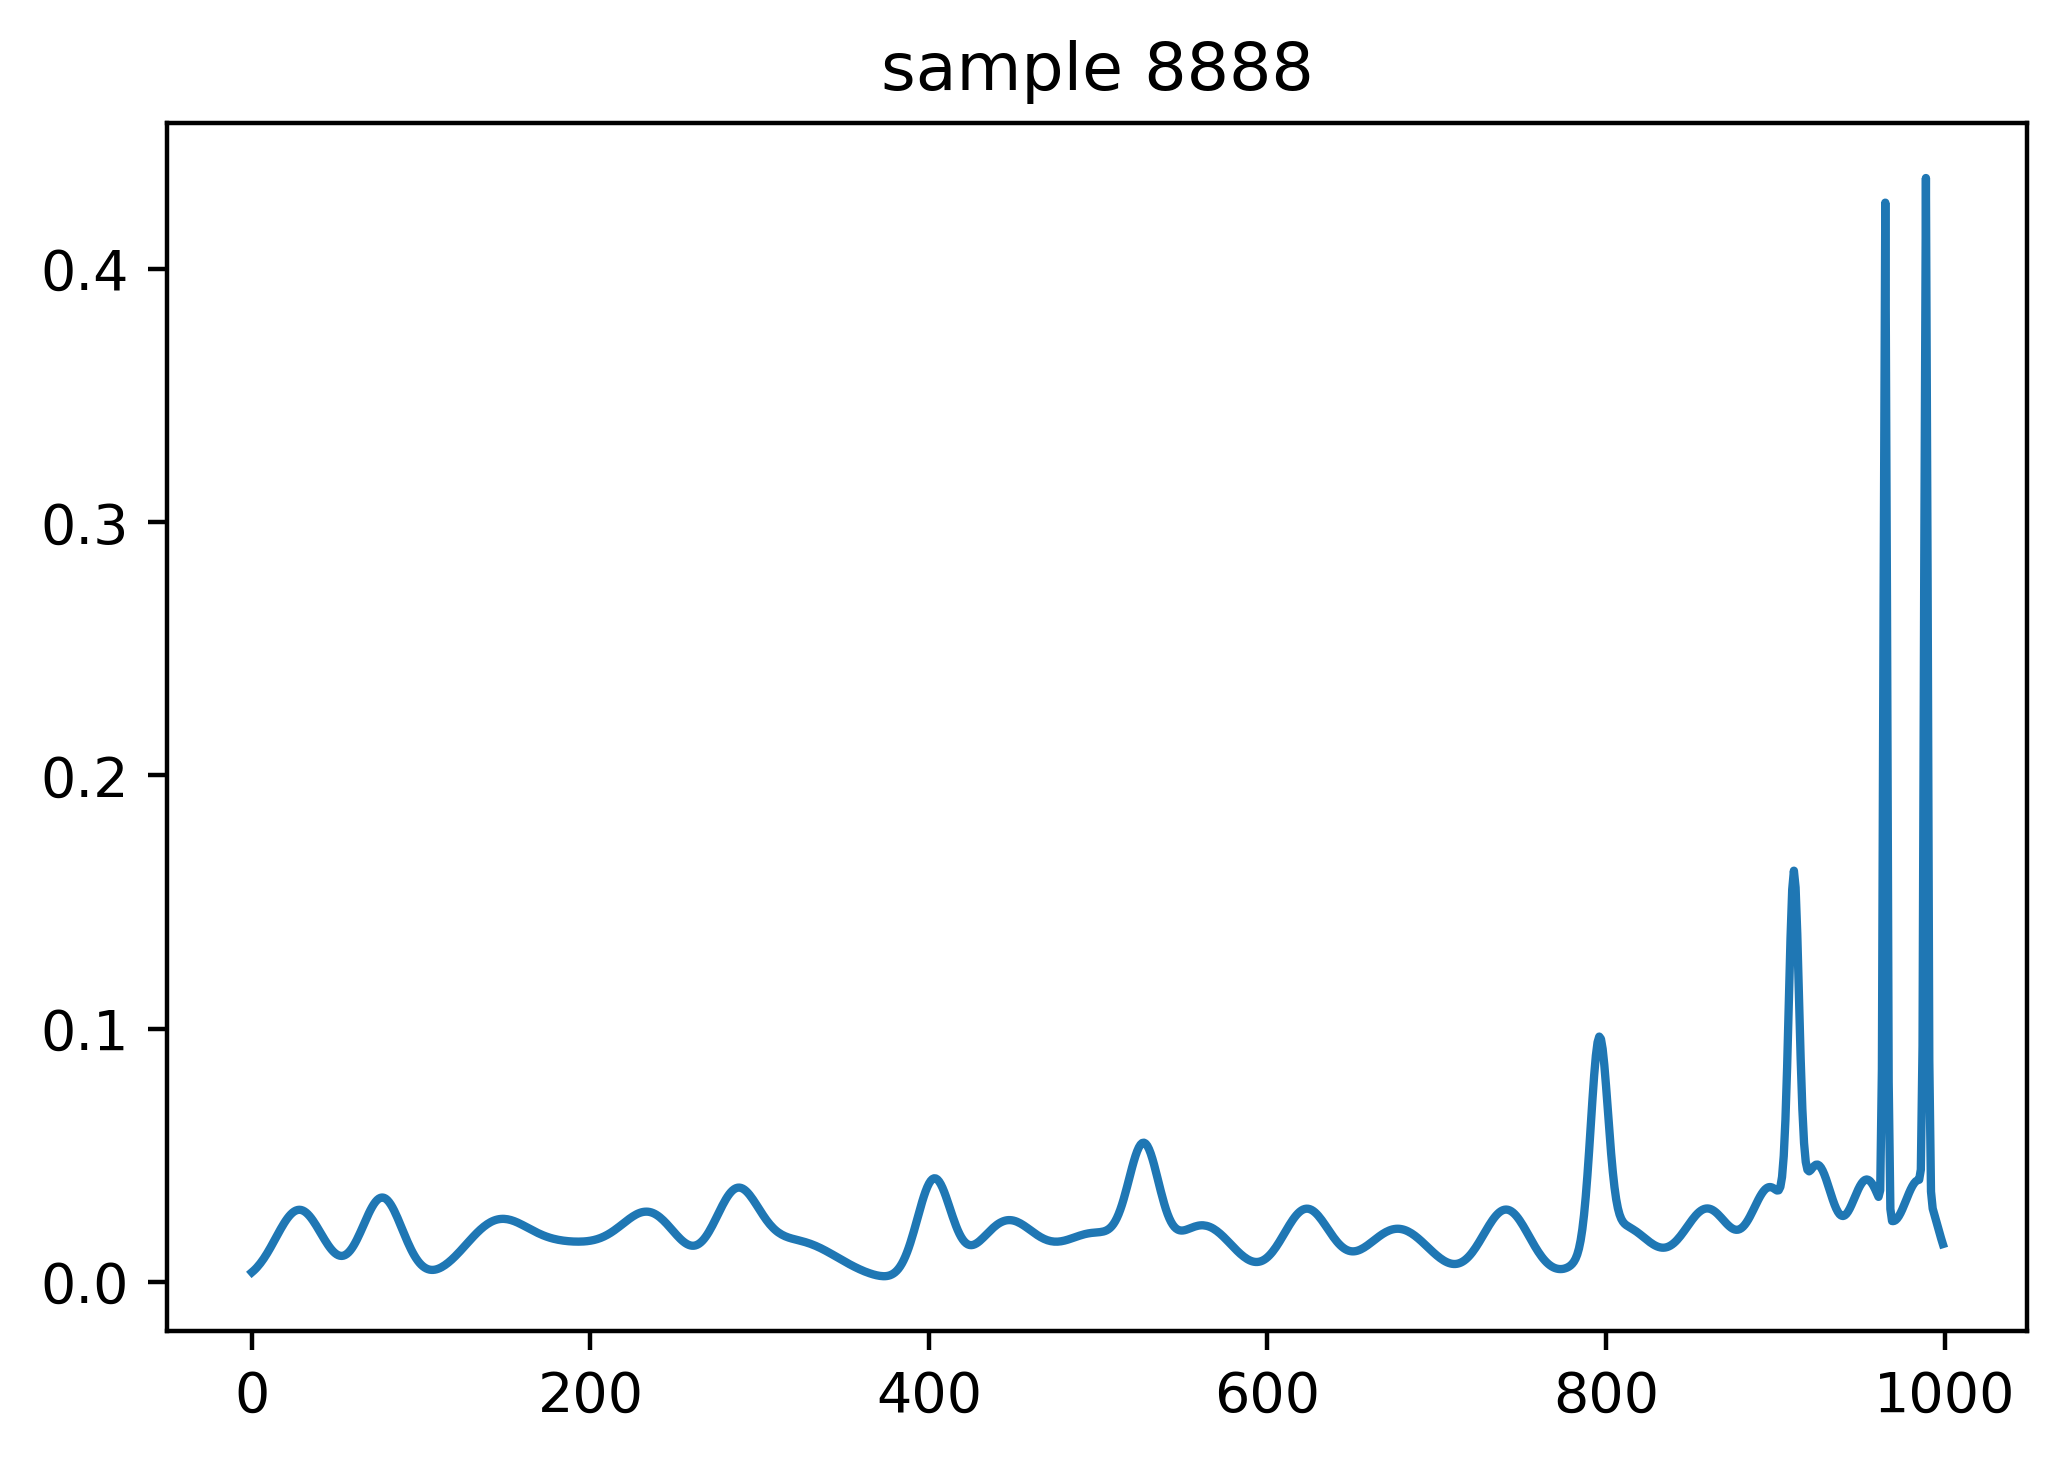

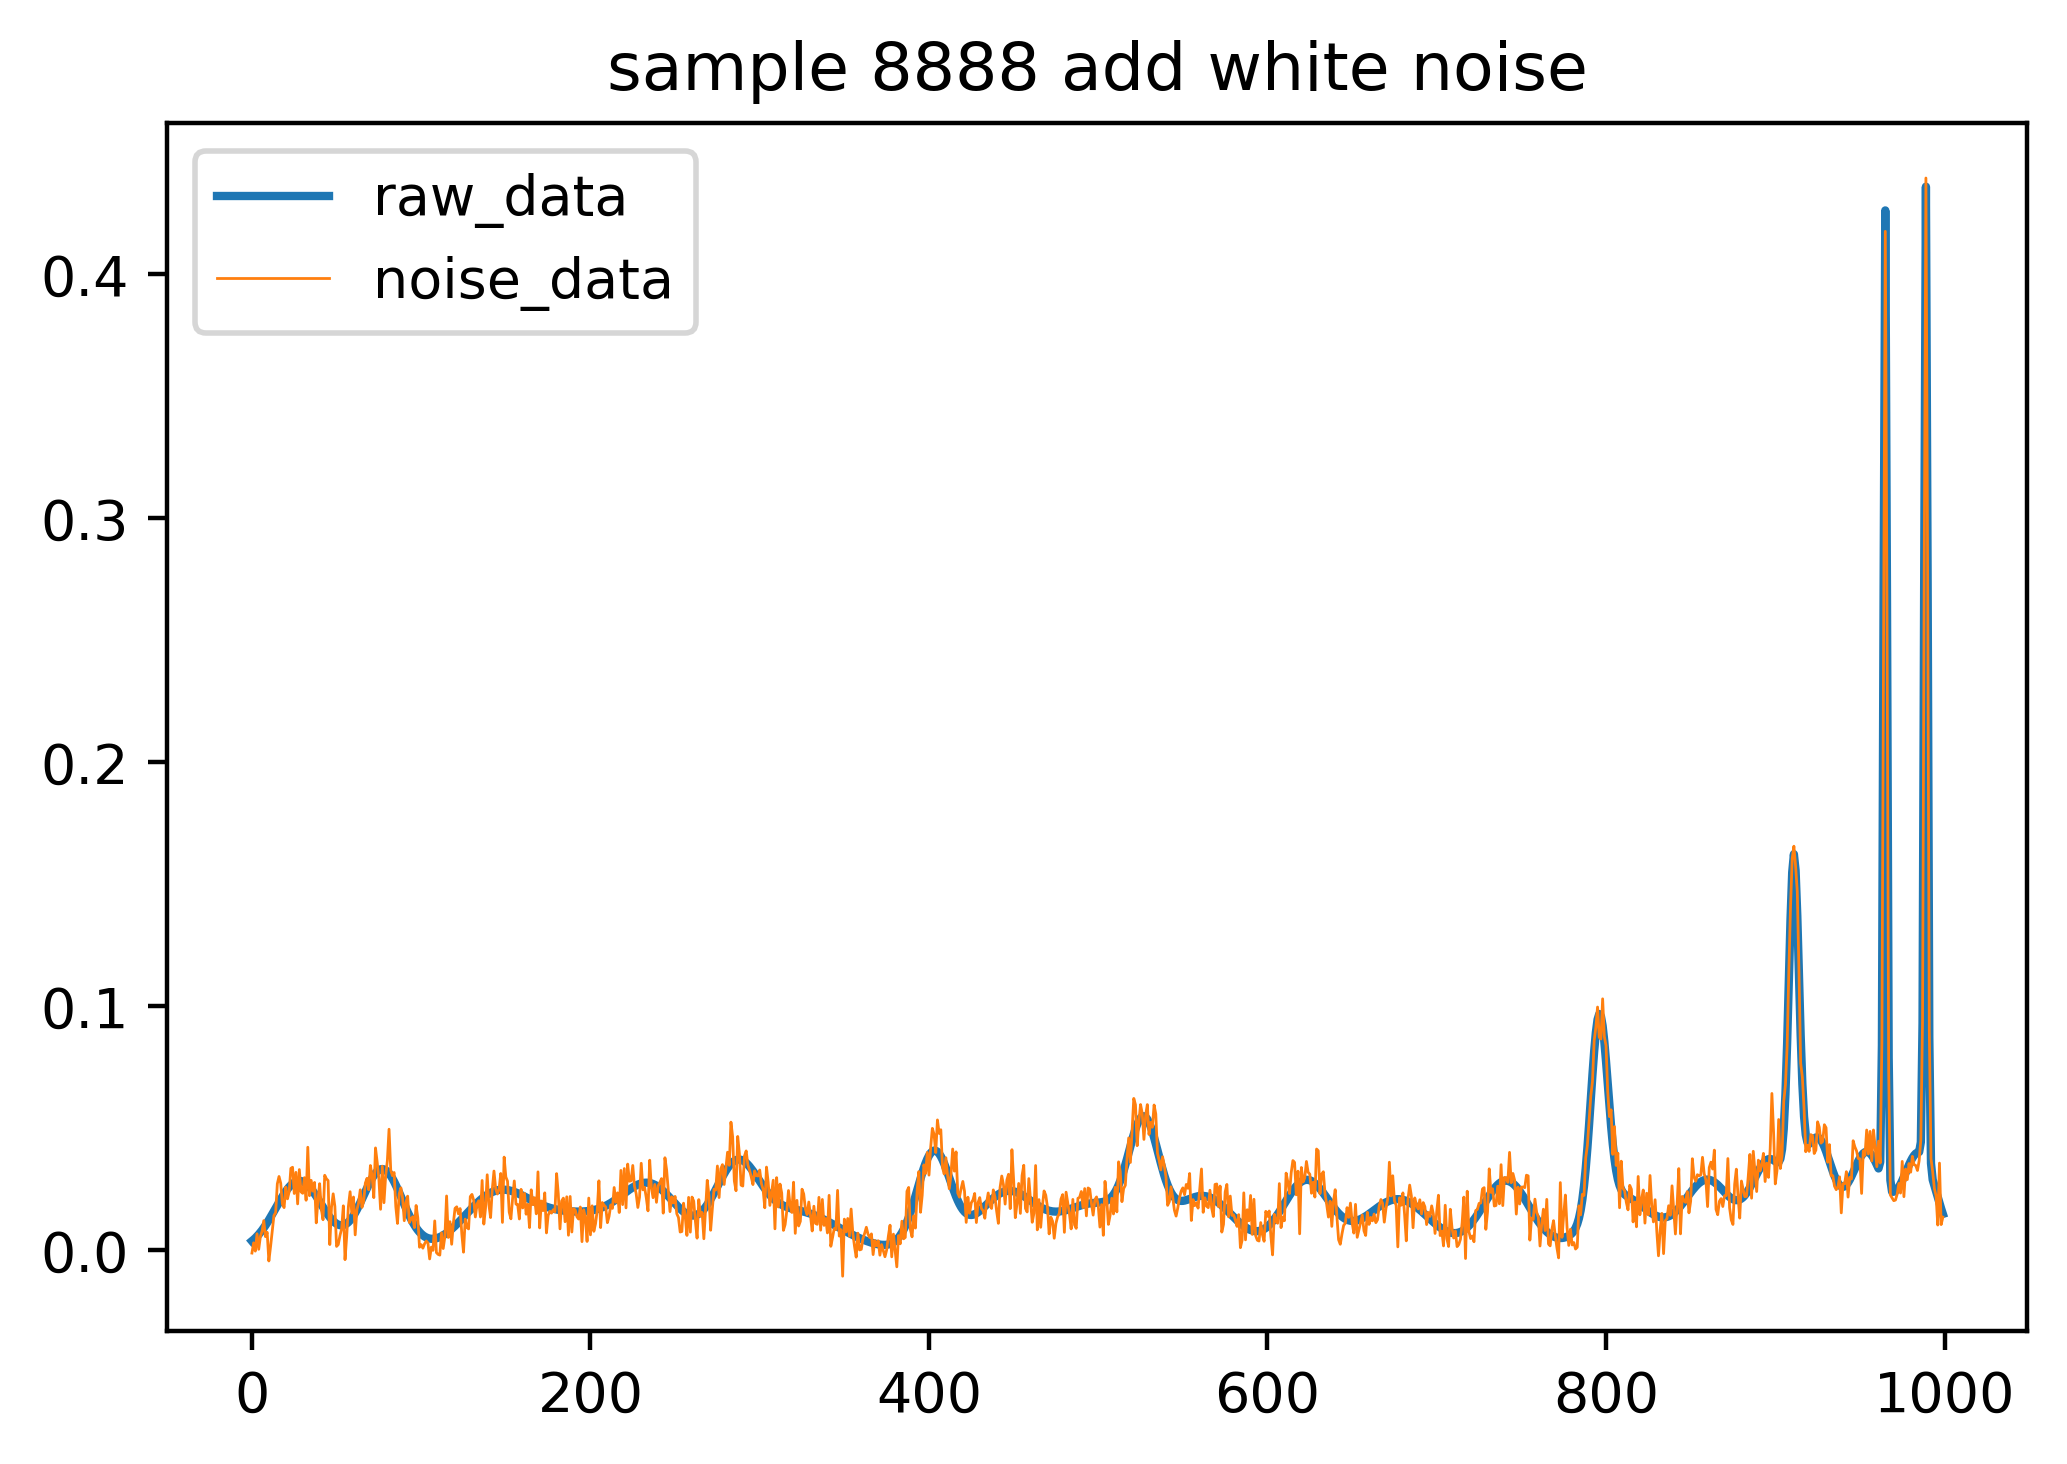

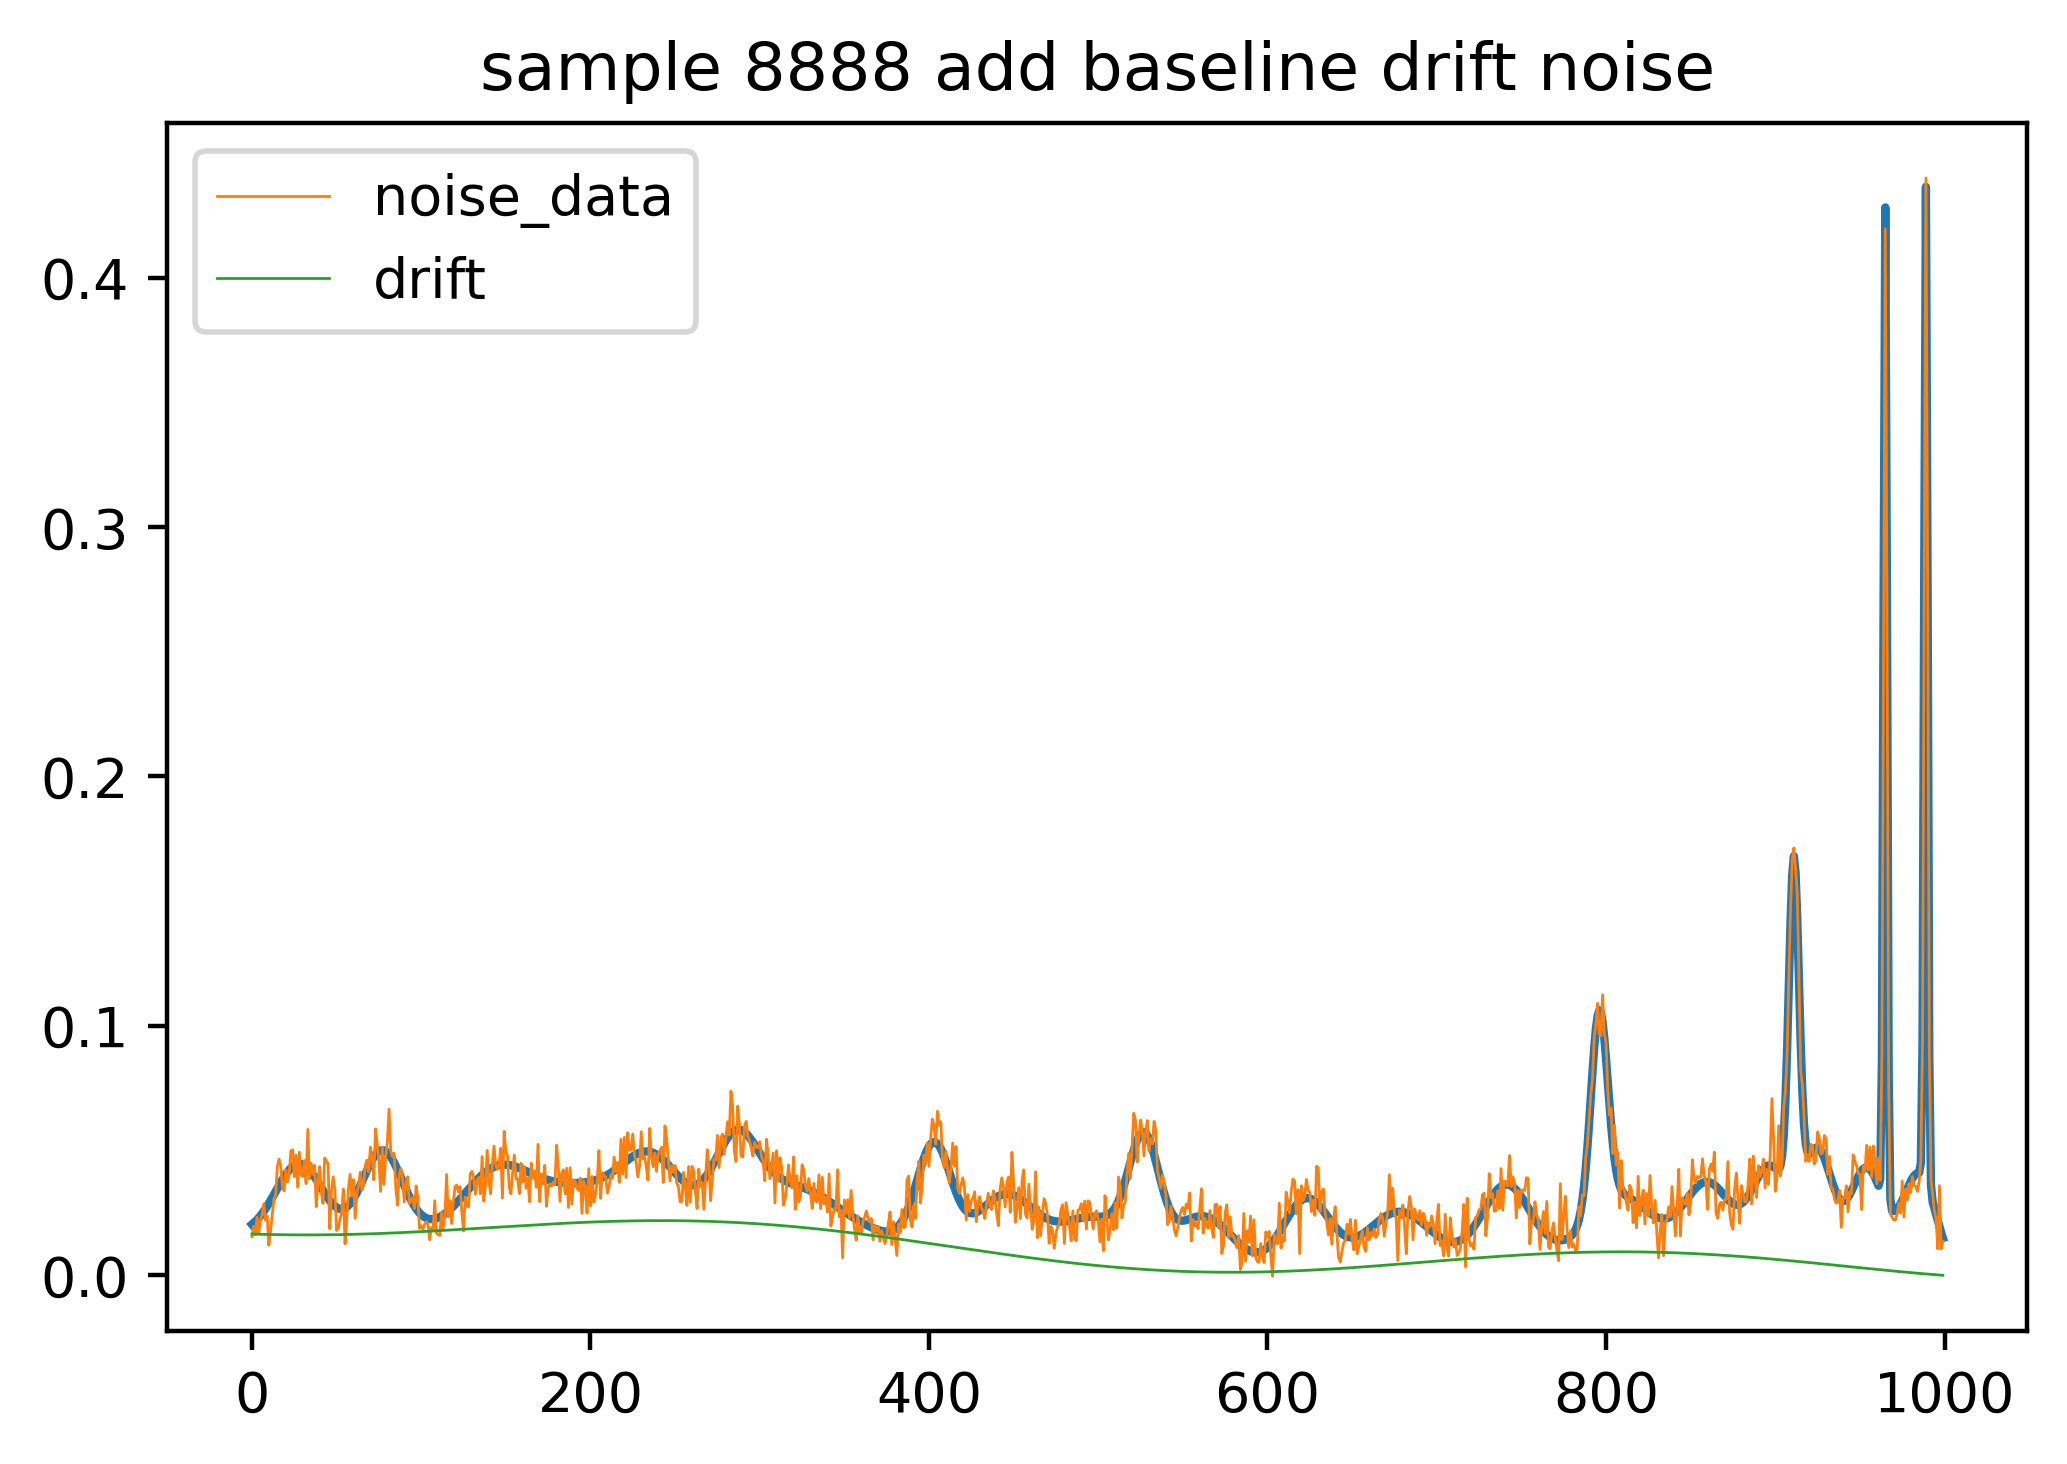

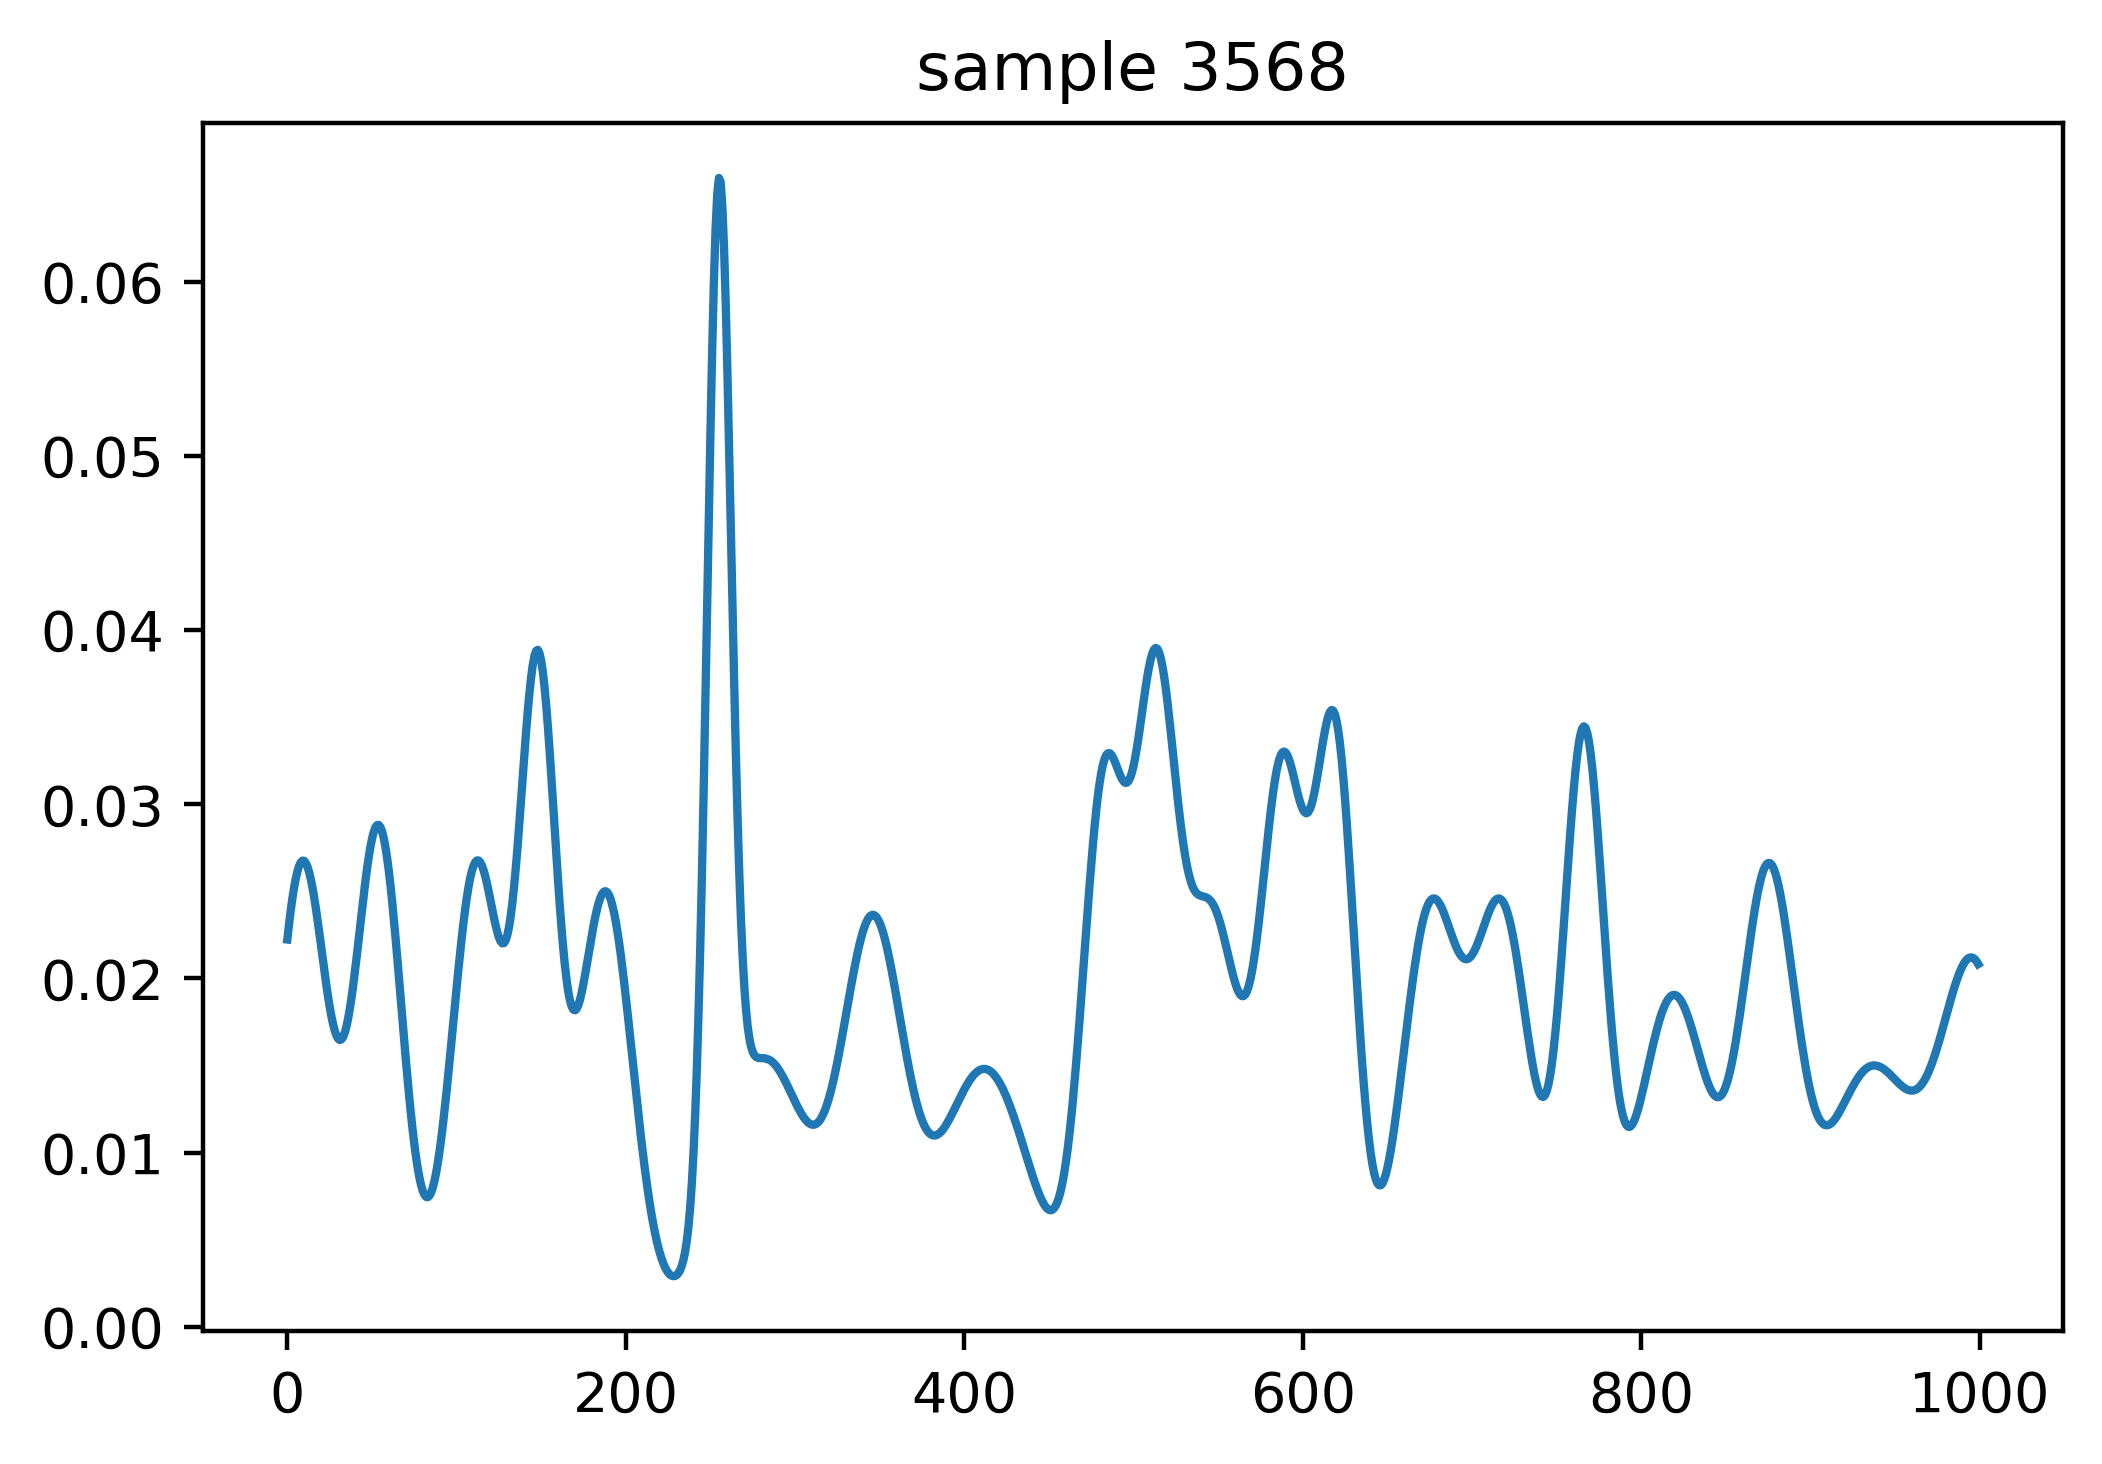

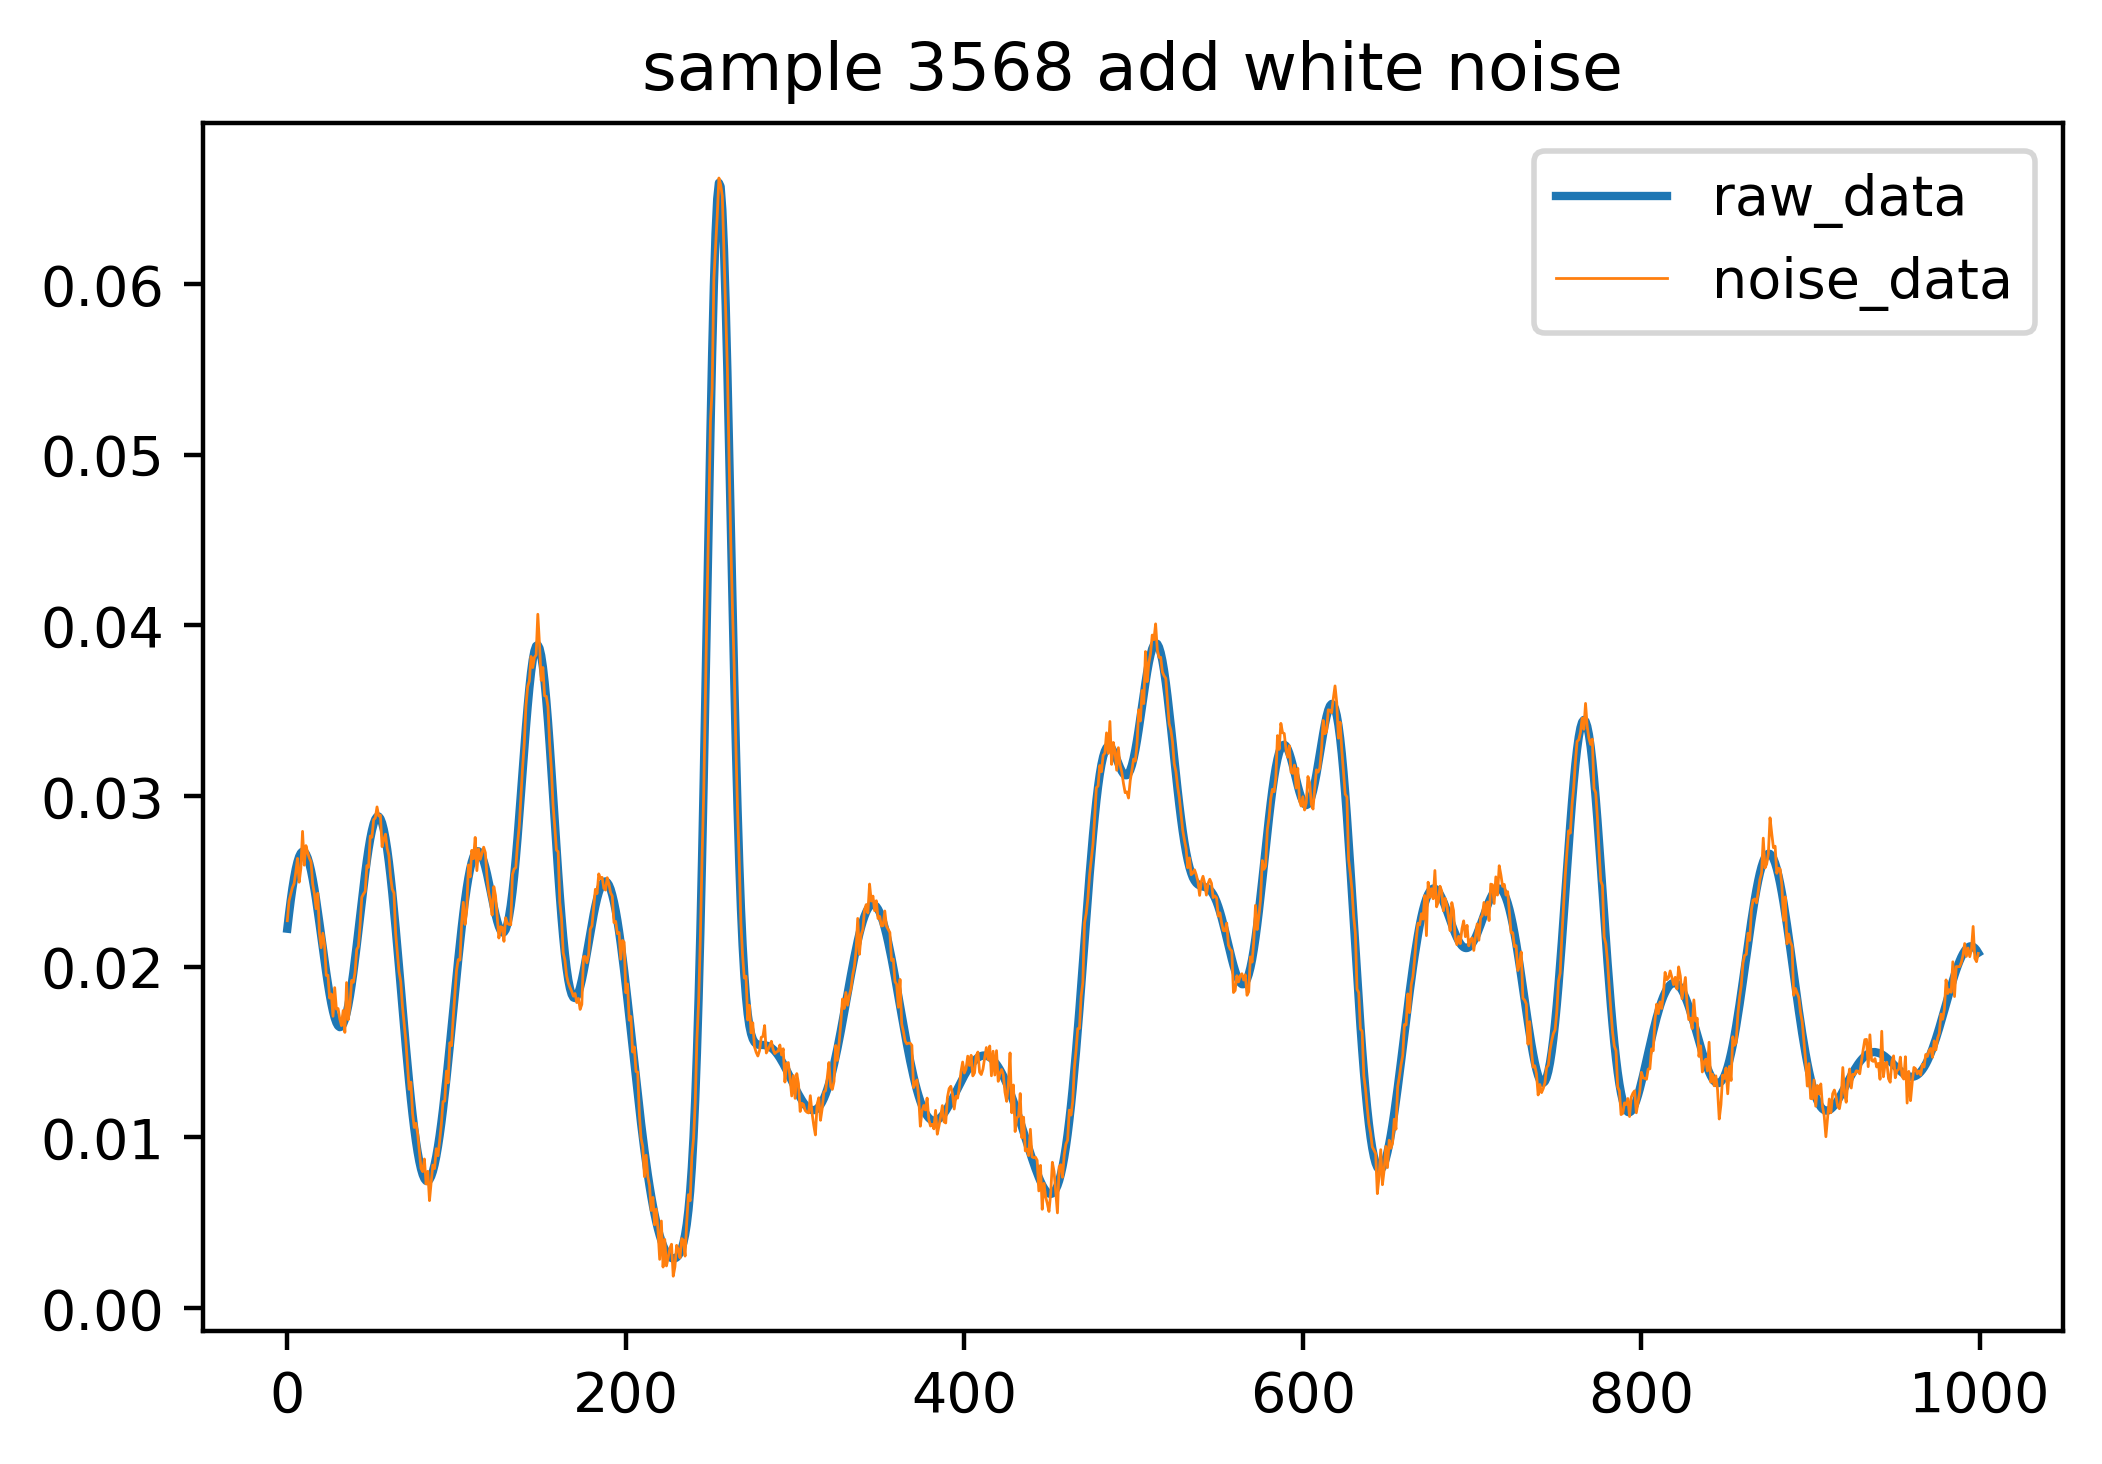

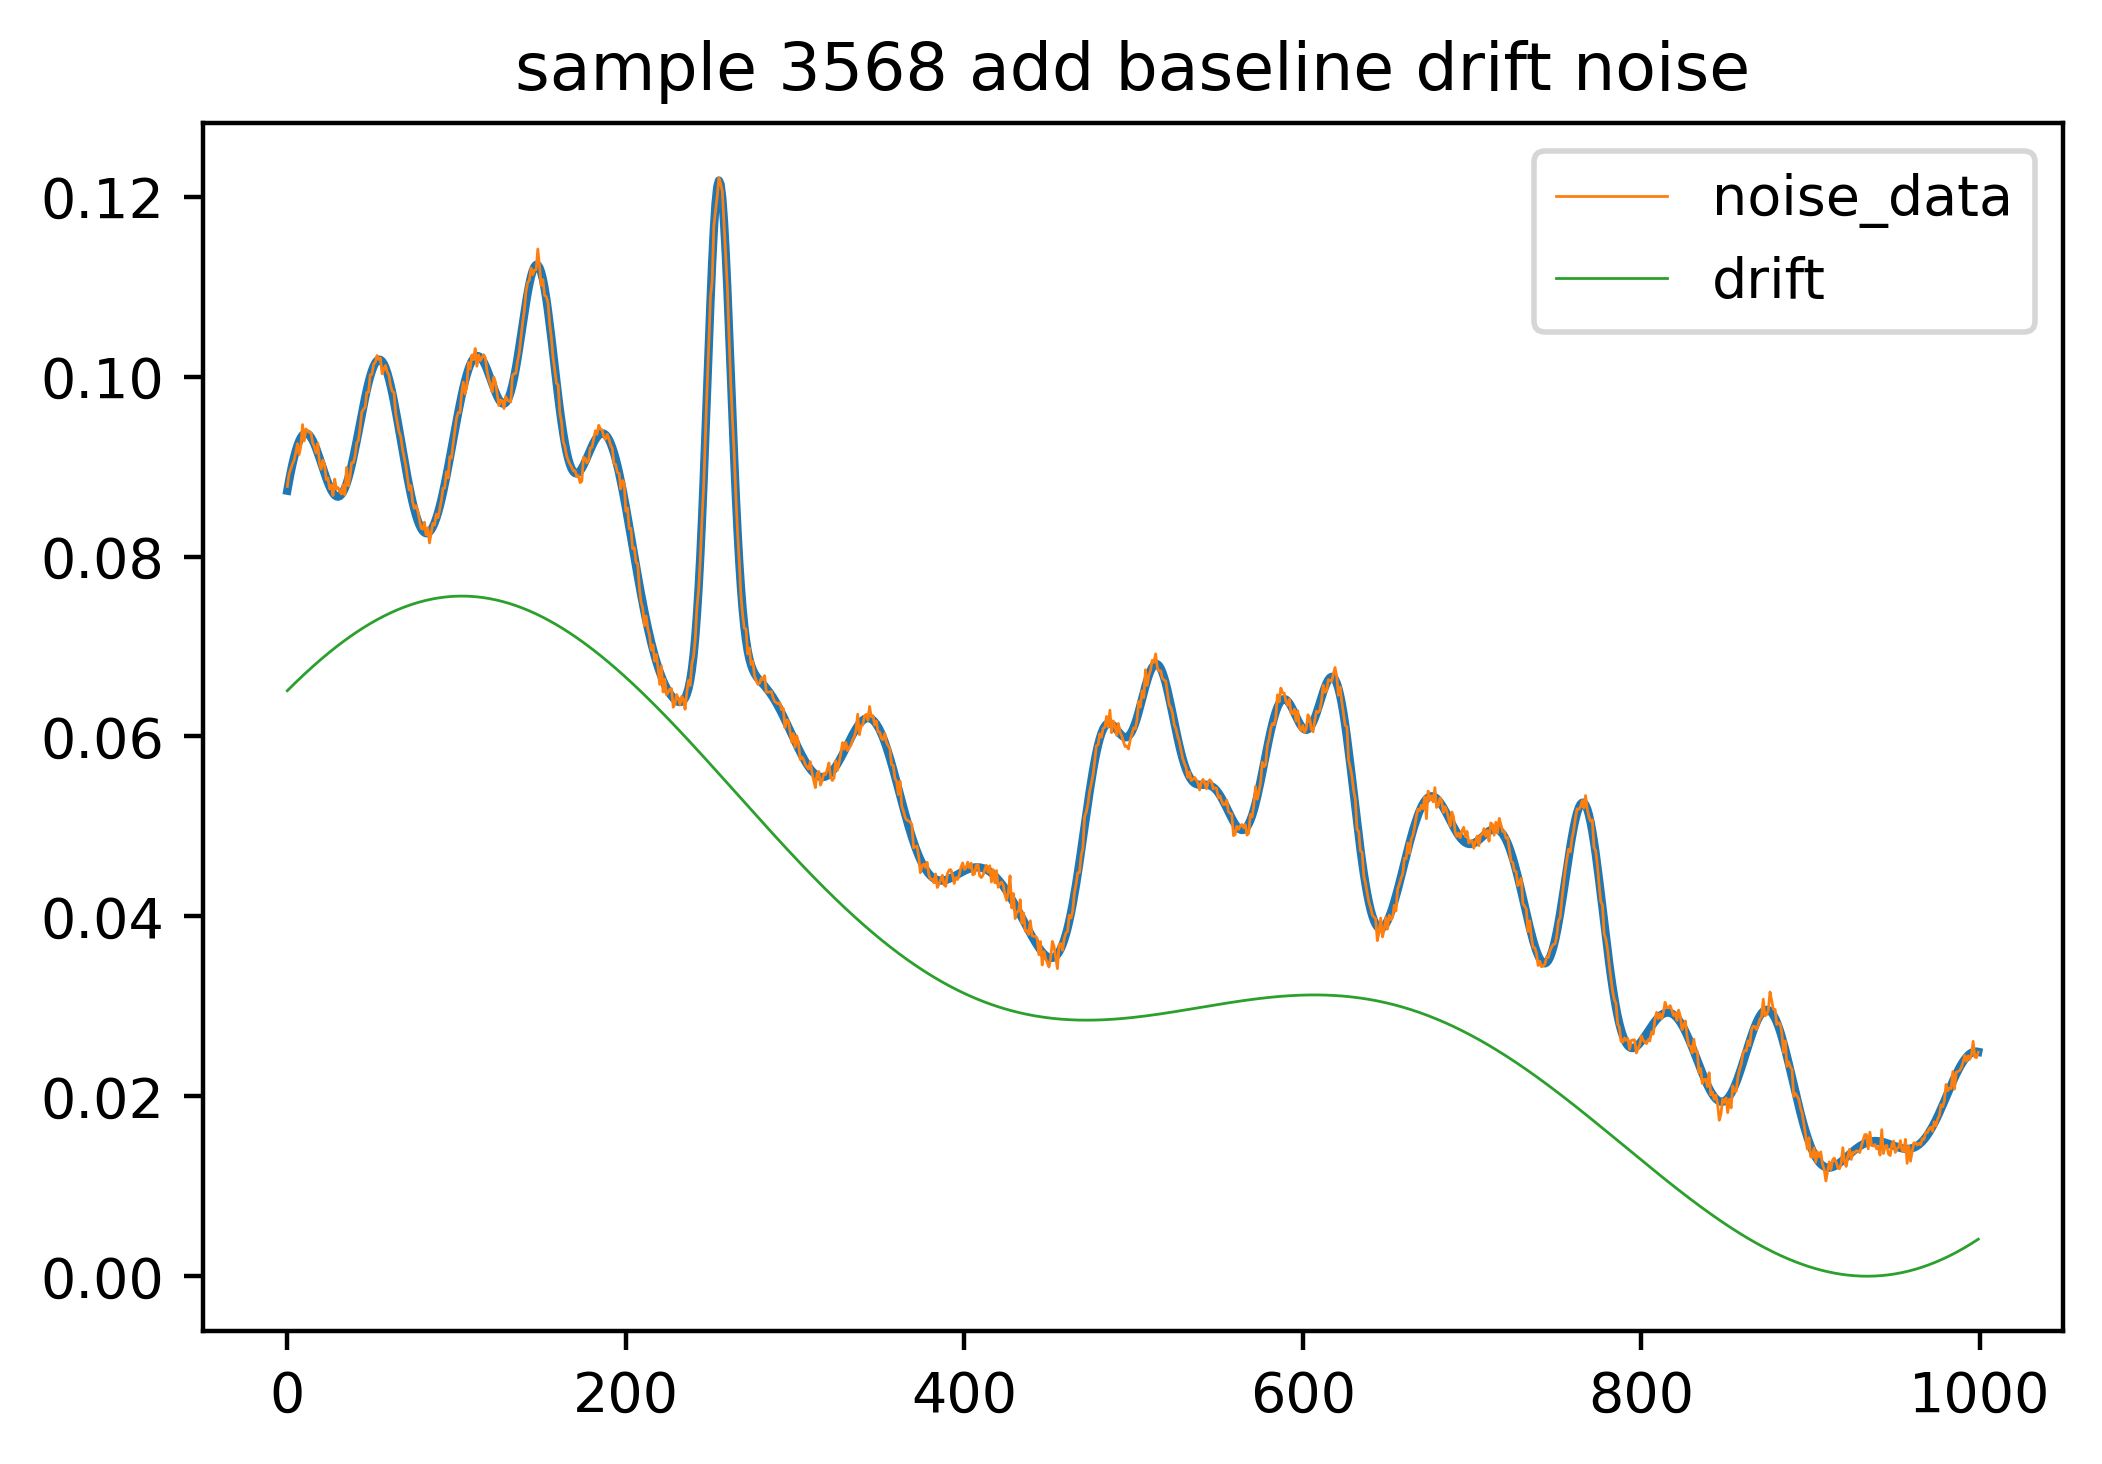

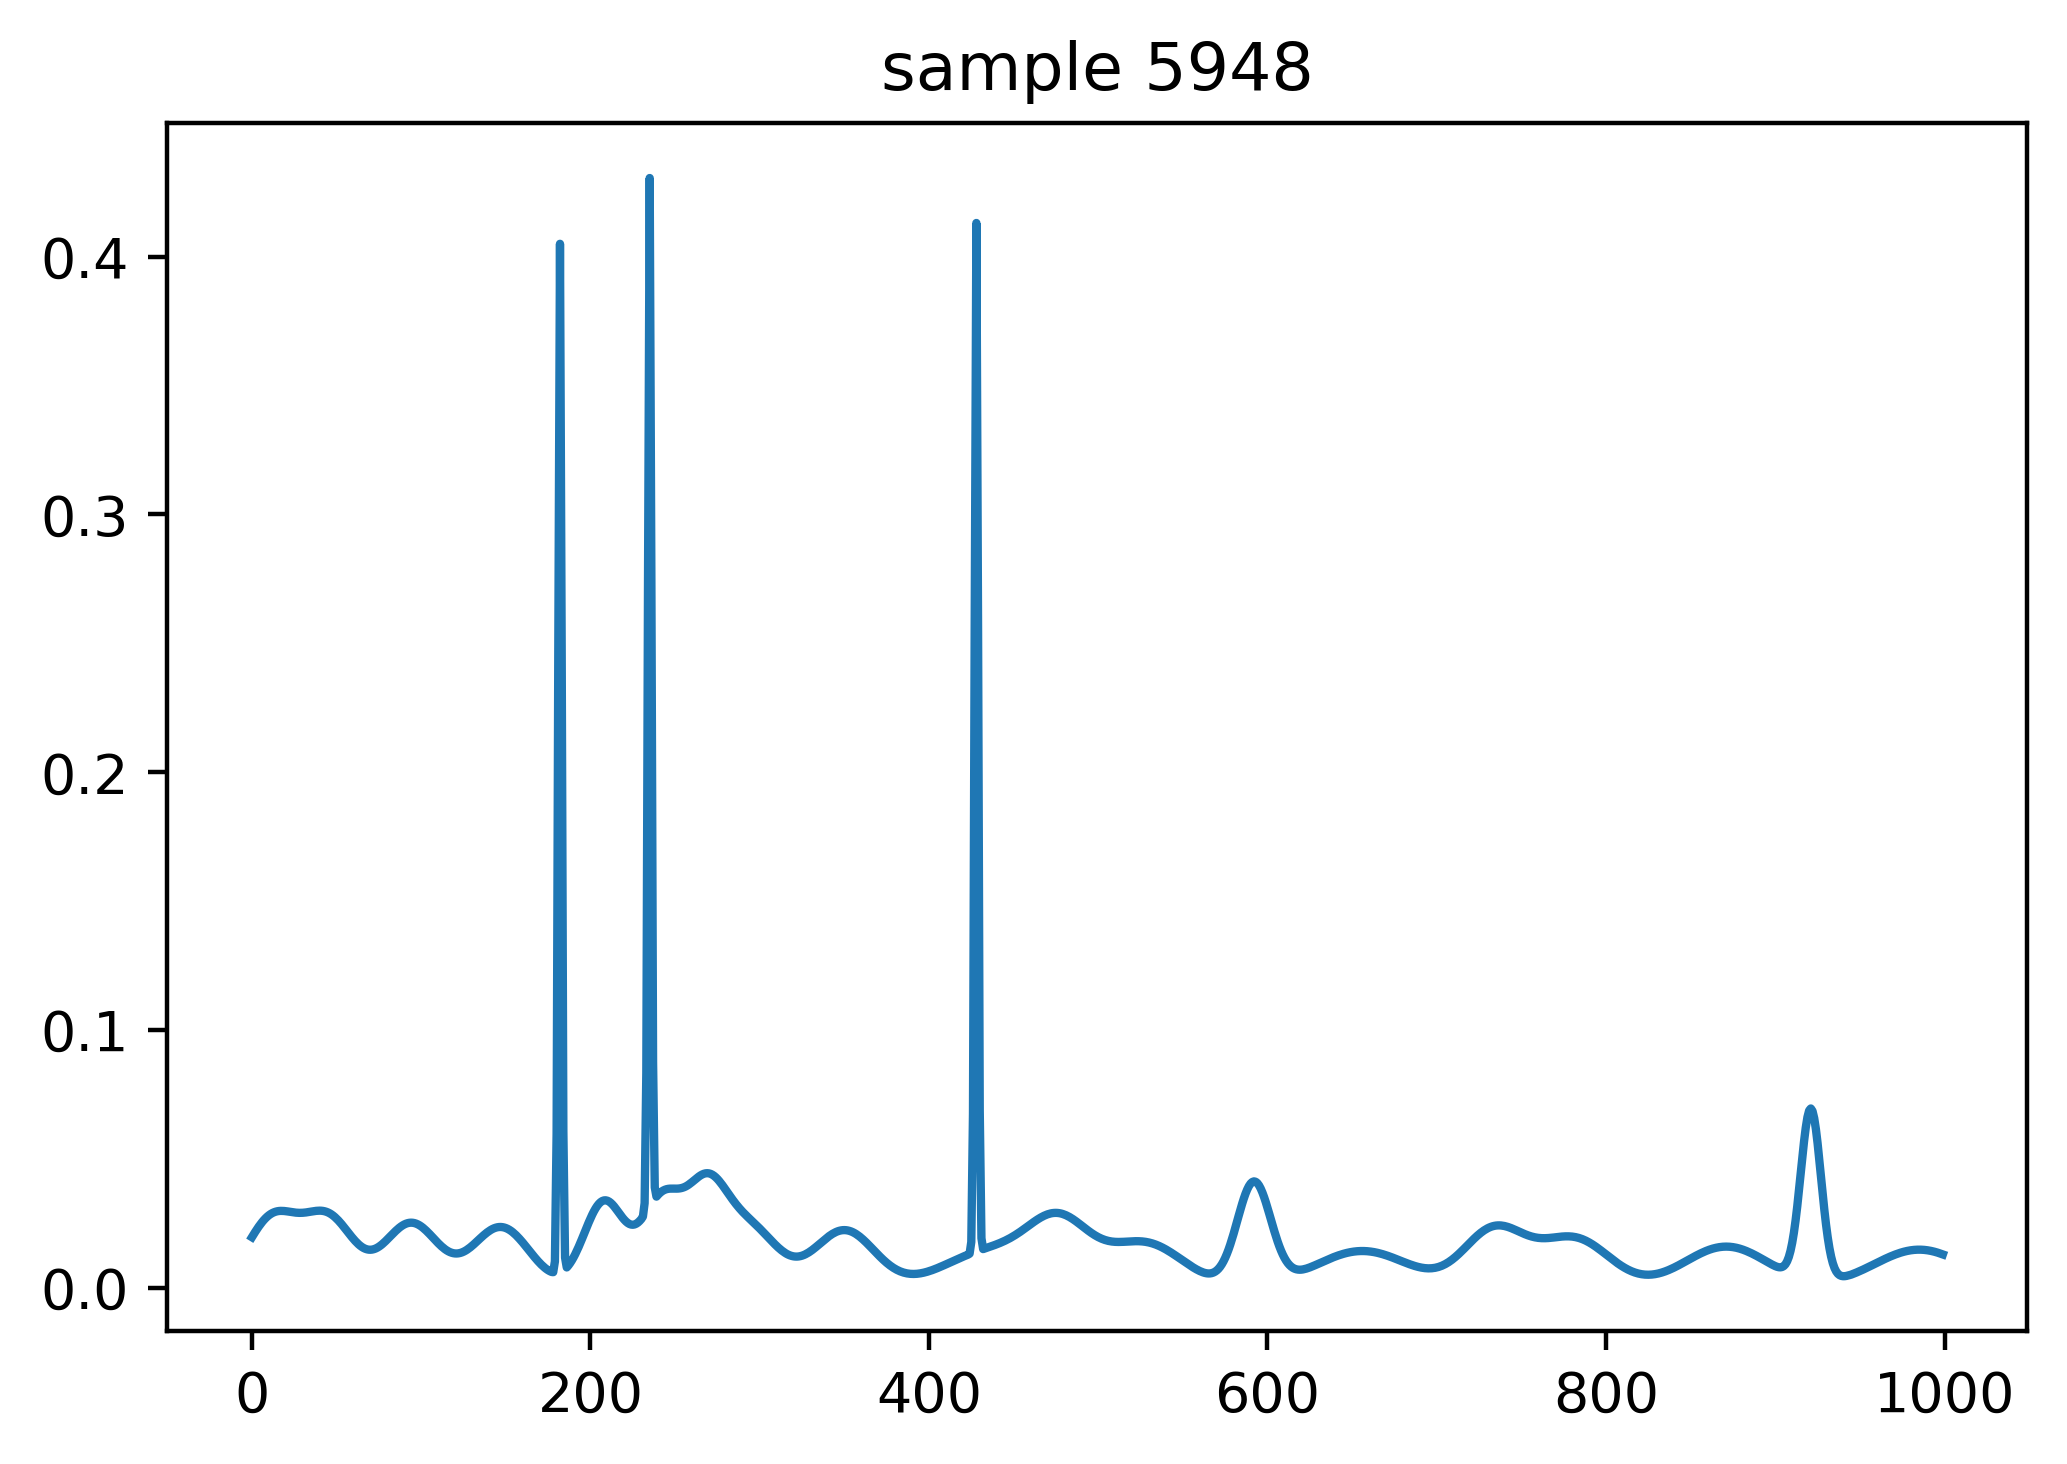

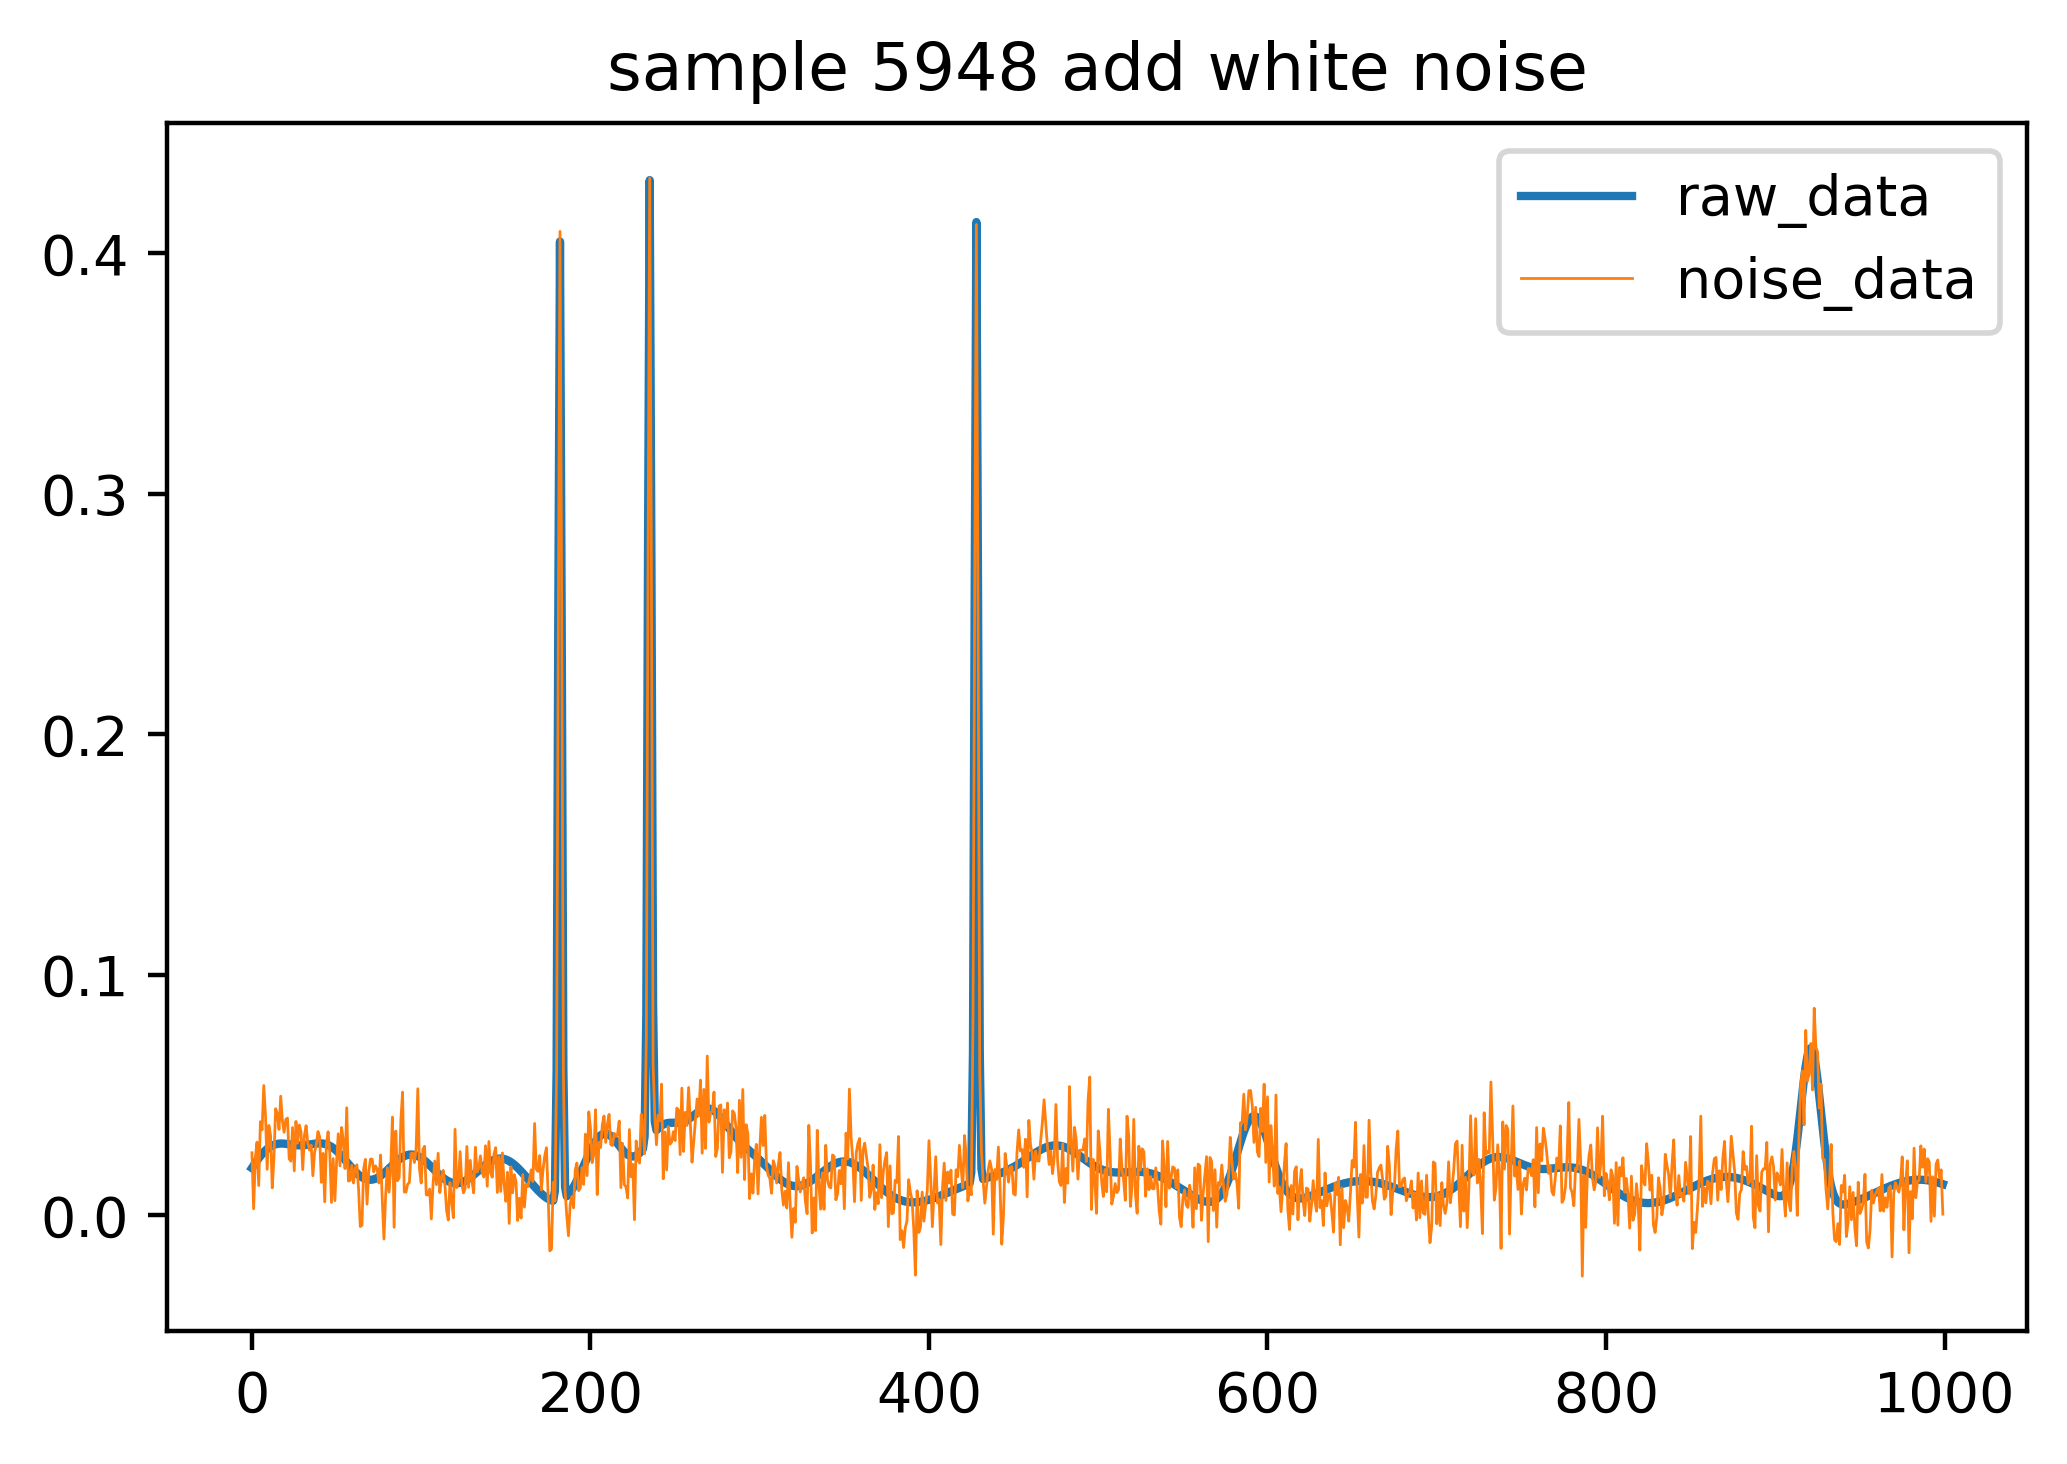

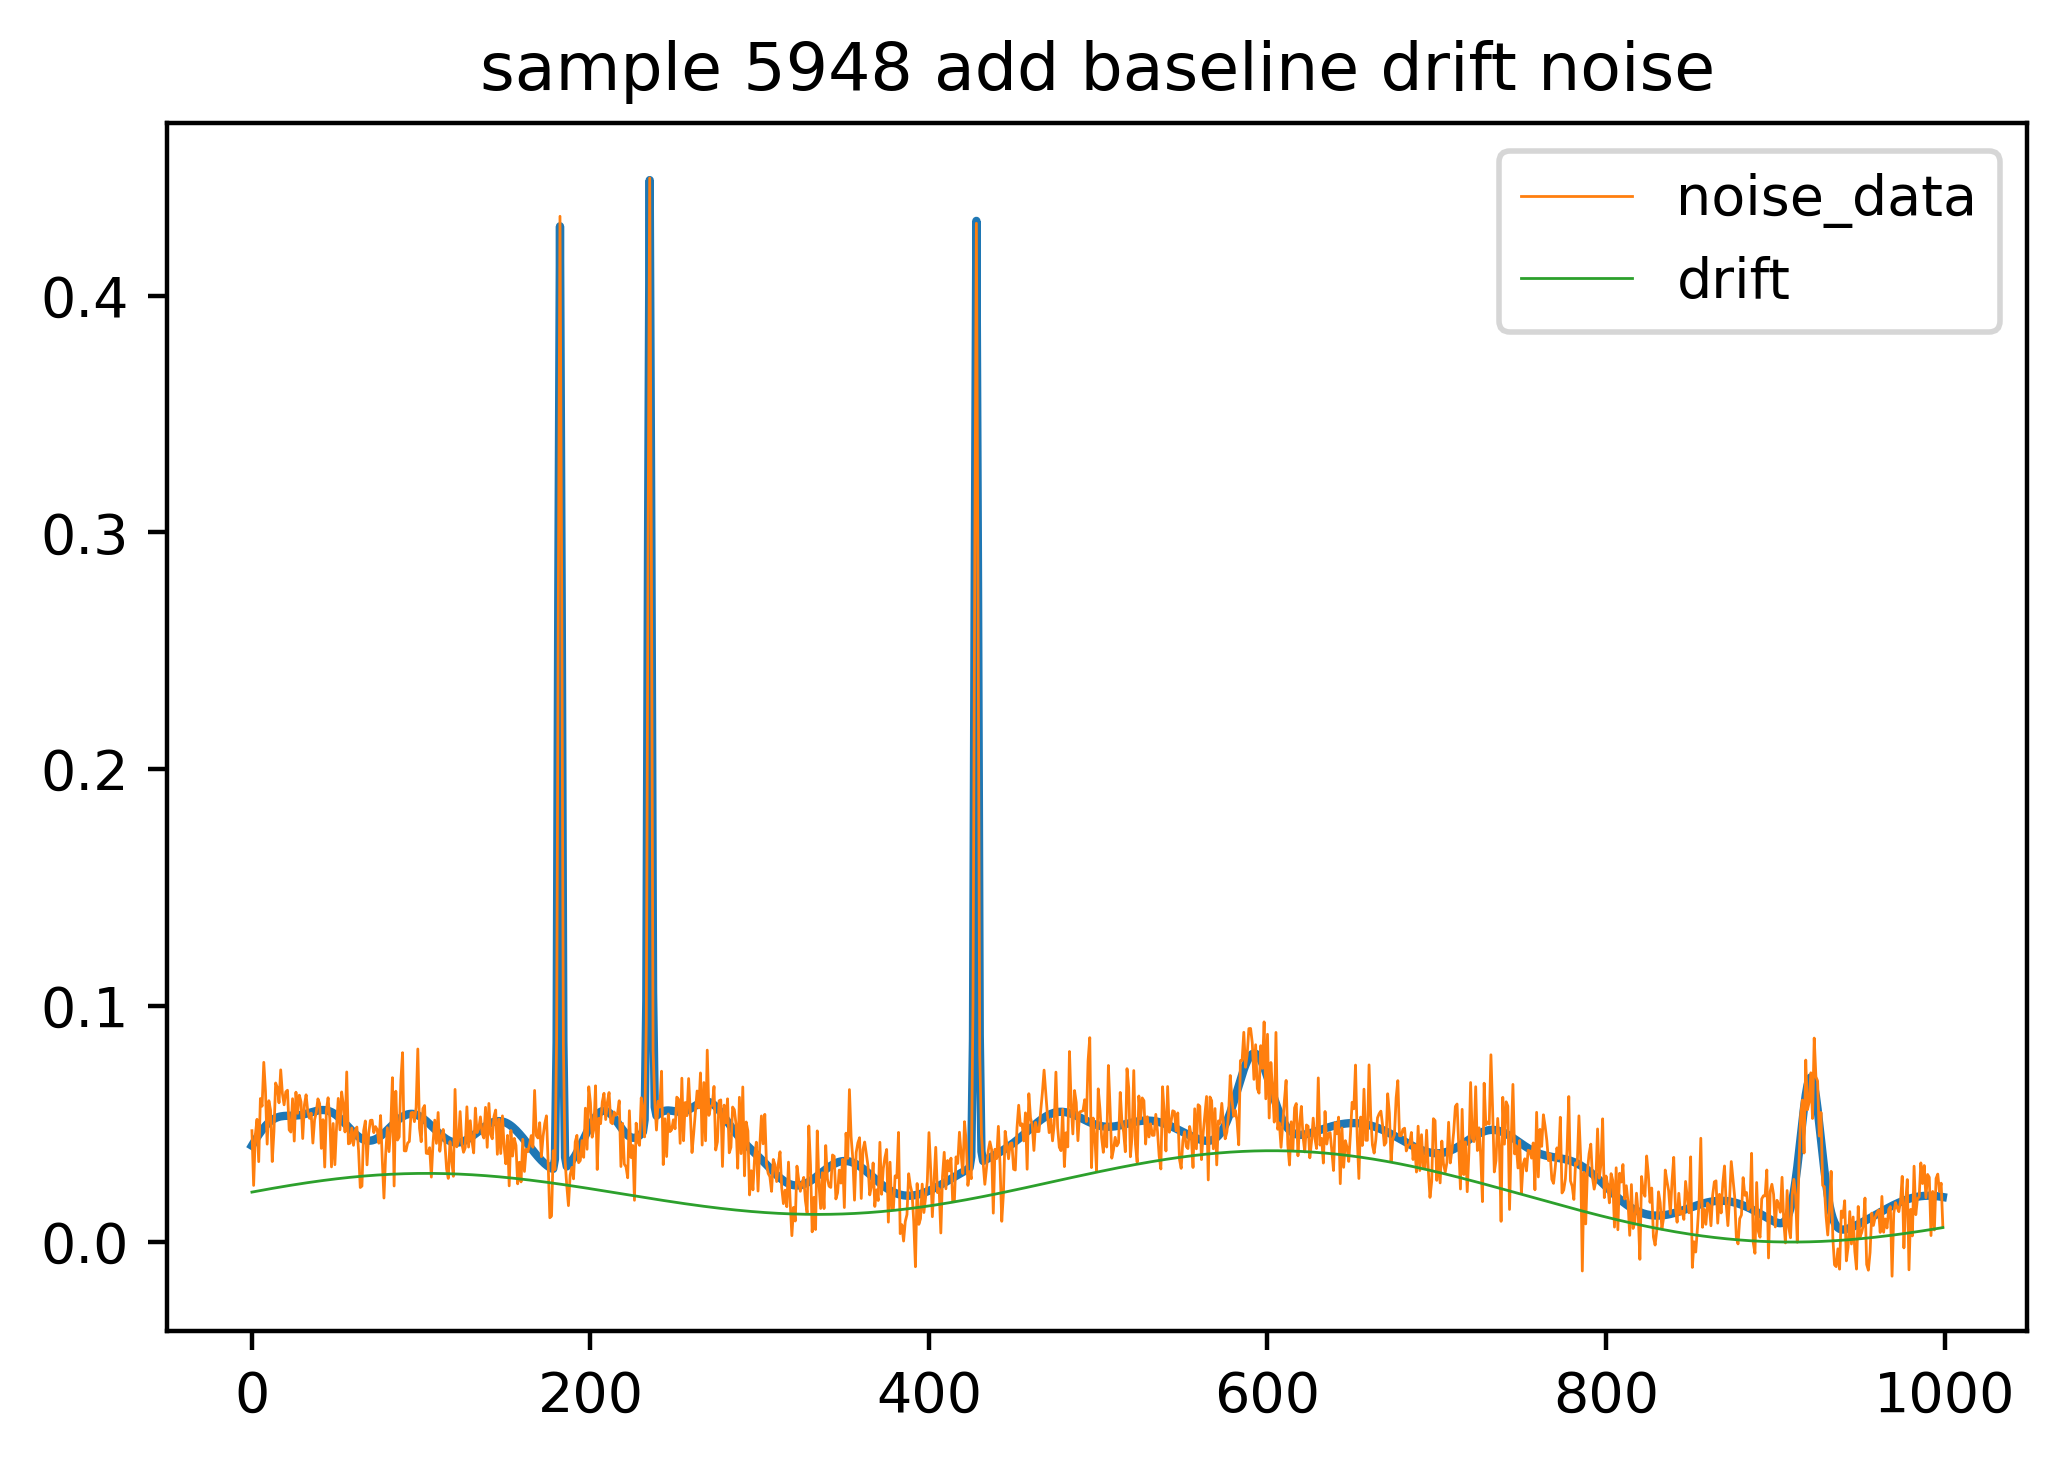

In [143]:
# 随机看10条

target_list = [1, 12, 123, 155, 455, 678, 4444, 8888, 3568, 5948]



for i in target_list:
    sample = raw_data[i, :]
    sample_drift = noise_data[i, :]
    noise = white_noise[i, :]
    drift = drift_noise[i, :]
    peak_info = np.load('../../data/simu_chromatography/peak_data/peak_'+str(i)+'.npy')

    plt.figure(dpi=400)
    plt.plot(sample)
    plt.title('sample ' + str(i))
    plt.show()

    plt.figure(dpi=400)
    plt.plot(sample, label='raw_data')
    plt.plot(sample+noise, linewidth=0.5, label='noise_data')
    plt.title('sample ' + str(i) + ' add white noise')
    plt.legend()
    plt.show()
    
    plt.figure(dpi=400)
    plt.plot(sample+drift, label='raw_data')
    plt.plot(sample_drift, linewidth=0.5, label='noise_data')
    plt.plot(drift, linewidth=0.5, label='drift')
    plt.title('sample ' + str(i) + ' add baseline drift noise')
    plt.legend()
    plt.show()
    